# Set Up

In [1]:
#command line items
%load_ext autoreload
%autoreload 2

#python imports
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage.filters import gaussian_filter
from astropy.cosmology import FlatLambdaCDM
from copy import copy
from numpy import nan
import pandas


from pylab import *
import astropy.io.fits as fits
from scipy.io import readsav
from matplotlib.colors import LogNorm
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import matplotlib.patches as patches
#from plot_grids import *
import scipy.integrate as integrate

Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
Yellow = '\033[93m'
Magenta = '\033[95m'
CEND = '\033[0m'

/tmp/ipykernel_32340/3860017640.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Calculate Scales

In [2]:
# [OII] and MgII wavelenght
o2 = [3726.03, 3728.82]
mg2 = [2795.5301, 2802.7056]

#Redshift of the source
z = 0.043118

#check that the python library gives the same result as the  manual calculation
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315, Tcmb0=2.725)
arcsec_kpc = cosmo.arcsec_per_kpc_proper(z) 
deg_kpc = arcsec_kpc / 60. /60. # degree size of 1 kpc

print(Green + 'Check using FlatLambdaCDM, scale:' + CEND, arcsec_kpc, 1/arcsec_kpc)

#Set some constants
h0 = 67.4
Om = 0.315
Ol = 1 - Om
c_light = 299792.458

#Estimate the Angular Diameter Distance 
def func(x):
    return 1/np.sqrt( Om * (1+x)**3 + Ol)

result = integrate.quad(lambda x: func(x), 0, z)
da = c_light/h0*1/(1+z)* (result[0])
print(Red + 'Angular Diameter Distance is' + CEND, da, Red + 'Mpc' + CEND)

# 4.84814e-6 is rad in arcsec, 1000 is to have the scale in kpc
x = da * 1000 * 4.84814e-6

# 8.096e-5 is the pixel scale along slice, 3600 is to convert it in arcsec (0.291456)
pixel_size = 8.096e-5 * 3600
pixel_scale = x * pixel_size


arcsec_pixel =  pixel_scale / x

print (Blue + "Scale: 1 arcsec is" + CEND, x, Blue + "kpc" + CEND)
print (Magenta + "Scale: 1 pixel is" + CEND, pixel_scale, Magenta + "kpc" + CEND)
print (Cyan + "FOV for z" + CEND, z, Cyan + "is" + CEND, 16.5 * x, 'x', 20.4 * x, Cyan + "kpc" + CEND,)
print (Yellow + "Scale: 1 pixel is" + CEND, arcsec_pixel, Yellow + "arcsec" + CEND)


Check using FlatLambdaCDM, scale: 1.1335033945669866 arcsec / kpc 0.8822205604262997 kpc / arcsec
Angular Diameter Distance is 181.9717830858933 Mpc
Scale: 1 arcsec is 0.8822246804500427 kpc
Scale: 1 pixel is 0.25712967646524765 kpc
FOV for z 0.043118 is 14.556707227425704 x 17.99738348118087 kpc
Scale: 1 pixel is 0.291456 arcsec


# Functions to remove spaxels with flxerr < err_thresh

In [3]:
err_thresh = 0.0022 #set the error threshold after exploring the error arrays

def set_sn(arr, arr2):
    sn_cut = np.where(arr < 3) #change here the SN threshold, now set to 3
    arr2[sn_cut] = nan   #if the SN is less than 5, remove that spaxel
    return arr2

def set_bad(arr):
    bad = (arr > 1e90)   
    arr[bad] = nan   
   # bad2 = (arr < 1e-26)
   # arr[bad2] = nan
    return arr   

def get_flux_uncorr(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)  

    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
        
    sn = f/f_err
    f = set_sn(sn,f)  
    return f

def get_err_flux(idx, arr):
    f_err = copy(arr[idx][1])
    f_err = set_bad(f_err)  
    
    return f_err

    
def get_v50(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])

    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v 

def get_vsig(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_v02(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_v98(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_sn(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    sn_cut = np.where(sn < 3) #change here the SN threshold, now set to 3
    sn[sn_cut] = nan 
    return sn

# Read and Load

## Read Files (1comp fit)

In [11]:
data_1comp = readsav('/home/acoil/AGN_outflows_ifsfit/F05189/iter3/F05189.xdr')
data_arr_1comp = data_1comp['windstr']

lin_data_1comp = readsav('/home/acoil/AGN_outflows_ifsfit/F05189/iter3/F05189.lin.xdr')
# print(lin_data_1comp.keys())

## Load Arrays (1comp fit)

In [30]:
data_flx_1comp = lin_data_1comp['emlflx'][0][8]
data_flx_err_1comp = lin_data_1comp['emlflxerr'][0][8]
vel_arr_1comp = data_arr_1comp['E_VEL'][0][0][8]

# print('###### FLUX AND ERR #########') 
# for i in range(len(data_flx_1comp)):
#     if data_flx_1comp[i][0] != None:
#         print(i,data_flx_1comp[i][0])
            
# print('####### VEL ########')        
# for i in range(len(vel_arr_1comp)):
#     if vel_arr_1comp[i][0] != None:
#         print(i,vel_arr_1comp[i][0])        

## Read Files (2comp fit)

In [13]:
data = readsav('/raid/KCWI/AGN_outflows/F05189/iter2/F05189.xdr')
data_arr = data['windstr']
# print(data_arr.dtype.names)
# print(data.keys())

lin_data = readsav('/raid/KCWI/AGN_outflows/F05189/iter2/F05189.lin.xdr')
# print(lin_data.keys())

## Load Arrays (2comp fit)

In [31]:
data_flx = lin_data['emlflx'][0][8]
data_flx_err = lin_data['emlflxerr'][0][8]
vel_arr = data_arr['E_VEL'][0][0][8]

# print('###### FLUX AND ERR #########') 
# for i in range(len(data_flx)):
#     if data_flx[i][0] != None:
#         print(i,data_flx[i][0])
            
# print('####### VEL ########')        
# for i in range(len(vel_arr)):
#     if vel_arr[i][0] != None:
#         print(i,vel_arr[i][0])        

# Arrays

## Flux and Velocity (1comp fit)

In [56]:
fc_1comp = data_flx_1comp[0][1][0][8]
err_fc_1comp = data_flx_err_1comp[0][1][0][8]

vsig_1comp = vel_arr_1comp[16][1][0][8]
v50_1comp = vel_arr_1comp[15][1][0][8]
v98_1comp = vel_arr_1comp[9][1][0][8]
v02_1comp = vel_arr_1comp[17][1][0][8]

# snr_1comp = get_sn(ion,fc_1comp,err_fc_1comp)

## Total Flux and Velocity (2comp fit)

In [57]:
ftot = data_flx[0][1][0][8]
err_ftot = data_flx_err[0][1][0][8]

print('####### LINES ########') 
for i in range(len(ftot)):
    if ftot[i][0] != None:
        print(i,ftot[i][0])

vsig_tot = vel_arr[16][1][0][8]
v50_tot = vel_arr[15][1][0][8]
v98_tot = vel_arr[9][1][0][8]
v02_tot = vel_arr[17][1][0][8]

####### LINES ########
0 b'Hbeta'
4 b'[OII]3726'
5 b'[OII]3726+[OII]3729'
9 b'[NeIII]3869'
12 b'[OII]3729'
13 b'[OIII]5007'
14 b'[OIII]4959'
15 b'Hgamma'


## First Component Flux and Velocity (2comp fit)

In [58]:
fc1 = data_flx[5][1][0][8]
err_fc1 = data_flx_err[5][1][0][8]

vsig_c1 = vel_arr[10][1][0][8]
v50_c1 = vel_arr[5][1][0][8]
v98_c1 = vel_arr[28][1][0][8]
v02_c1 = vel_arr[4][1][0][8]

## Second Component Flux and Velocity (2comp fit)

In [59]:
fc2 = data_flx[1][1][0][8]
err_fc2 = data_flx_err[1][1][0][8]

vsig_c2 = vel_arr[12][1][0][8]
v50_c2 = vel_arr[18][1][0][8]
v98_c2 = vel_arr[8][1][0][8]
v02_c2 = vel_arr[21][1][0][8]

# START HERE

# Set up new FITS file

In [19]:
fits_y = len(ftot[5][1])
fits_x = len(ftot[5][1][0])

print('rows: ', fits_y)
print('columns: ', fits_x)

rows:  97
columns:  74


# Check for second component in 2comp fit

In [20]:
check_c2 = np.zeros((fits_y, fits_x))

for i in np.arange(fits_y):
    for j in np.arange(fits_x):
        if fc1[5][1][i][j] != 0. and fc2[5][1][i][j] < 1e+99:
            check_c2[i][j] = 1.
        else:
            check_c2[i][j] = 0.

# Identify first vs second component and populate new FITS file

In [15]:
# ftot
# fc1
# fc2
# err_fc1
# err_fc2
# vsig_tot
# v50_tot
# v98_tot
# v02_tot
# vsig_c1
# v50_c1
# v98_c1
# v02_c1
# vsig_c2
# v50_c2
# v98_c2
# v02_c2
# snr_tot
# snr_c1
# snr_c2

In [60]:
# initialize arrays

n = np.zeros((fits_y, fits_x))
ftot_arr = np.copy(n)
fc1_arr = np.copy(n)
fc2_arr = np.copy(n)
err_ftot_arr = np.copy(n)
err_fc1_arr = np.copy(n)
err_fc2_arr = np.copy(n)
vsig_tot_arr = np.copy(n)
v50_tot_arr = np.copy(n)
v98_tot_arr = np.copy(n)
v02_tot_arr = np.copy(n)
vsig_c1_arr = np.copy(n)
v50_c1_arr = np.copy(n)
v98_c1_arr = np.copy(n)
v02_c1_arr = np.copy(n)
vsig_c2_arr = np.copy(n)
v50_c2_arr = np.copy(n)
v98_c2_arr = np.copy(n)
v02_c2_arr = np.copy(n)

In [61]:
# populate arrays

break_out_flag = False
flipped_arr = np.zeros((fits_y, fits_x))    
    # 1: not flipped
    # 2: flipped
    # 3: fc2 > 1e+99 so only store fc1 
    # 4: fc1 = 0 so store fc2 as fc1
    # 5: other cases/errors
    # 6: 1comp used
    # 7: i have no clue what happened
    # 0: i have no clue what happened

#### TO DO
# default 1comp
# if v50 c2 < -300 and vsig c2 > 200 (or 250) use 2comp 

for i in np.arange(fits_y):
    for j in np.arange(fits_x):
        
        if v50_c2[5][1][i][j] < -250. and vsig_c2[5][1][i][j] > 100. and (ftot[5][1][i][j]/err_ftot[5][1][i][j] > 3):
            if check_c2[i][j] == 1. and v50_c2[5][1][i][j] < v50_c1[5][1][i][j]: # what's currently defined as c2 is correct
                ftot_arr[i][j] = ftot[5][1][i][j]
                fc1_arr[i][j] = fc1[5][1][i][j]
                fc2_arr[i][j] = fc2[5][1][i][j]
                err_ftot_arr[i][j] = err_ftot[5][1][i][j]
                err_fc1_arr[i][j] = err_fc1[5][1][i][j]
                err_fc2_arr[i][j] = err_fc2[5][1][i][j]
                vsig_tot_arr[i][j] = vsig_tot[5][1][i][j]
                v50_tot_arr[i][j] = v50_tot[5][1][i][j]
                v98_tot_arr[i][j] = v98_tot[5][1][i][j]
                v02_tot_arr[i][j] = v02_tot[5][1][i][j]
                vsig_c1_arr[i][j] = vsig_c1[5][1][i][j]
                v50_c1_arr[i][j] = v50_c1[5][1][i][j]
                v98_c1_arr[i][j] = v98_c1[5][1][i][j]
                v02_c1_arr[i][j] = v02_c1[5][1][i][j]
                vsig_c2_arr[i][j] = vsig_c2[5][1][i][j]
                v50_c2_arr[i][j] = v50_c2[5][1][i][j]
                v98_c2_arr[i][j] = v98_c2[5][1][i][j]
                v02_c2_arr[i][j] = v02_c2[5][1][i][j]
                flipped_arr[i][j] = 1.
            elif check_c2[i][j] == 1. and v50_c2[5][1][i][j] > v50_c1[5][1][i][j]: # fc1 and fc2 are flipped
                ftot_arr[i][j] = ftot[5][1][i][j]
                fc1_arr[i][j] = fc2[5][1][i][j]
                fc2_arr[i][j] = fc1[5][1][i][j]
                err_ftot_arr[i][j] = err_ftot[5][1][i][j]
                err_fc1_arr[i][j] = err_fc2[5][1][i][j]
                err_fc2_arr[i][j] = err_fc1[5][1][i][j]
                vsig_tot_arr[i][j] = vsig_tot[5][1][i][j]
                v50_tot_arr[i][j] = v50_tot[5][1][i][j]
                v98_tot_arr[i][j] = v98_tot[5][1][i][j]
                v02_tot_arr[i][j] = v02_tot[5][1][i][j]
                vsig_c1_arr[i][j] = vsig_c2[5][1][i][j]
                v50_c1_arr[i][j] = v50_c2[5][1][i][j]
                v98_c1_arr[i][j] = v98_c2[5][1][i][j]
                v02_c1_arr[i][j] = v02_c2[5][1][i][j]
                vsig_c2_arr[i][j] = vsig_c1[5][1][i][j]
                v50_c2_arr[i][j] = v50_c1[5][1][i][j]
                v98_c2_arr[i][j] = v98_c1[5][1][i][j]
                v02_c2_arr[i][j] = v02_c1[5][1][i][j]
                flipped_arr[i][j] = 2.
            elif check_c2[i][j] == 0. and fc2[5][1][i][j] >= 1e+99: # fc2 is not plotted bc fc2 = 1e+99
                ftot_arr[i][j] = ftot[5][1][i][j]
                fc1_arr[i][j] = fc1[5][1][i][j]
                fc2_arr[i][j] = nan # fc2[5][1][i][j] was originally 1e+99
                err_ftot_arr[i][j] = err_ftot[5][1][i][j]
                err_fc1_arr[i][j] = err_fc1[5][1][i][j]
                err_fc2_arr[i][j] = nan
                vsig_tot_arr[i][j] = vsig_tot[5][1][i][j]
                v50_tot_arr[i][j] = v50_tot[5][1][i][j]
                v98_tot_arr[i][j] = v98_tot[5][1][i][j]
                v02_tot_arr[i][j] = v02_tot[5][1][i][j]
                vsig_c1_arr[i][j] = vsig_c1[5][1][i][j]
                v50_c1_arr[i][j] = v50_c1[5][1][i][j]
                v98_c1_arr[i][j] = v98_c1[5][1][i][j]
                v02_c1_arr[i][j] = v02_c1[5][1][i][j]
                vsig_c2_arr[i][j] = nan
                v50_c2_arr[i][j] = nan
                v98_c2_arr[i][j] = nan
                v02_c2_arr[i][j] = nan
                flipped_arr[i][j] = 3.
            elif check_c2[i][j] == 0. and fc1[5][1][i][j] == 0.:
                ftot_arr[i][j] = ftot[5][1][i][j]
                fc1_arr[i][j] = fc2[5][1][i][j]
                fc2_arr[i][j] = nan # fc2[5][1][i][j] was originally 1e+99
                err_ftot_arr[i][j] = err_ftot[5][1][i][j]
                err_fc1_arr[i][j] = err_fc2[5][1][i][j]
                err_fc2_arr[i][j] = nan
                vsig_tot_arr[i][j] = vsig_tot[5][1][i][j]
                v50_tot_arr[i][j] = v50_tot[5][1][i][j]
                v98_tot_arr[i][j] = v98_tot[5][1][i][j]
                v02_tot_arr[i][j] = v02_tot[5][1][i][j]
                vsig_c1_arr[i][j] = vsig_c2[5][1][i][j]
                v50_c1_arr[i][j] = v50_c2[5][1][i][j]
                v98_c1_arr[i][j] = v98_c2[5][1][i][j]
                v02_c1_arr[i][j] = v02_c2[5][1][i][j]
                vsig_c2_arr[i][j] = nan
                v50_c2_arr[i][j] = nan
                v98_c2_arr[i][j] = nan
                v02_c2_arr[i][j] = nan
                flipped_arr[i][j] = 4.
              
            else:
                flipped_arr[i][j] = 5.
                print('Error at spaxel ', [j+1],[i+1])
                break_out_flag = True
                break
        elif (ftot[5][1][i][j]/err_ftot[5][1][i][j] > 3): 
            ftot_arr[i][j] = fc_1comp[5][1][i][j]
            fc1_arr[i][j] = fc_1comp[5][1][i][j]
            fc2_arr[i][j] = nan
            err_ftot_arr[i][j] = err_fc_1comp[5][1][i][j]
            err_fc1_arr[i][j] = err_fc_1comp[5][1][i][j]
            err_fc2_arr[i][j] = nan
            vsig_tot_arr[i][j] = vsig_1comp[5][1][i][j]
            v50_tot_arr[i][j] = v50_1comp[5][1][i][j]
            v98_tot_arr[i][j] = v98_1comp[5][1][i][j]
            v02_tot_arr[i][j] = v02_1comp[5][1][i][j]
            vsig_c1_arr[i][j] = vsig_1comp[5][1][i][j]
            v50_c1_arr[i][j] = v50_1comp[5][1][i][j]
            v98_c1_arr[i][j] = v98_1comp[5][1][i][j]
            v02_c1_arr[i][j] = v02_1comp[5][1][i][j]
            vsig_c2_arr[i][j] = nan
            v50_c2_arr[i][j] = nan
            v98_c2_arr[i][j] = nan
            v02_c2_arr[i][j] = nan
            flipped_arr[i][j] = 6.
        else: 
            ftot_arr[i][j] = nan
            fc1_arr[i][j] = nan
            fc2_arr[i][j] = nan
            err_ftot_arr[i][j] = nan
            err_fc1_arr[i][j] = nan
            err_fc2_arr[i][j] = nan
            vsig_tot_arr[i][j] = nan
            v50_tot_arr[i][j] = nan
            v98_tot_arr[i][j] = nan
            v02_tot_arr[i][j] = nan
            vsig_c1_arr[i][j] = nan
            v50_c1_arr[i][j] = nan
            v98_c1_arr[i][j] = nan
            v02_c1_arr[i][j] = nan
            vsig_c2_arr[i][j] = nan
            v50_c2_arr[i][j] = nan
            v98_c2_arr[i][j] = nan
            v02_c2_arr[i][j] = nan
            flipped_arr[i][j] = 7.
    if break_out_flag:
        break


/tmp/ipykernel_32340/861133284.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  elif (ftot[5][1][i][j]/err_ftot[5][1][i][j] > 3):


In [62]:
# populate fits columns with arrays
n = np.zeros((fits_y, fits_x))
primary_hdu = fits.PrimaryHDU(n)

OII3726_3729_hdu = fits.BinTableHDU.from_columns([
                fits.Column(name='ftot', format='74D', array=ftot_arr),
                fits.Column(name='fc1', format='74D', array=fc1_arr),
                fits.Column(name='fc2', format='74D', array=fc2_arr),
                fits.Column(name='err_ftot', format='74D', array=err_ftot_arr),
                fits.Column(name='err_fc1', format='74D', array=err_fc1_arr),
                fits.Column(name='err_fc2', format='74D', array=err_ftot_arr),
                fits.Column(name='vsig_tot', format='74D', array=vsig_tot_arr),
                fits.Column(name='v50_tot', format='74D', array=v50_tot_arr),
                fits.Column(name='v98_tot', format='74D', array=v98_tot_arr),
                fits.Column(name='v02_tot', format='74D', array=v02_tot_arr),
                fits.Column(name='vsig_c1', format='74D', array=vsig_c1_arr),
                fits.Column(name='v50_c1', format='74D', array=v50_c1_arr),
                fits.Column(name='v98_c1', format='74D', array=v98_c1_arr),
                fits.Column(name='v02_c1', format='74D', array=v02_c1_arr),
                fits.Column(name='vsig_c2', format='74D', array=vsig_c2_arr),
                fits.Column(name='v50_c2', format='74D', array=v50_c2_arr),
                fits.Column(name='v98_c2', format='74D', array=v98_c2_arr),
                fits.Column(name='v02_c2', format='74D', array=v02_c2_arr),
                fits.Column(name='flipinfo', format='74D', array=flipped_arr),
                ])
hdul = fits.HDUList([primary_hdu, OII3726_3729_hdu])
hdul.writeto('F05189_full_2comp_flipped-1comp_v502-250_vsig2-100.fits', overwrite=True)

In [5]:
with fits.open('F05189_full_2comp_flipped-1comp.fits') as hdul:
    hdul.info()

Filename: F05189_full_2comp_flipped-1comp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (74, 97)   float64   
  1                1 BinTableHDU     46   97R x 19C   [74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D]   


In [15]:
with fits.open('F05189_full_2comp_flipped-1comp.fits') as hdul:
    cols = hdul[1].columns
    cols.info()

name:
    ['ftot', 'fc1', 'fc2', 'err_ftot', 'err_fc1', 'err_fc2', 'vsig_tot', 'v50_tot', 'v98_tot', 'v02_tot', 'vsig_c1', 'v50_c1', 'v98_c1', 'v02_c1', 'vsig_c2', 'v50_c2', 'v98_c2', 'v02_c2', 'flipinfo']
format:
    ['74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D']
unit:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
bscale:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
bzero:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
disp:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
start:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
dim:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
coord_type:
    ['', '', '', '', '',

In [23]:
with fits.open('F05189_full_2comp_flipped-1comp.fits') as hdul:
    data = hdul[1].data
    ftot = data['ftot']
    print(ftot[50][40])
    print(ftot[50:55, 40:45])

1.544045146000549
[[1.54404515 1.24797743 0.98171405 0.78950109 0.59131458]
 [1.17099346 0.99742358 0.81374719 0.65481112 0.50284494]
 [0.8267001  0.73621131 0.61237132 0.5046129  0.40409764]
 [0.59051143 0.52669122 0.45191849 0.38342289 0.32614757]
 [0.42473257 0.38656635 0.34241535 0.29987127 0.25899528]]


# Compiled fits PDF

## Functions

In [40]:
import matplotlib.ticker as ticker

class Spaxel:
    def __init__(self, infile):
        self.xdr = readsav(infile)
        self.xdr_arr = self.xdr['struct']
        self.wave = self.xdr_arr['wave'][0]
        self.spectot = self.xdr_arr['spec'][0]
        self.specstars = self.xdr_arr['cont_dat'][0]
        self.speclines = self.xdr_arr['emlin_dat'][0]
        self.modstars = self.xdr_arr['cont_fit'][0]
        self.modlines = self.xdr_arr['emlin_fit'][0]
        self.specerr = self.xdr_arr['spec_err'][0]
        self.modtot = self.modstars + self.modlines
        if self.xdr_arr['param'] !=0:
            self.ppoff = self.xdr_arr['param'][0][0]
            self.ncomp = self.xdr_arr['param'][0][1].astype(int)
            self.specres = self.xdr_arr['param'][0][2]
            self.rem_lis = []
        else:
            self.ncomp  = 0
        print(self.ncomp)
        
    def cmplin(self, line, comp):
        if comp == 0:
            return 0
        c = 299792.458
        indices = (self.xdr_arr['parinfo'][0]['line'] == line) & (self.xdr_arr['parinfo'][0]['comp'] == comp)
        if indices[0] != -1:
            gausspar = self.xdr_arr['param'][0][indices]
            gaussparRound = np.around(gausspar, decimals = 7)
            gaussparStr = list(map(str, gaussparRound))
            units = ['', ' Ang', ' km/s']
            gaussparFinal = []
            for i in range(len(gaussparStr)):
                gaussparFinal.append(gaussparStr[i] + units[i])
            #print(gaussparFinal)
            
            if len(gausspar) > 0 and not line in self.rem_lis:
                gausspar[2] = sqrt((gausspar[2]*gausspar[1]/c)**2. + self.specres**2.)
                if gausspar[2] == 0 or gausspar[0] == 0:
                    flux = zeros(len(self.wave)) * nan
                else:
                     flux = gaussian(self.wave,*gausspar)
            else:
                flux = zeros(len(self.wave)) * nan
         #   if line == b'[OII]3726':
         #      print('redshift 3726', gausspar[1]/3727.092-1)
         #   elif line== b'[OII]3729':
         #      print('redshift 3729', gausspar[1]/3729.875-1)
         #   else:
         #      print('not [OII] line', line)
        return flux
    
    def plot_lines(self, ax, lines, xmin, xmax):
        ax.plot(self.wave, self.modstars + self.speclines, 'k', ds='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in lines:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                ax.plot(self.wave,self.modstars + self.cmplin(l, i), style)
        ax.plot(self.wave, self.modstars + self.modlines, 'C3')
        ax.plot(self.wave, self.specerr, 'C6:', ds='steps-mid', lw=1.)
        yi = self.speclines[(self.wave > xmin) & (self.wave < xmax)]
        erri = self.specerr[(self.wave > xmin) & (self.wave < xmax)]
        ymax = max(1.8 * amax(yi), 3. * amax(erri))
        ymin = -0.01 * ymax
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        if xmax - xmin <= 40.:
            tick_spacing = 15
        else:
            tick_spacing = 20
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        ax.tick_params(axis='x', which='major', labelsize=6)

    def plot_spec(self, ax, xmin, xmax):
        ax.plot(self.wave, self.speclines, 'k', drawstyle='steps-mid', lw=1.5)
        ax.plot(self.wave, self.modlines, 'C3')
        yi = self.speclines[(self.wave > xmin) & (self.wave < xmax)]
        ymax = max(1.2 * amax(yi), 3. * std(yi))
        ymin = 1e-4 * ymax
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
    def remove_line(self, line):
        iline = zeros(len(self.wave))
        for i in range(1, self.ncomp+1):
            iline += nan_to_num(self.cmplin(line, i))
        self.modlines = self.modlines - iline
        self.modtot = self.modstars + self.modlines
        self.rem_lis.append(line)
        
    def plot_line_vel(self, ax, line, wave, z, vmin, vmax, lw=None):
        c = 299792.458
        wobs = wave * (1. + z)
        vel = c * (self.wave - wobs) / wobs
        ax.plot(vel, self.speclines, 'k', drawstyle='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in line:
           for i in range(1,self.ncomp+1):
            style = 'C' + col[i] + '--'
            ax.plot(vel, self.cmplin(l, i), style, lw=1.)
        ax.plot(vel, self.modlines, 'C3', lw=lw)
        #ax.plot(vel, self.specerr, 'C6:', ds='steps-mid', lw=lw)
        yi = self.speclines[(vel > vmin) & (vel < vmax)]
        erri = self.specerr[(vel > vmin) & (vel < vmax)]
        #ymax = max(1.8 * amax(yi), 3. * amax(erri))
        #ymin =  ymax
        ax.set_xlim(vmin, vmax)
        #ax.set_ylim(ymin, ymax)
        ax.axvline(0,color='k', ls='--', lw=0.5)
        ax.set_yticks(())
        ax.set_xlabel('(km s$^{-1}$)', fontsize=6, labelpad=-1)
        ax.set_ylabel('flux')

    def plot_lines_pdf(self, lines, xmin, xmax, str_x, str_y, pr=False):
        plt.plot(self.wave, self.modstars + self.speclines, 'k', ds='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in lines:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                plt.plot(self.wave,self.modstars + self.cmplin(l, i), style)
        plt.plot(self.wave, self.modstars + self.modlines, 'C3')
        plt.plot(self.wave, self.specerr, 'C6:', ds='steps-mid', lw=1.)
        yi = self.speclines[(self.wave > xmin) & (self.wave < xmax)]
        erri = self.specerr[(self.wave > xmin) & (self.wave < xmax)]
        ymax = max(2.2 * amax(yi), 3. * amax(erri))
        ymin = -0.01 * ymax
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        if pr == True:
            plt.text(3900, ymax*0.9,  str_x + '_' + str_y, fontsize=9)

    def plot_line_vel_pdf(self, line, wave, z, vmin, vmax, flipped_arr_spaxel=None, sn1=None, sn2=None, lw=None, sn = False):
        c = 299792.458
        wobs = wave * (1. + z)
        vel = c * (self.wave - wobs) / wobs
        plt.plot(vel, self.speclines, 'k', drawstyle='steps-mid', lw=1.)

        # nat edited this block
        if self.ncomp!=0:
            col = ['','0','1','2']  # sets component
            order = [0,1,2,3]
            if self.ncomp < 2:     # 1 comp
                for l in line:  # line arg: [b'[OII]3729', b'[OII]3726']
                    for i in range(1,self.ncomp+1):
                        style = 'C' + col[i] + '--'
                        plt.plot(vel, self.cmplin(l, i), style, lw=1.)
            elif self.ncomp == 2:  # 2 comp
                if flipped_arr_spaxel == 0.:    # no flipping
                    for l in line:  
                        for i in range(1,self.ncomp+1): 
                            style = 'C' + col[i] + '--'     # C0 blue, C1 orange
                            plt.plot(vel, self.cmplin(l, order[i]), style, lw=1.)
                    order = [0,1,2,3]
                elif flipped_arr_spaxel == 1.:  # flipped
                    order[1] = 2
                    order[2] = 1
                    for l in line:  
                        for i in range(1,self.ncomp+1):  # starts with '0'
                            style = 'C' + col[i] + '--'     # C0 blue, C1 orange
                            plt.plot(vel, self.cmplin(l, order[i]), style, lw=1.)
                    order = [0,1,2,3]
                else:  # fc2 > 1e+99 so only store fc1 or fc1 = 0 so store fc2 as fc1
                    pass
            else:   # more comps
                for l in line:  
                    for i in range(1,self.ncomp+1):
                        style = 'C' + col[i] + '-.'     # '-.' so we can tell sth is wrong
                        plt.plot(vel, self.cmplin(l, i), style, lw=1.)                    
            plt.plot(vel, self.modlines, 'C3', lw=lw)   # C3 red

        #ax.plot(vel, self.specerr, 'C6:', ds='steps-mid', lw=lw)
        yi = self.speclines[(vel > vmin) & (vel < vmax)]
        erri = self.specerr[(vel > vmin) & (vel < vmax)]
        ymax = max(1.8 * amax(yi), 3. * amax(erri))
        ymin =  -ymax*0.2
        plt.xlim(vmin, vmax)
        plt.ylim(ymin, ymax)
        plt.axvline(0,color='k', ls='--', lw=0.5)

        if sn == True and self.ncomp!=0:
            if self.ncomp < 2:
                plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
                plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
                plt.text(100, ymax*0.7,  '1comp', fontsize=7)
            elif self.ncomp == 2 and flipped_arr_spaxel == 1.:
                plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
                plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
                plt.text(100, ymax*0.7,  'normal', fontsize=7)
            elif self.ncomp == 2 and flipped_arr_spaxel == 2.:
                plt.text(100, ymax*0.9,  'SNR1='+str(round(sn2,1)), fontsize=7)
                plt.text(100, ymax*0.8,  'SNR2='+str(round(sn1,1)), fontsize=7)
                plt.text(100, ymax*0.7,  'flipped', fontsize=7)
            elif self.ncomp == 2 and flipped_arr_spaxel == 3.:
                plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
                plt.text(100, ymax*0.8,  '*SNR2='+str(round(sn2,1)), fontsize=7)
                plt.text(100, ymax*0.7,  'case 3', fontsize=7)
            elif self.ncomp == 2 and flipped_arr_spaxel == 4.:
                plt.text(100, ymax*0.9,  'SNR1='+str(round(sn2,1)), fontsize=7)
                plt.text(100, ymax*0.8,  '*SNR2='+str(round(sn1,1)), fontsize=7)
                plt.text(100, ymax*0.7,  'case 4', fontsize=7)
            elif self.ncomp == 2 and flipped_arr_spaxel == 5.:
                plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
                plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
                plt.text(100, ymax*0.7,  'case 5', fontsize=7)
            elif self.ncomp == 2 and flipped_arr_spaxel == 6.:
                plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
                plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
                plt.text(100, ymax*0.7,  'case 6', fontsize=7)
            elif self.ncomp == 2 and flipped_arr_spaxel == 7.:
                plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
                plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
                plt.text(100, ymax*0.7,  'case 7', fontsize=7)
            else:
                plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
                plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
                plt.text(100, ymax*0.7,  'case 0', fontsize=7)

        #ax.set_xlabel('(km s$^{-1}$)', fontsize=6, labelpad=-1)
        #ax.set_ylabel('flux')        
        
def gaussian(x, A, u, sig):
    return A * exp(-(x-u)**2. / 2. / sig**2.)

def plot_spaxel(ax, spax, lxticks=False, ltitle=False, rem=False):
    spax.plot_lines(ax, [b'[OII]3726', b'[OII]3729'], 3850, 3950)
    ax.axvline((z+1)*3726.032, color='k', ls='--', lw=0.5)
    ax.axvline((z+1)*3728.815, color='k', ls='--', lw=0.5)

    if ltitle:
        ax.title.set_text('[OII]3726,9')

 

def plot_spaxel_pdf(spax, str_x, str_y, lxticks=False, ltitle=False, rem=False, pr= False):
    spax.plot_lines_pdf([b'[OII]3726', b'[OII]3729'], 3750, 4050, str_x, str_y, pr)
    plt.axvline((z+1)*3726.032, color='k', ls='--', lw=0.5)
    plt.axvline((z+1)*3728.815, color='k', ls='--', lw=0.5)


In [65]:
# x_y_start = [35,48] lower left
# x_y_end = [38,50] upper right

# ## lower right blob
# x_y_start = [52,37]
# x_y_end = [65,47]

## upper left arc
x_y_start = [13,49]
x_y_end = [28,58]

# ## center
# x_y_start = [30,45]
# x_y_end = [35,50]

size_x = x_y_end[0] - x_y_start[0] + 1
size_y = x_y_end[1] - x_y_start[1] + 1

<IPython.core.display.Javascript object>


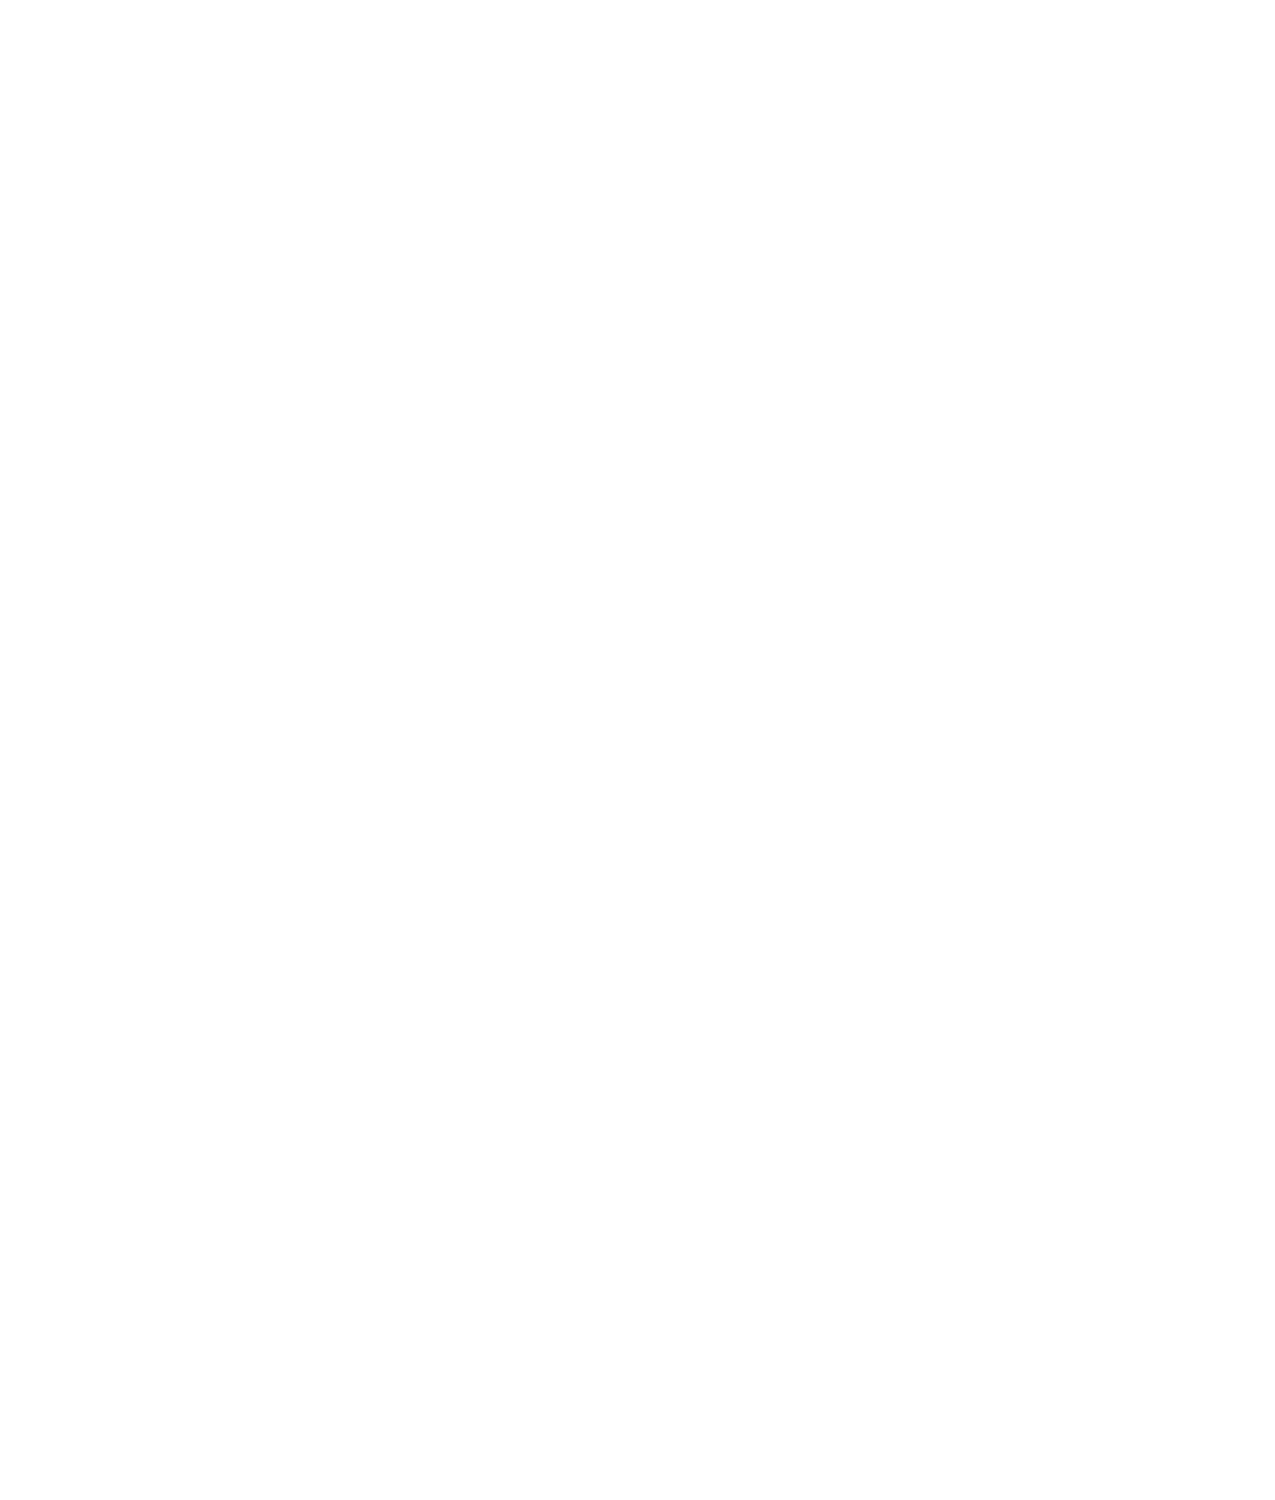

0
0
0
0


/tmp/ipykernel_32340/446067921.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.xdr_arr['param'] !=0:


2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


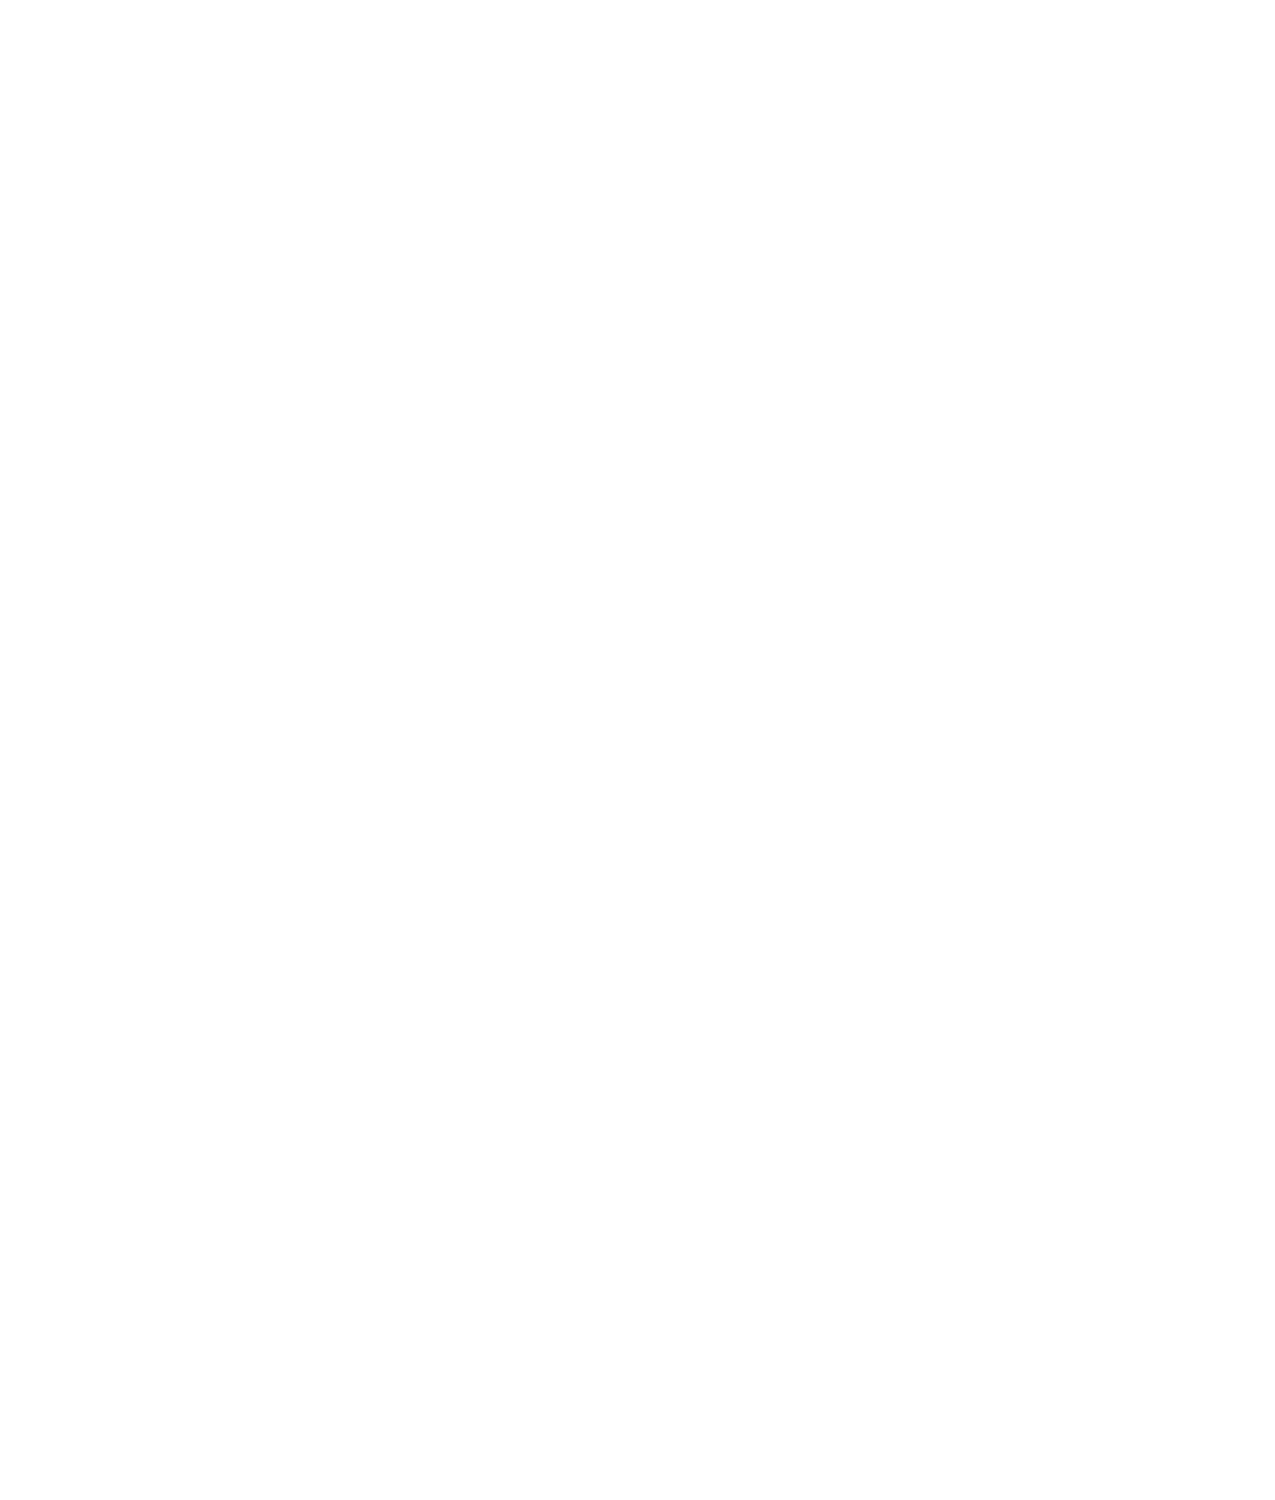

2
1
2
1
0
0
0
0
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


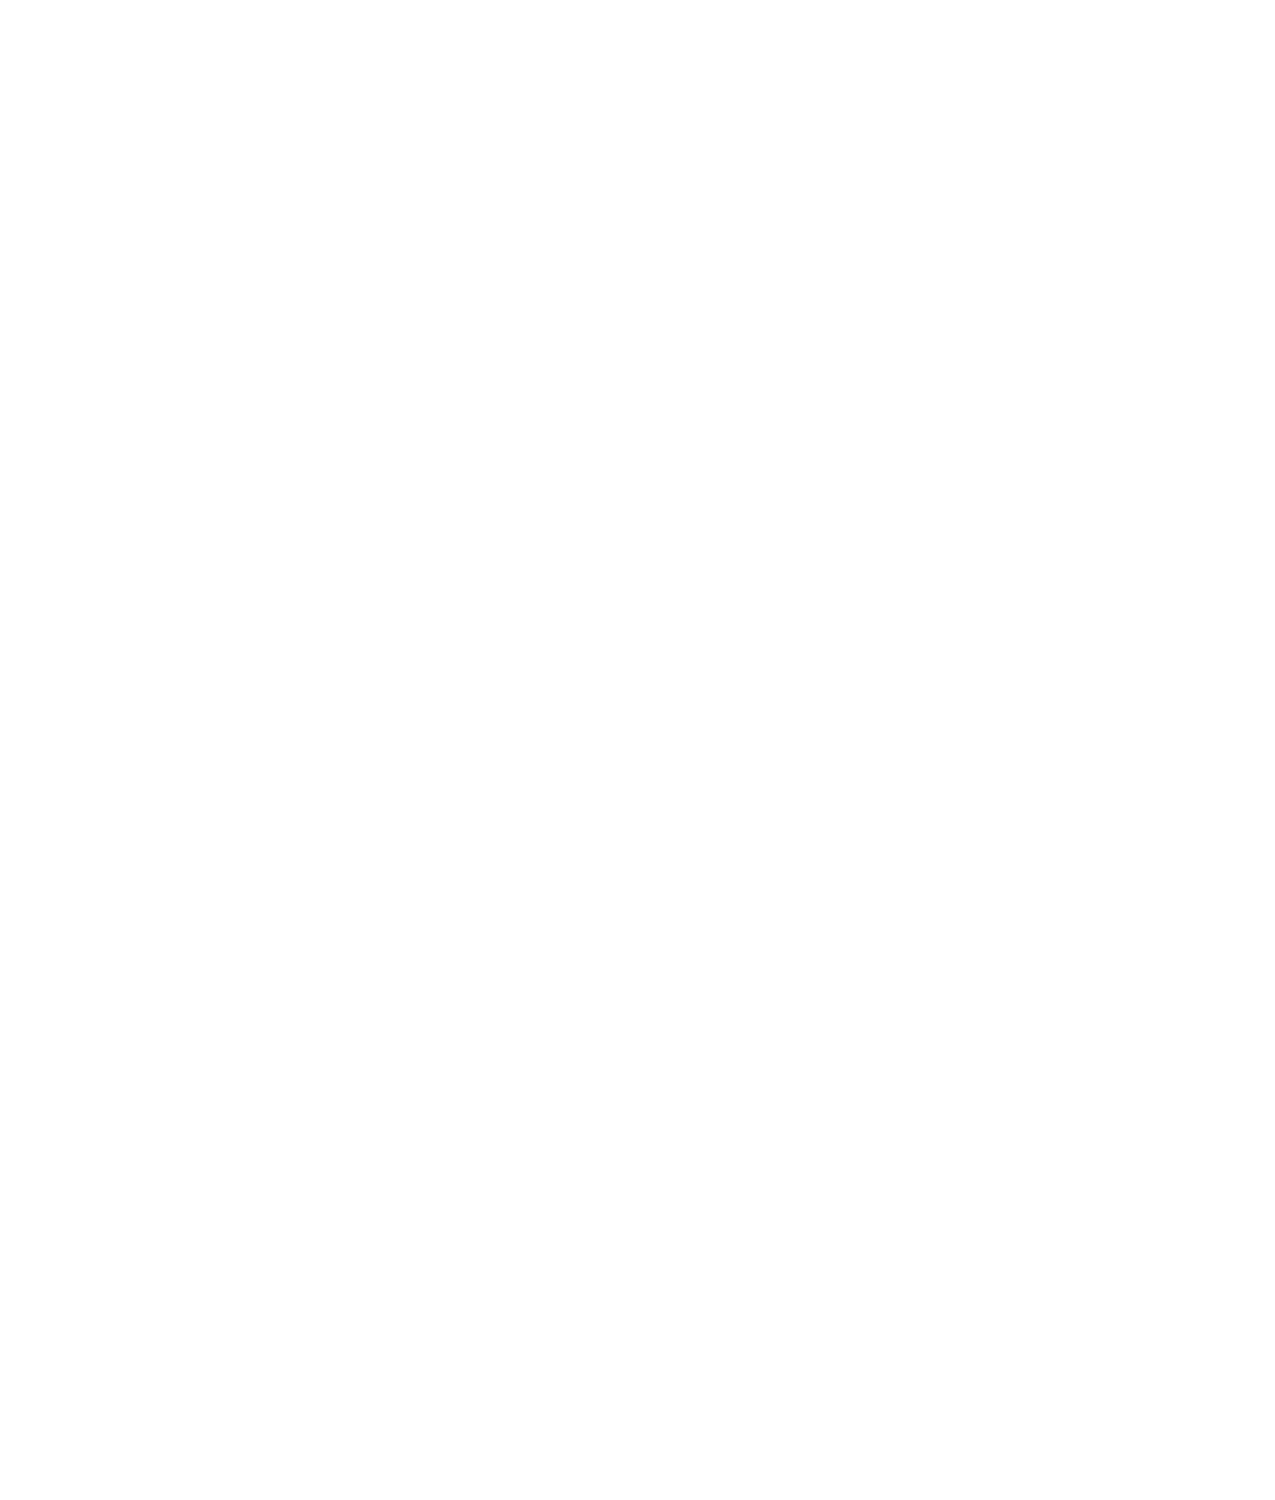

2
1
2
1
0
0
0
0
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


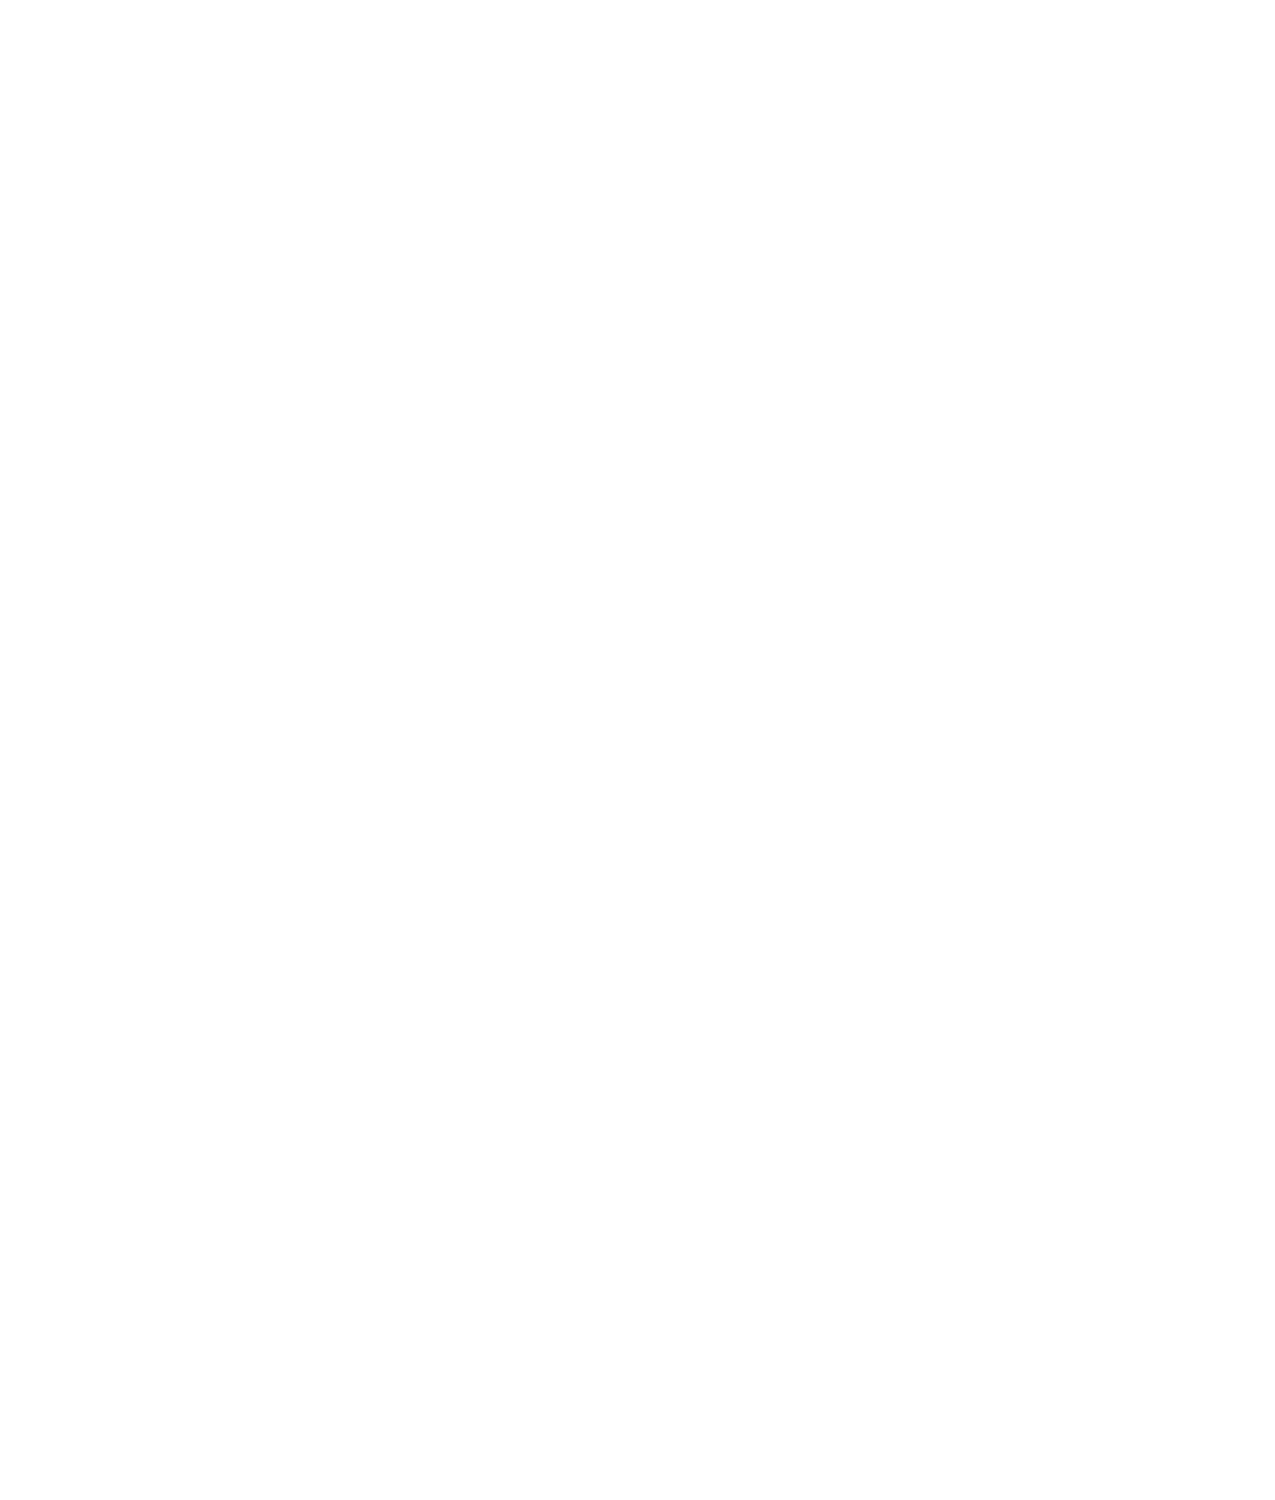

2
1
2
1
0
1
0
1
2
1
2
1
0
1
0
1


<IPython.core.display.Javascript object>


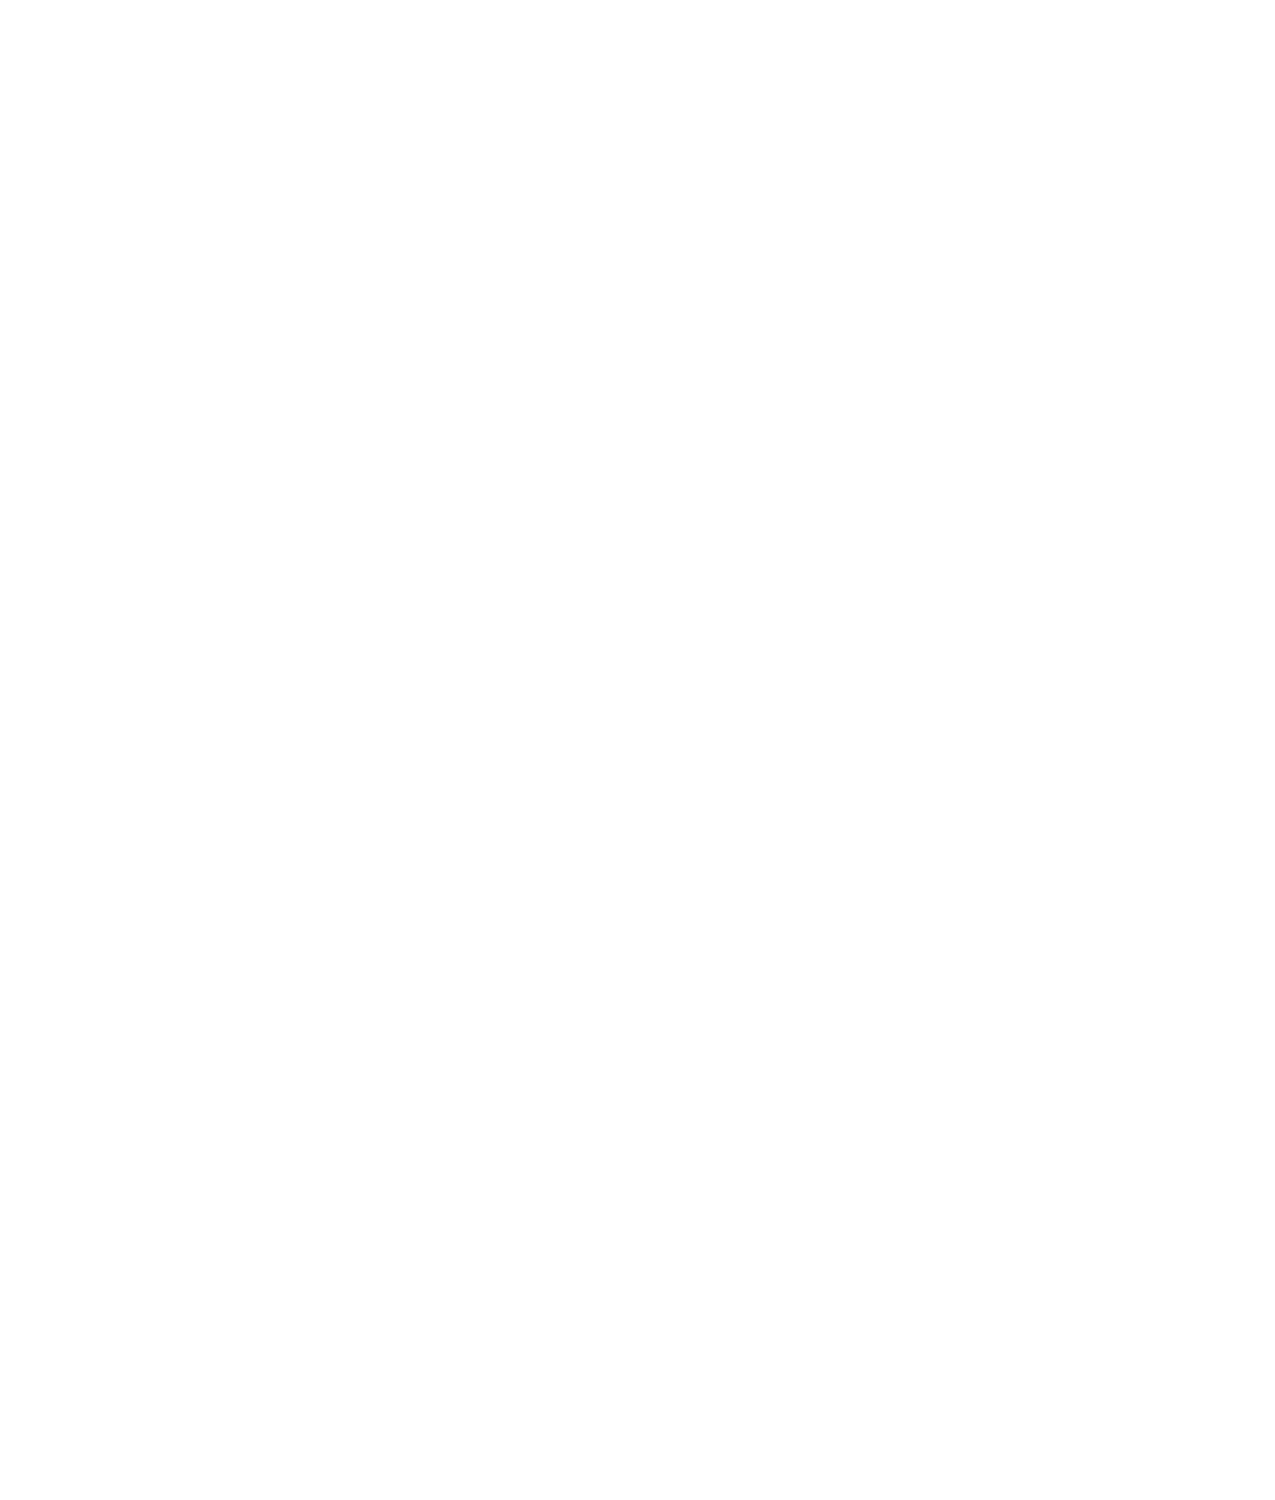

0
0
0
0
2
1
2
1
0
0
0
0
2
1
2
1


<IPython.core.display.Javascript object>


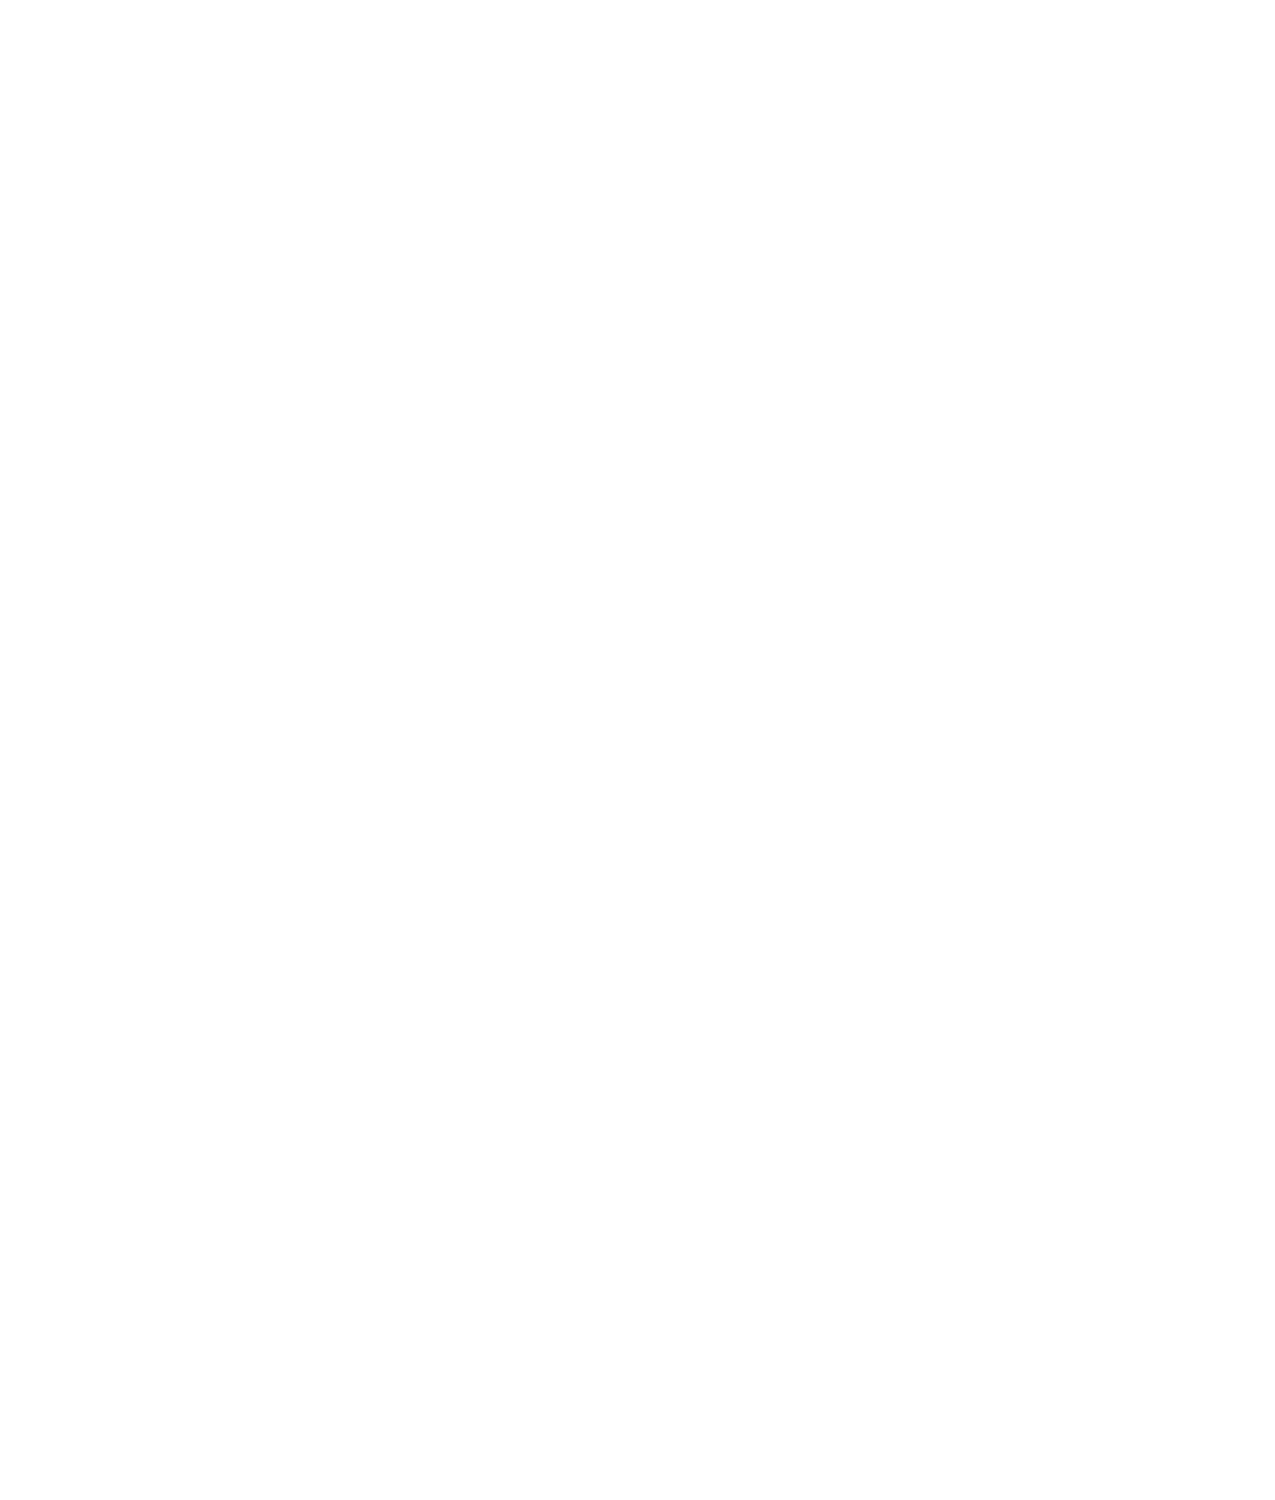

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


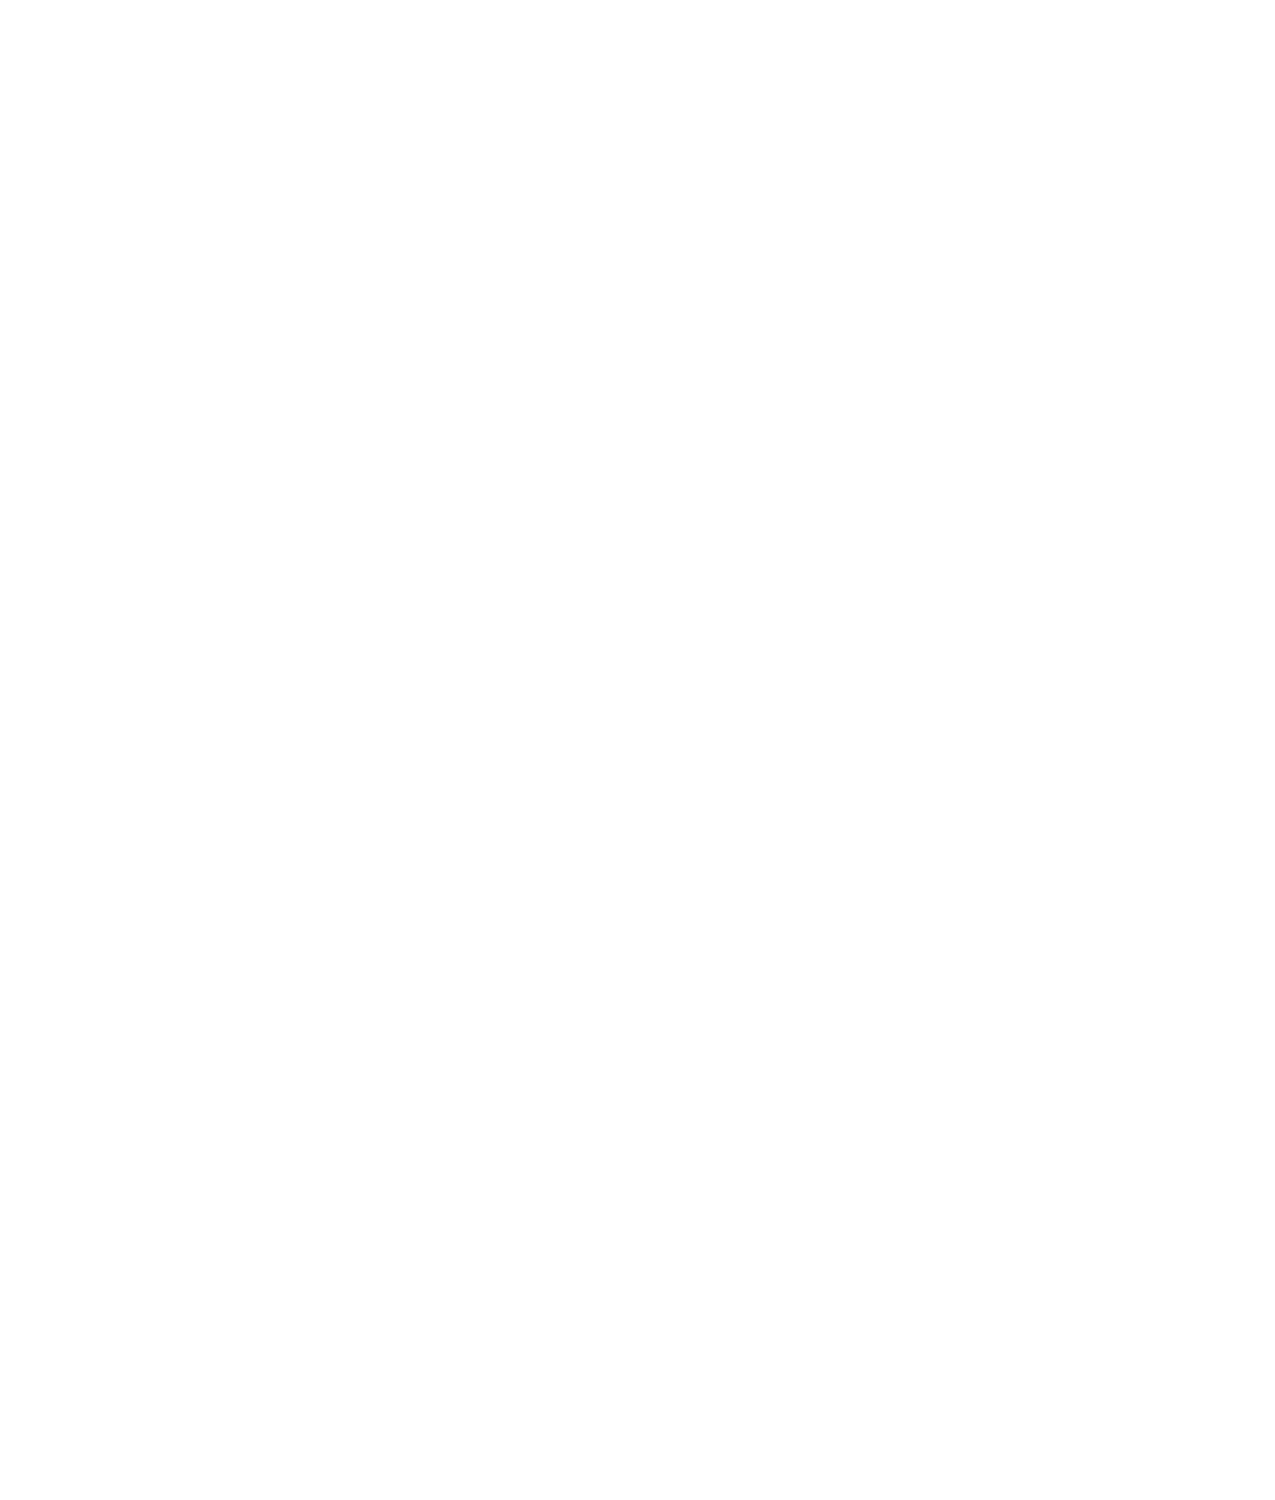

2
1
2
1
2
1
2
1
2
0
2
0
2
1
2
1


<IPython.core.display.Javascript object>


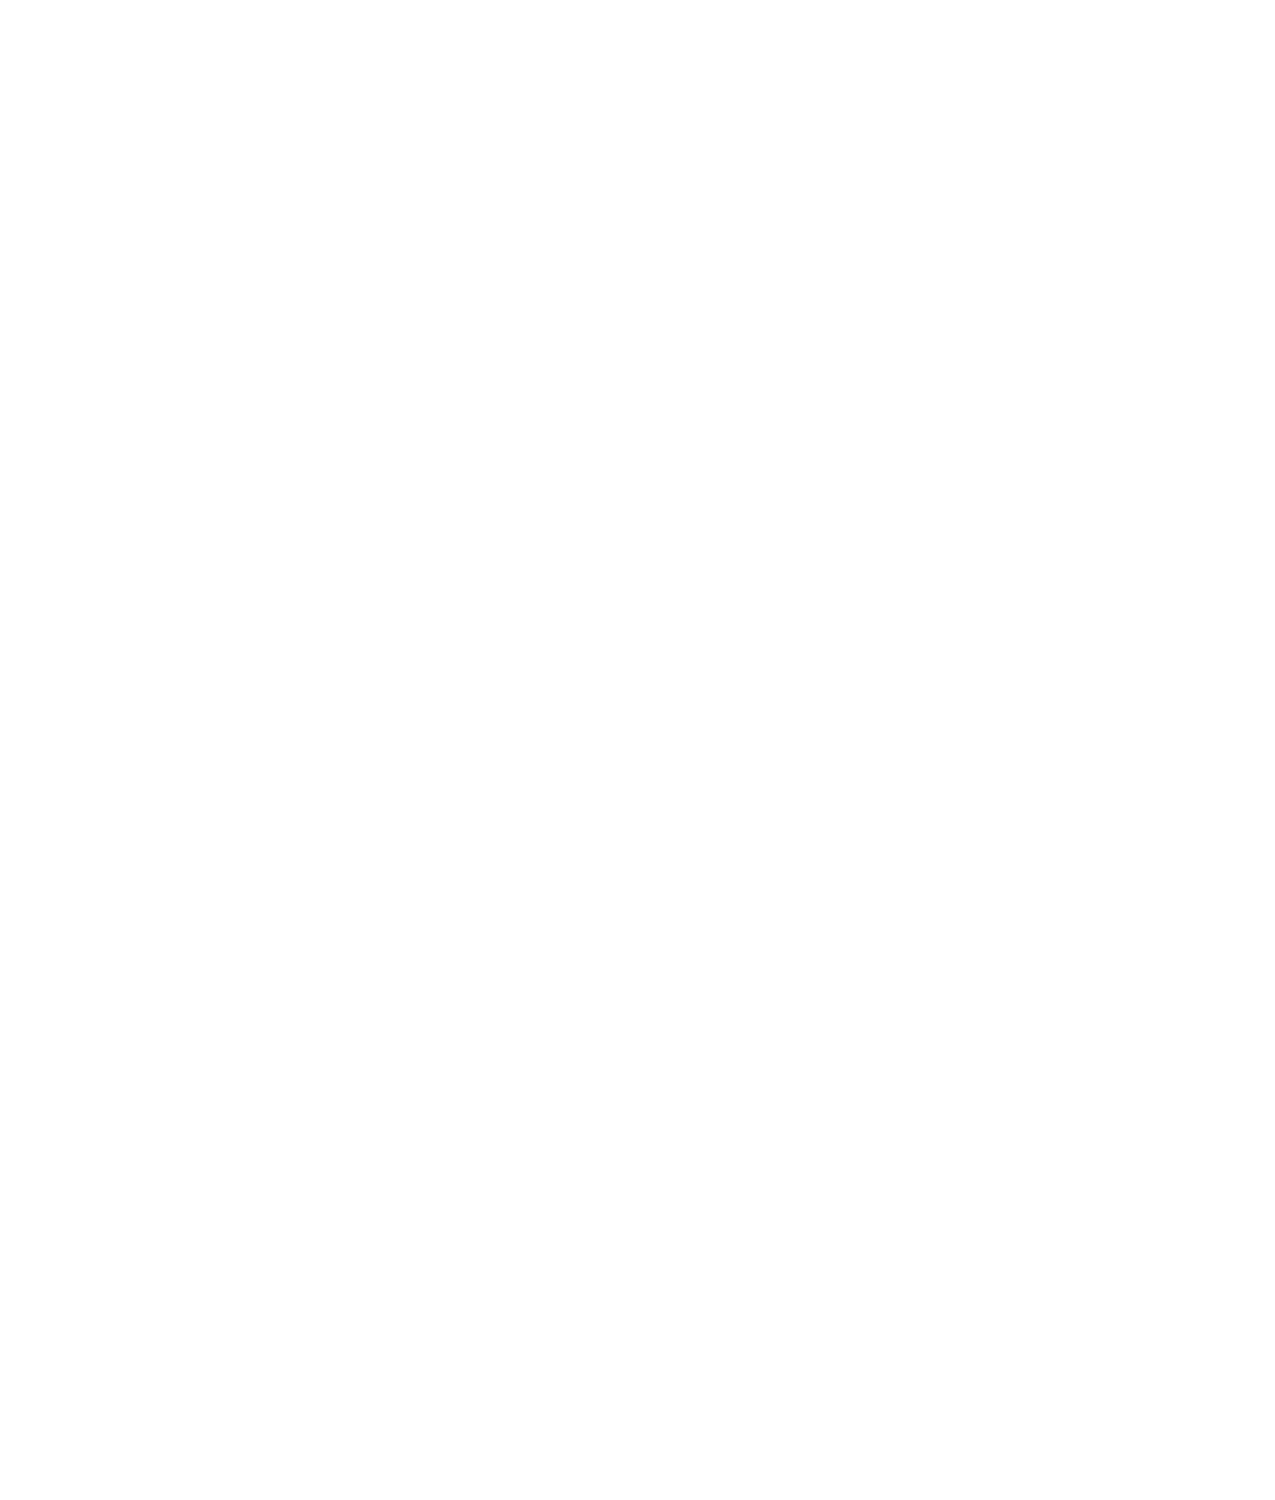

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


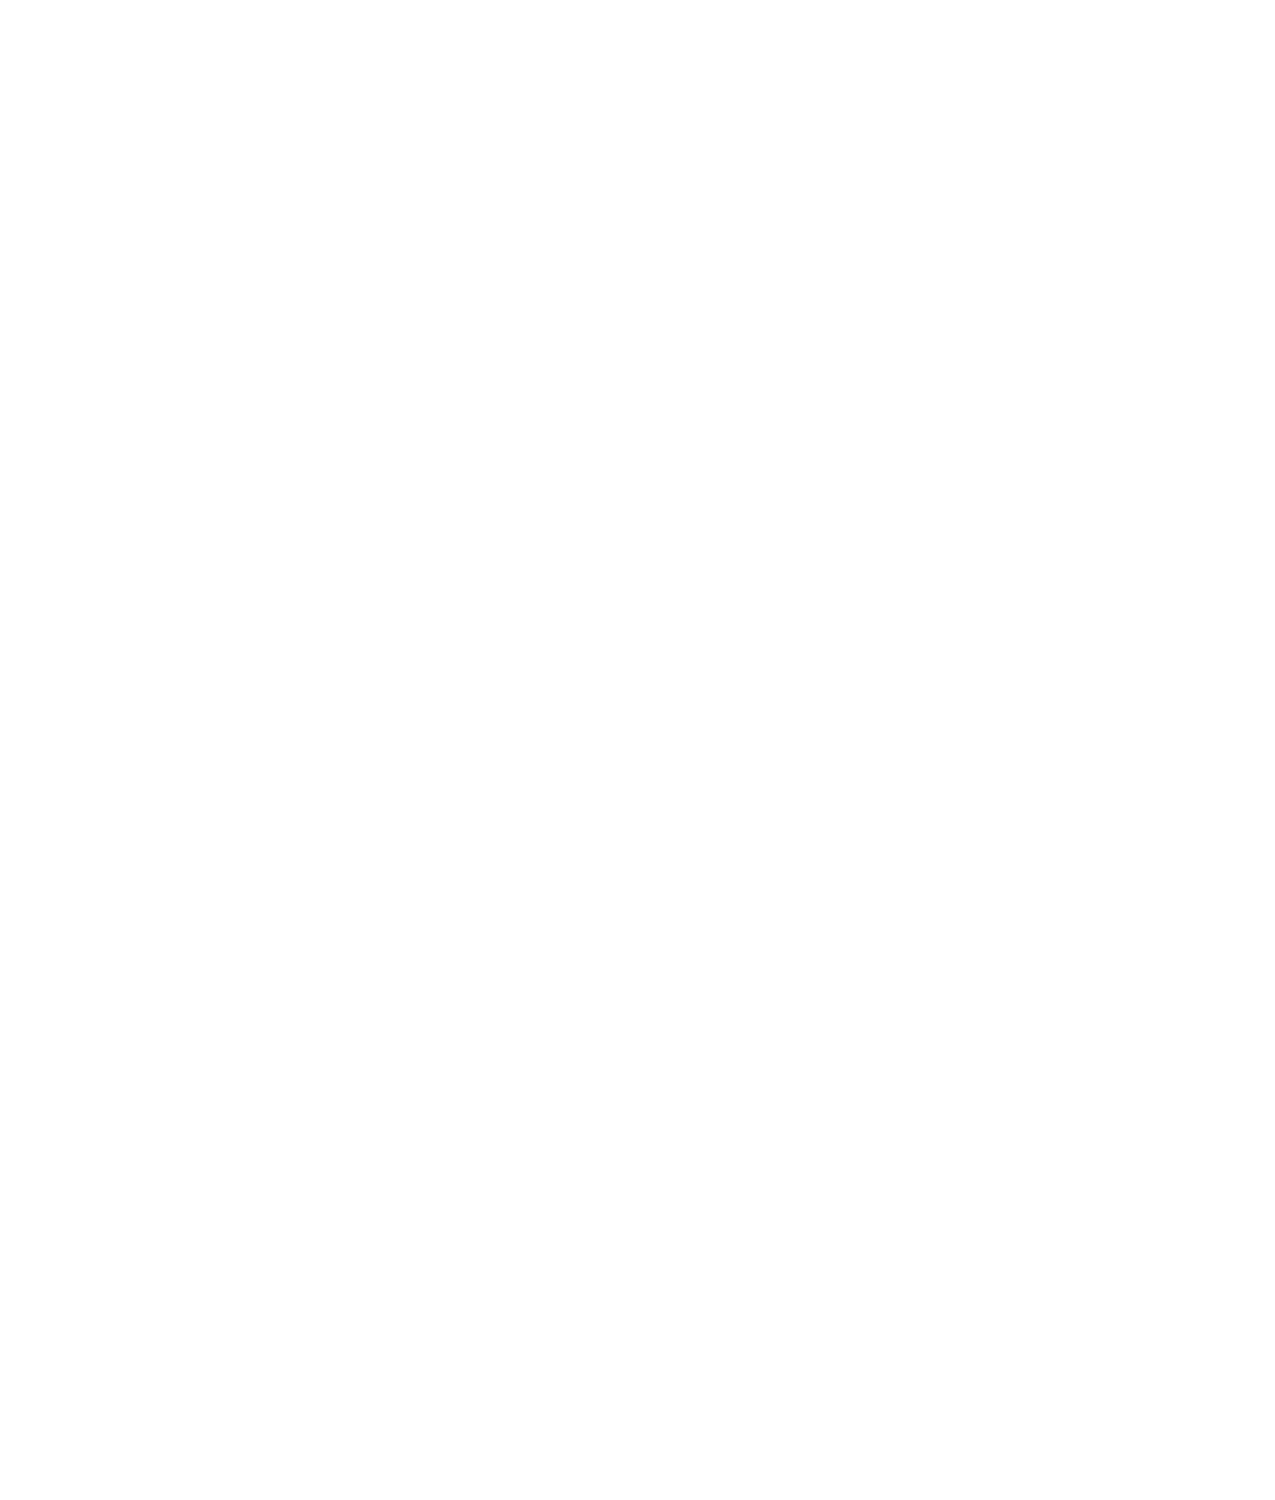

2
1
2
1
2
1
2
1
0
1
0
1
0
1
0
1


<IPython.core.display.Javascript object>


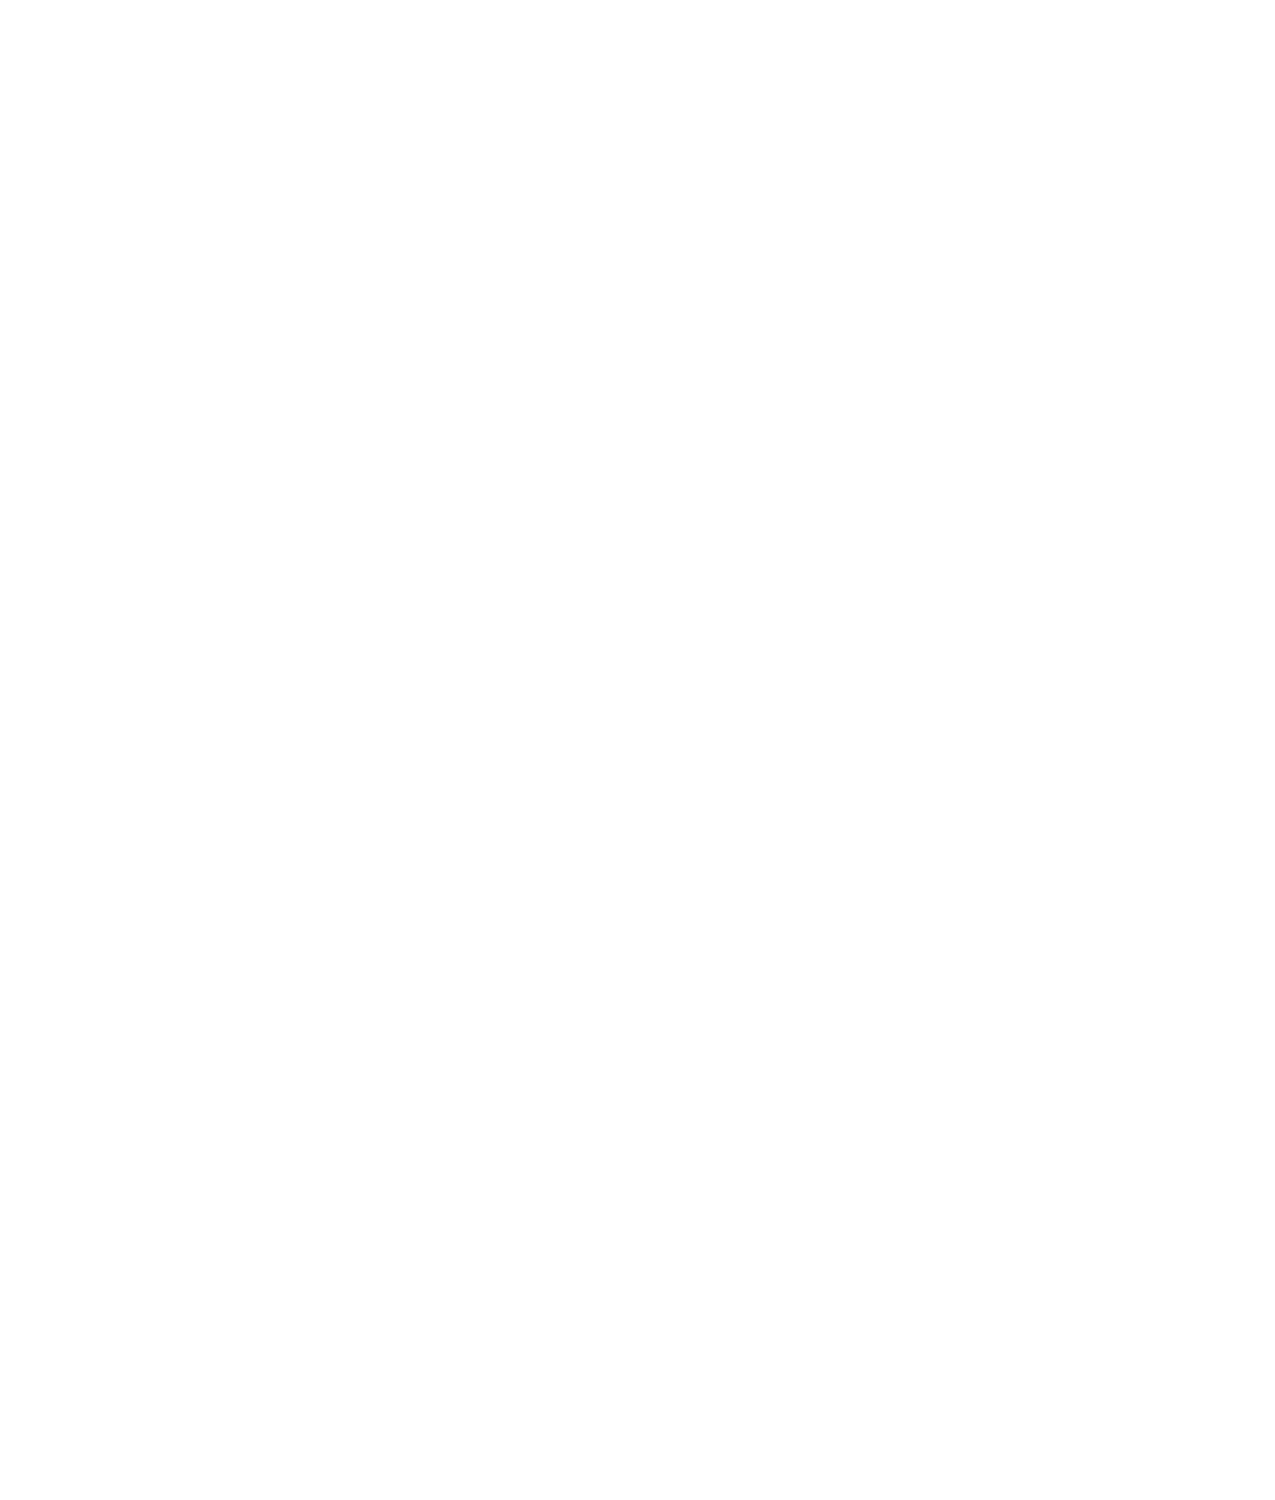

2
0
2
0
2
1
2
1
0
1
0
1
2
1
2
1


<IPython.core.display.Javascript object>


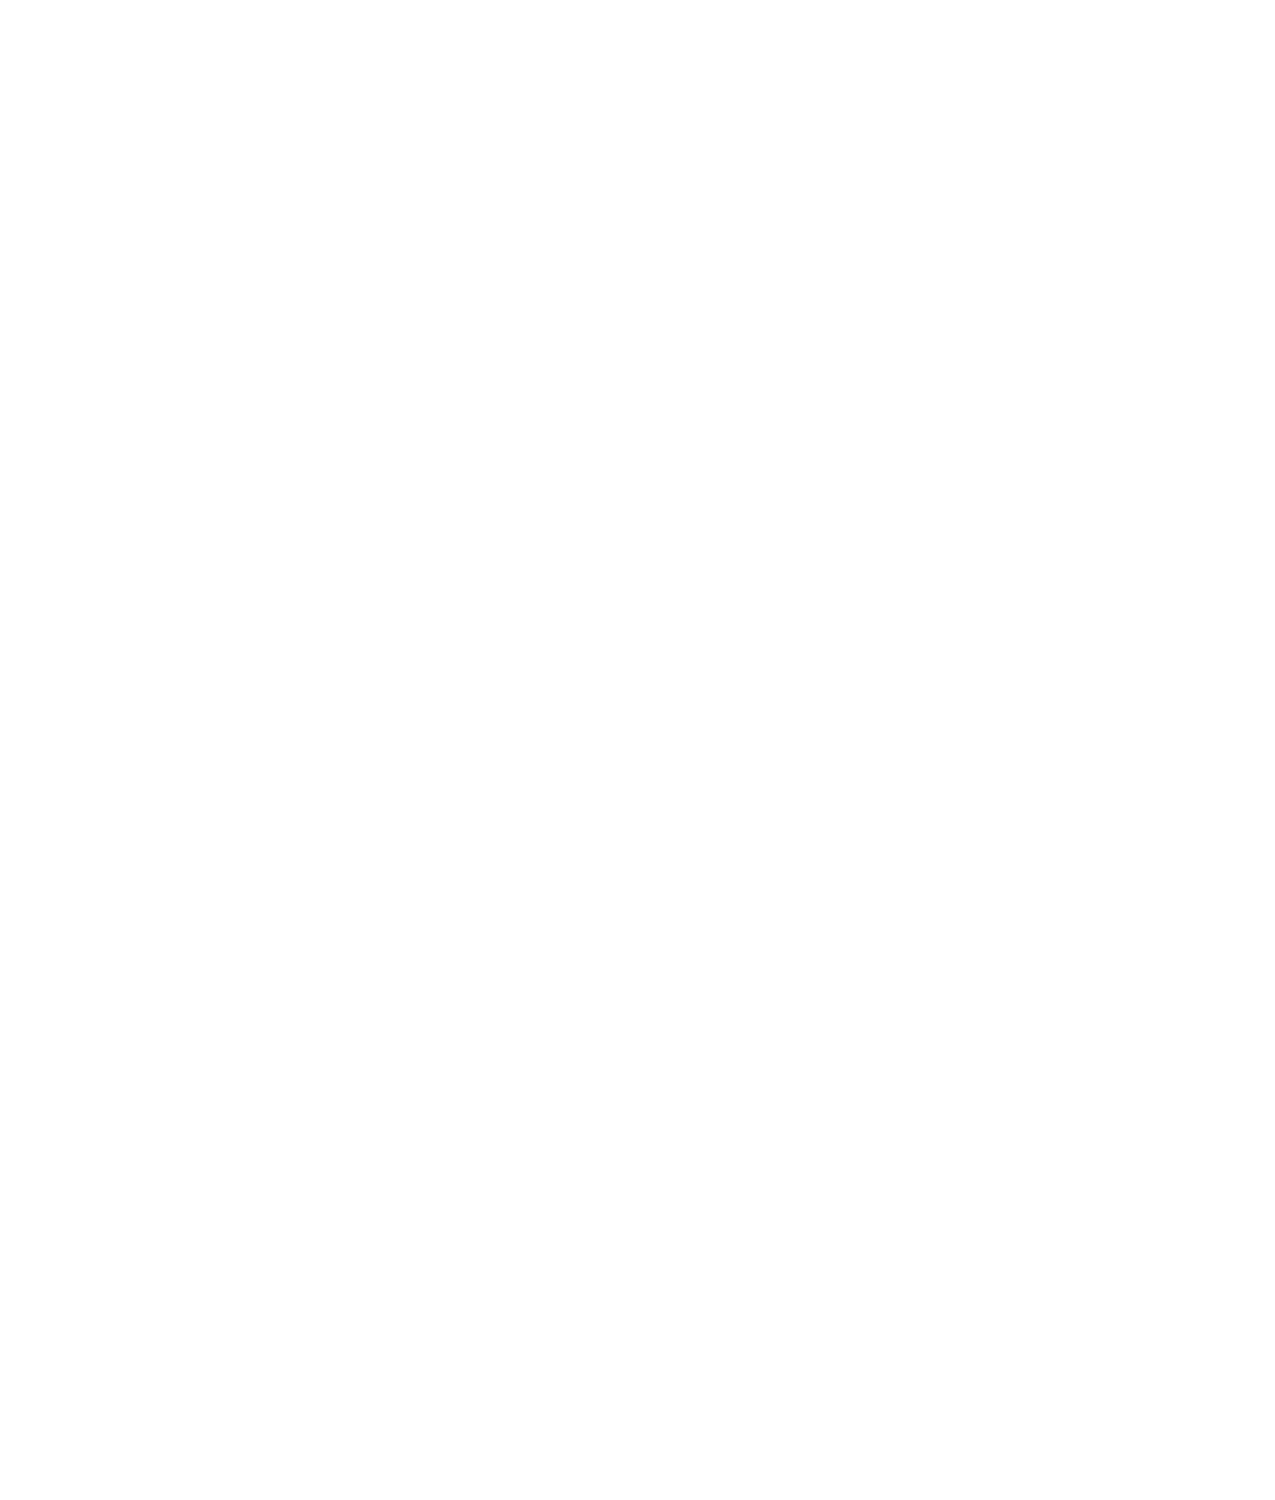

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


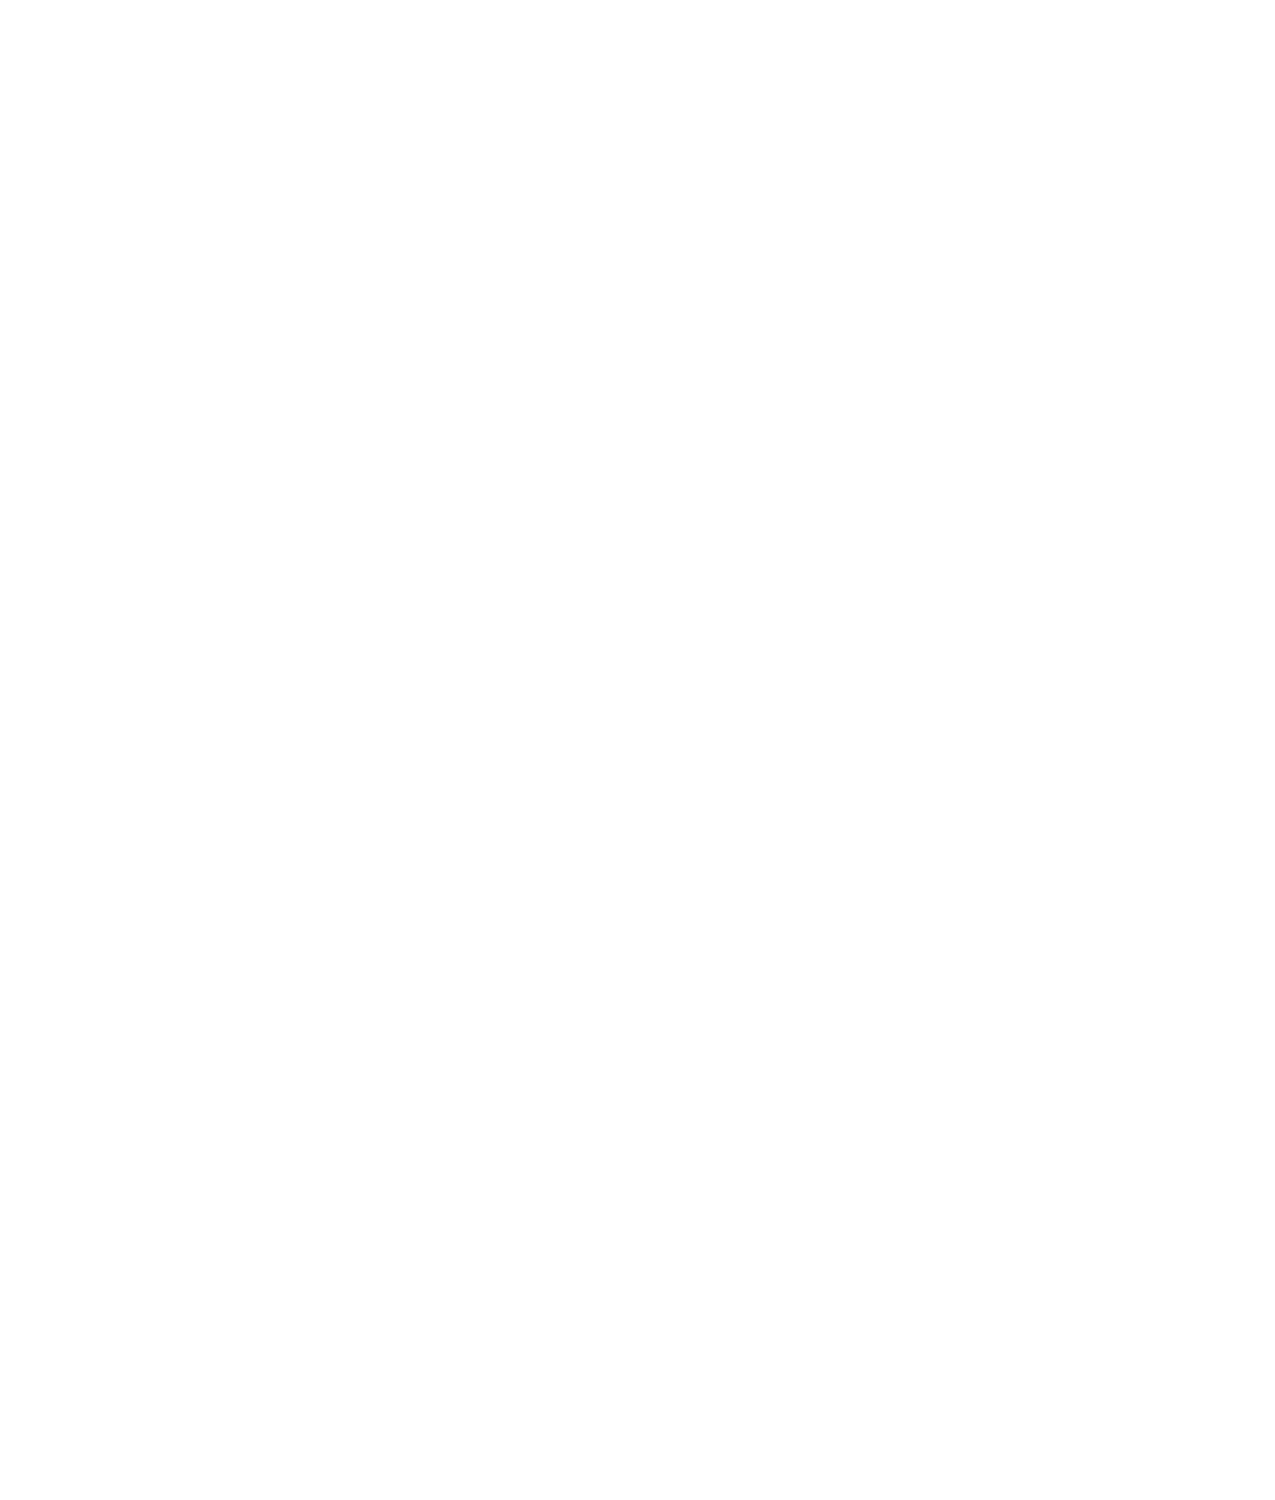

2
1
2
1
2
1
2
1
0
0
0
0
2
1
2
1


<IPython.core.display.Javascript object>


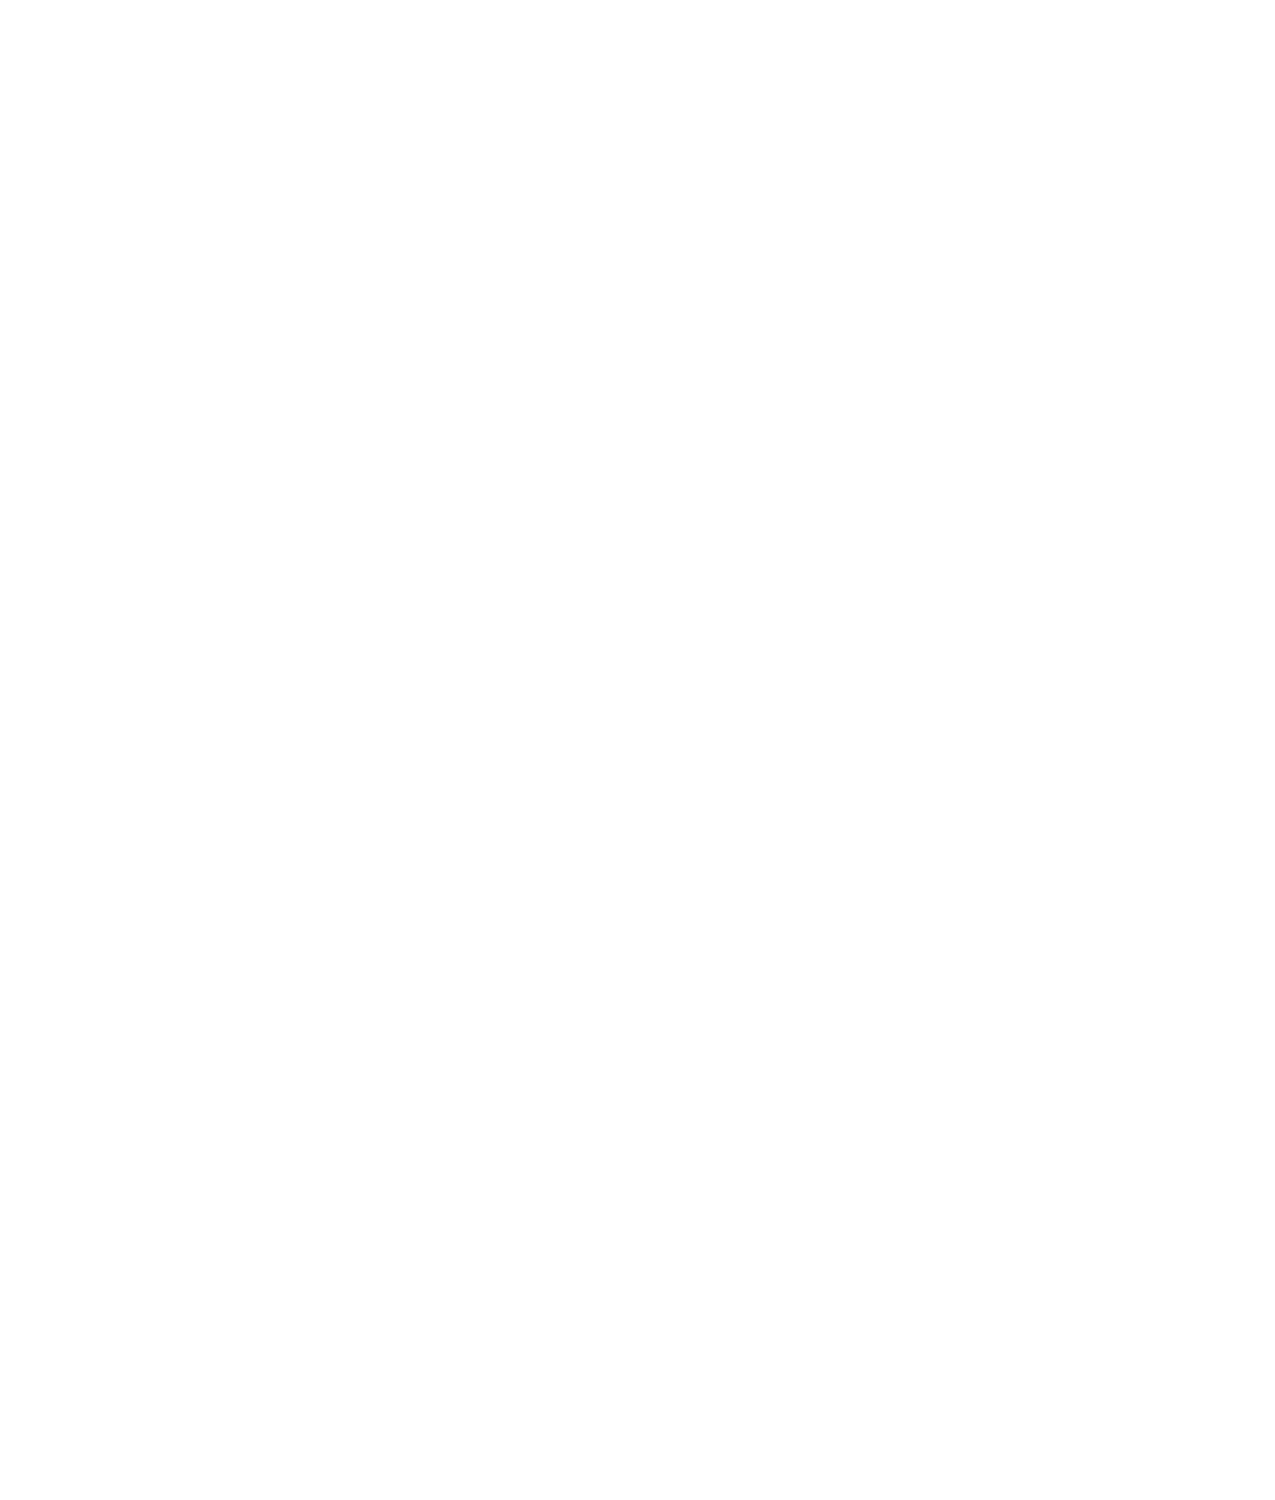

2
0
2
0
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


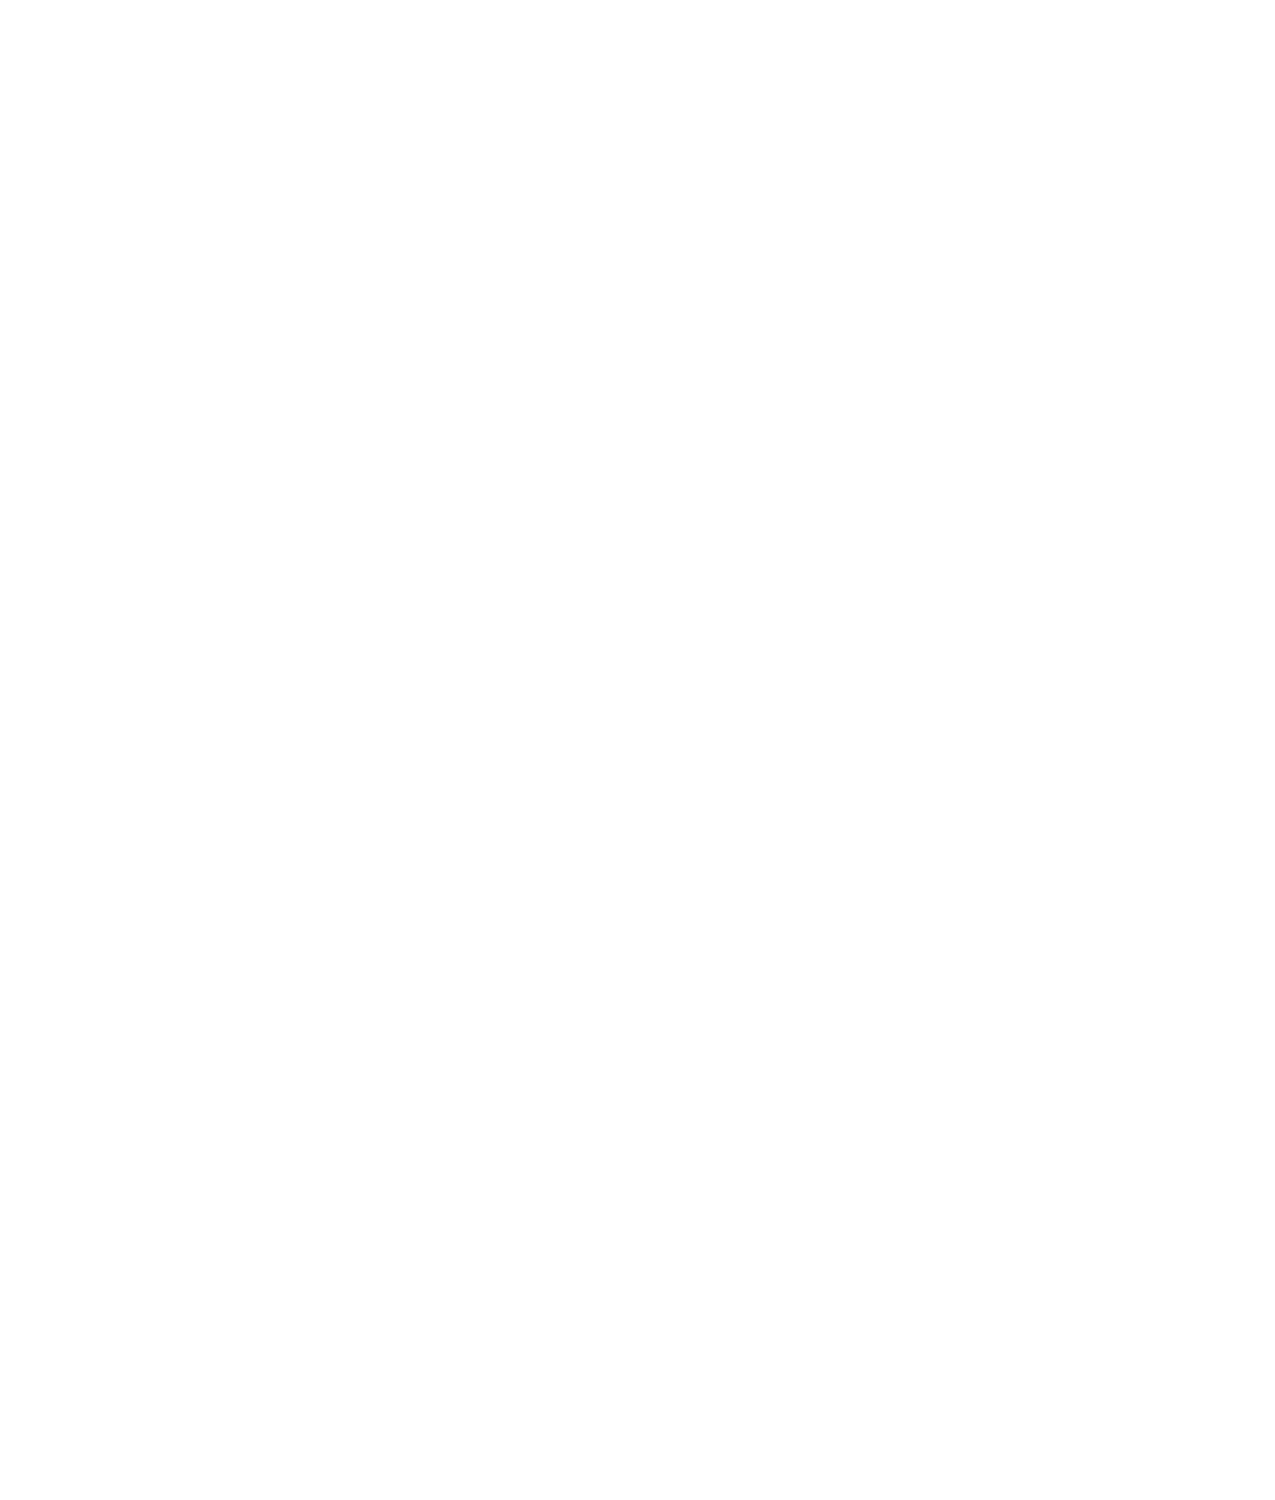

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


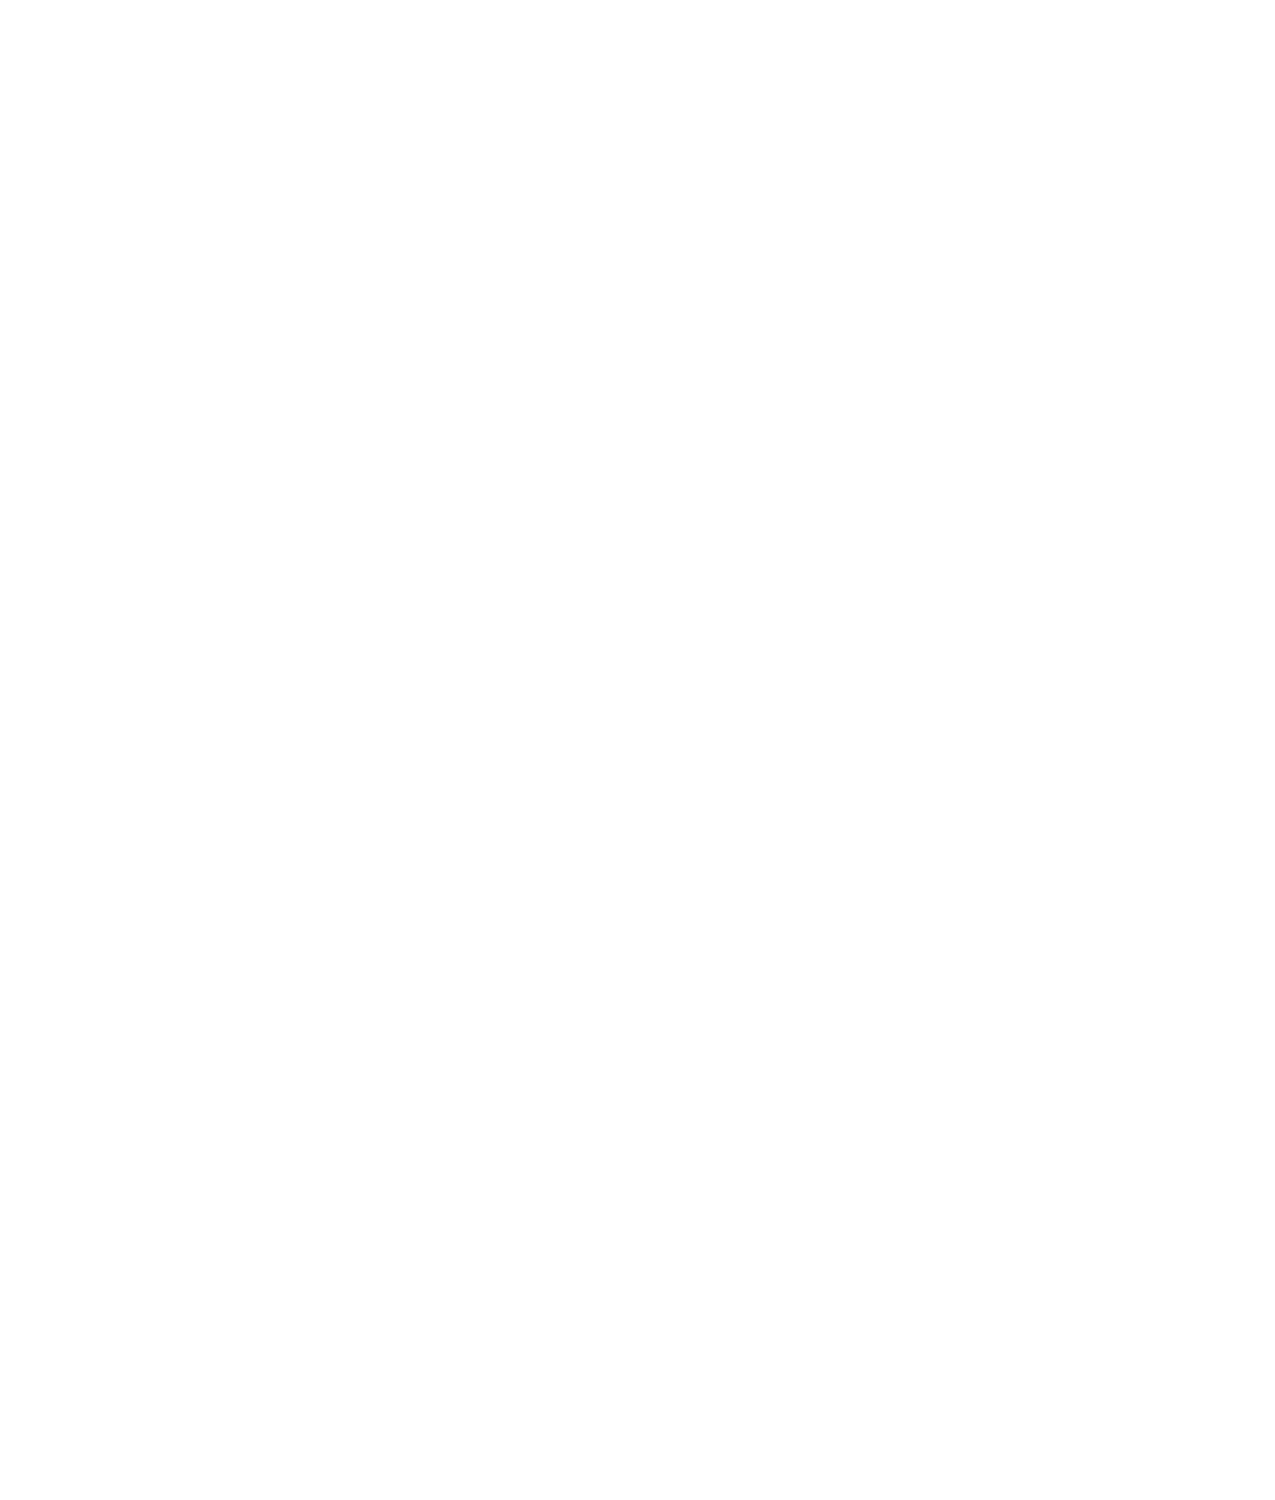

0
0
0
0
2
1
2
1
2
0
2
0
0
1
0
1


<IPython.core.display.Javascript object>


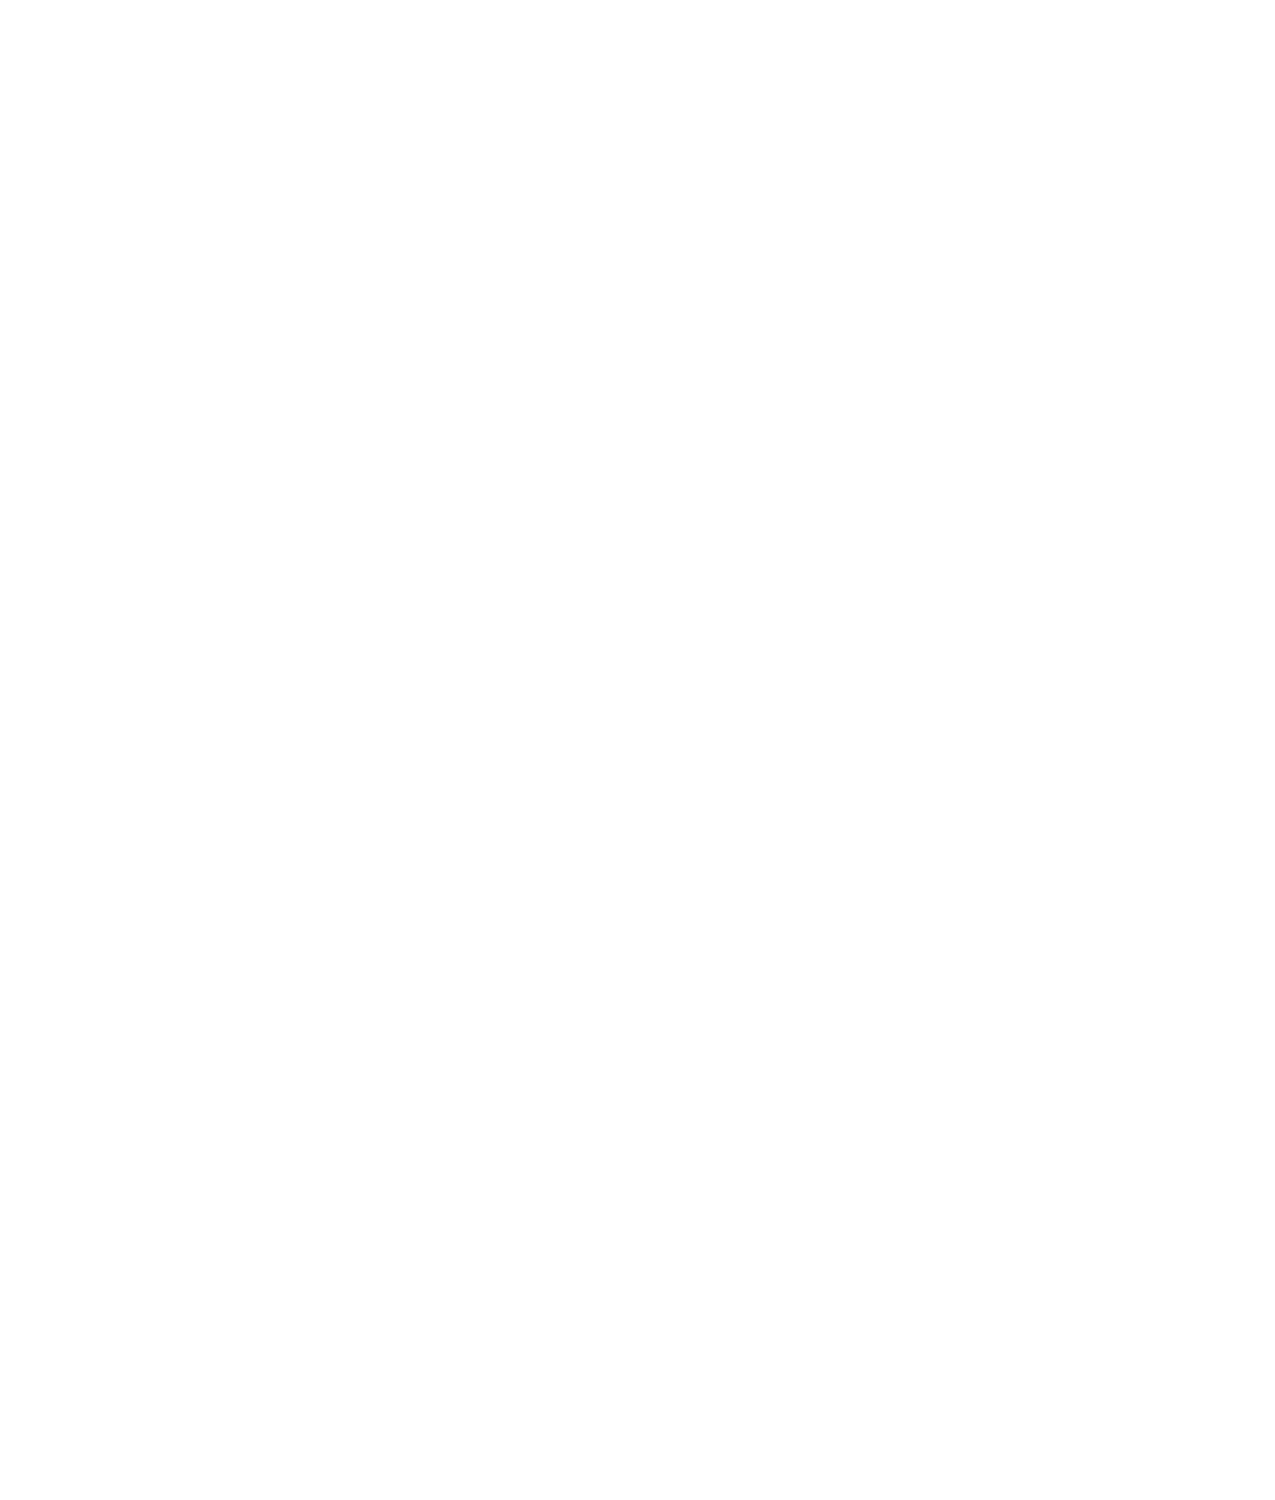

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


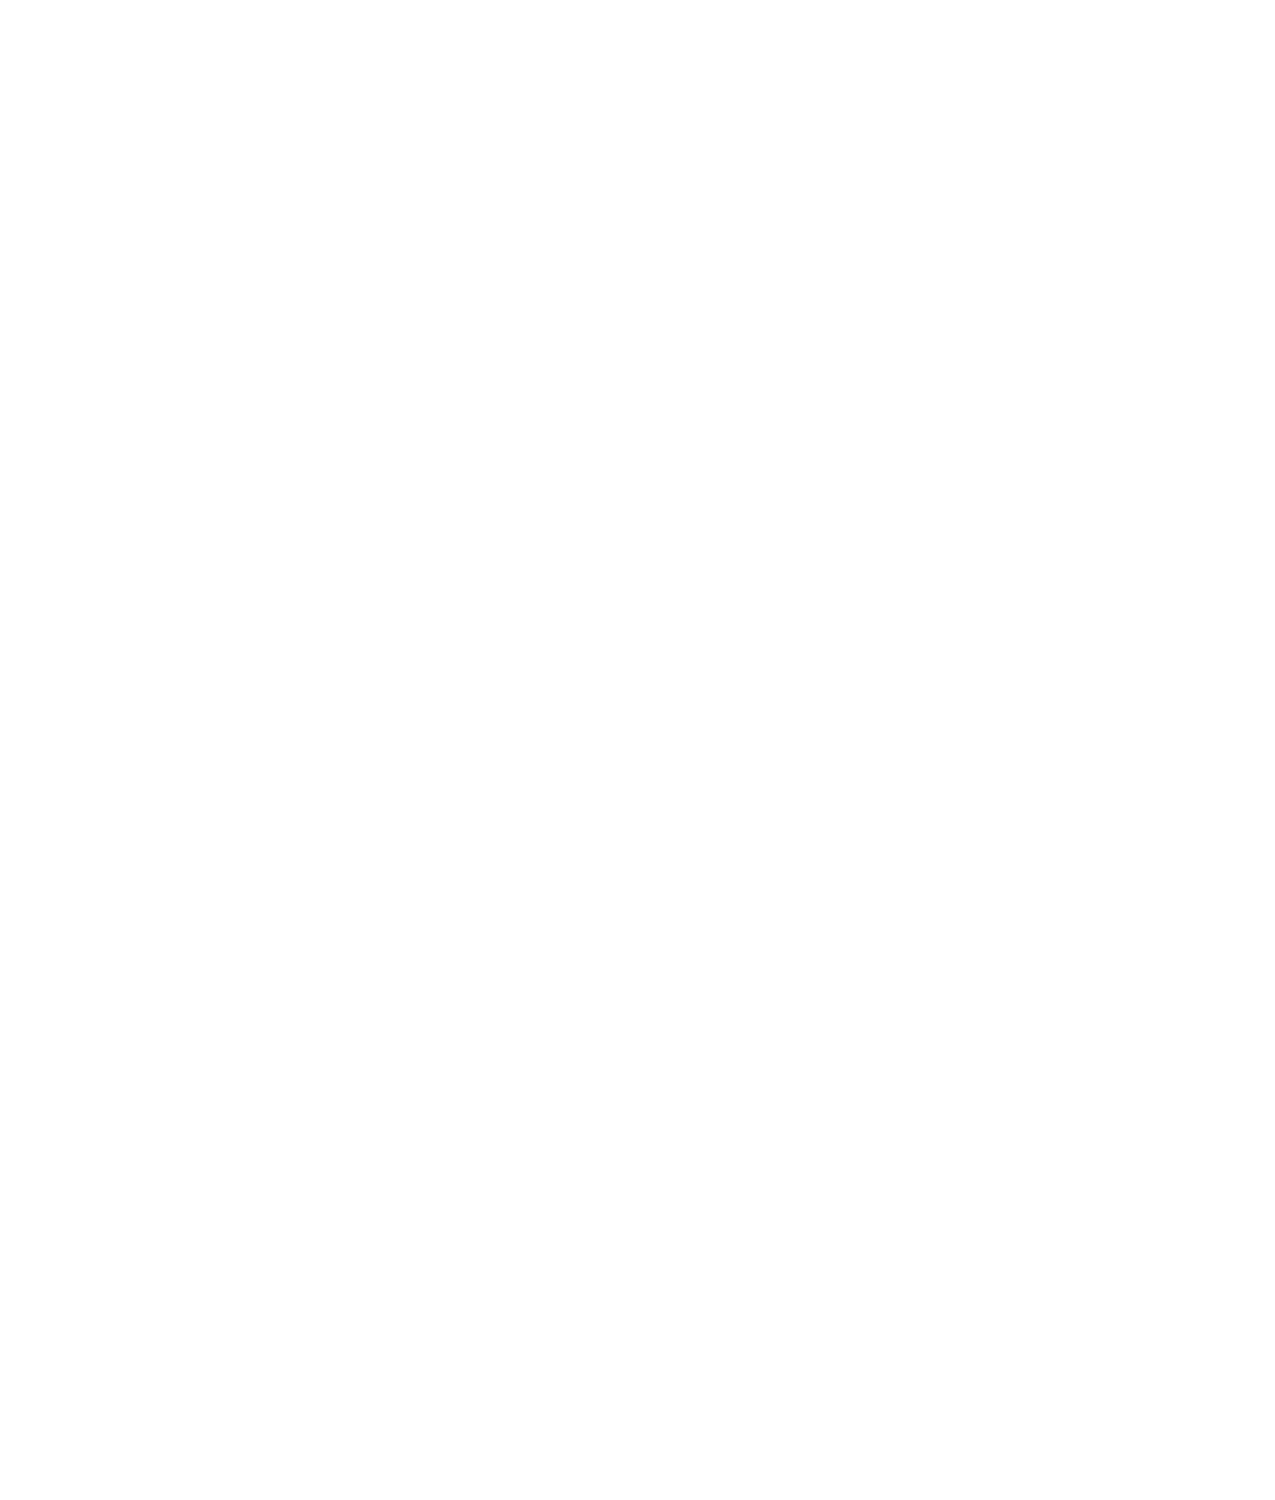

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


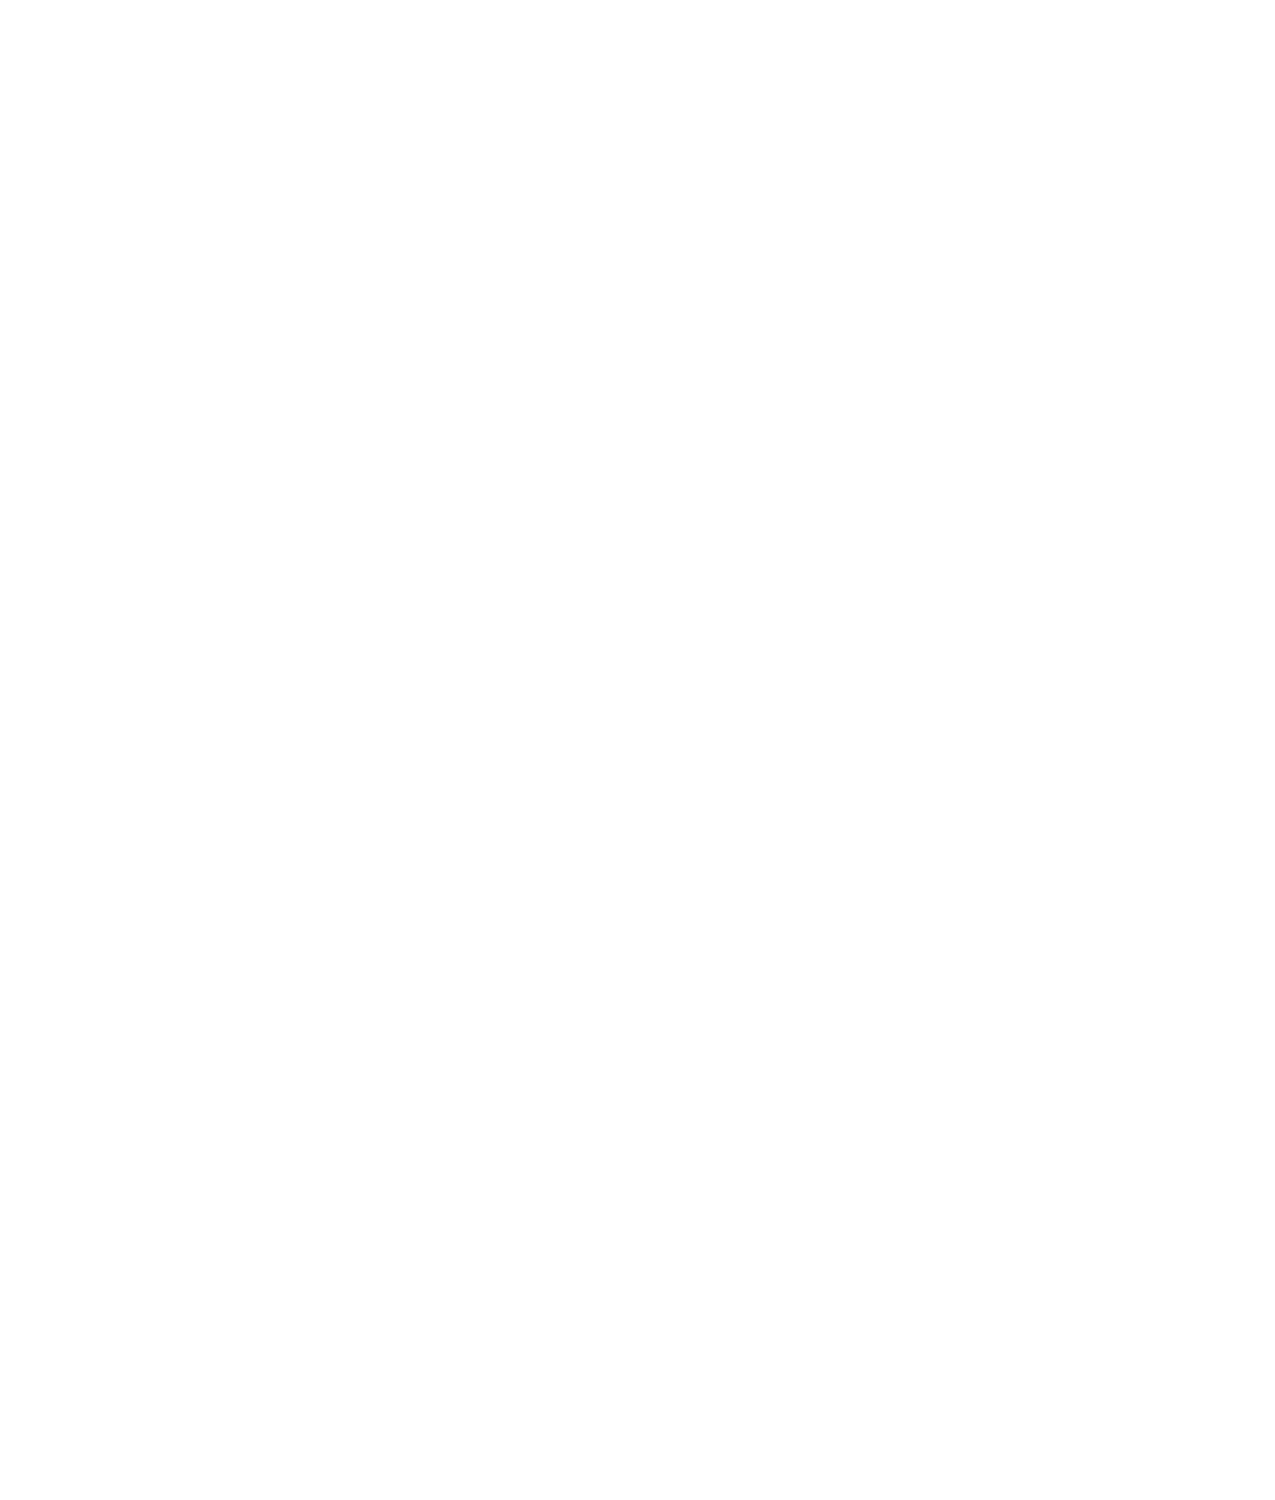

0
1
0
1
0
1
0
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


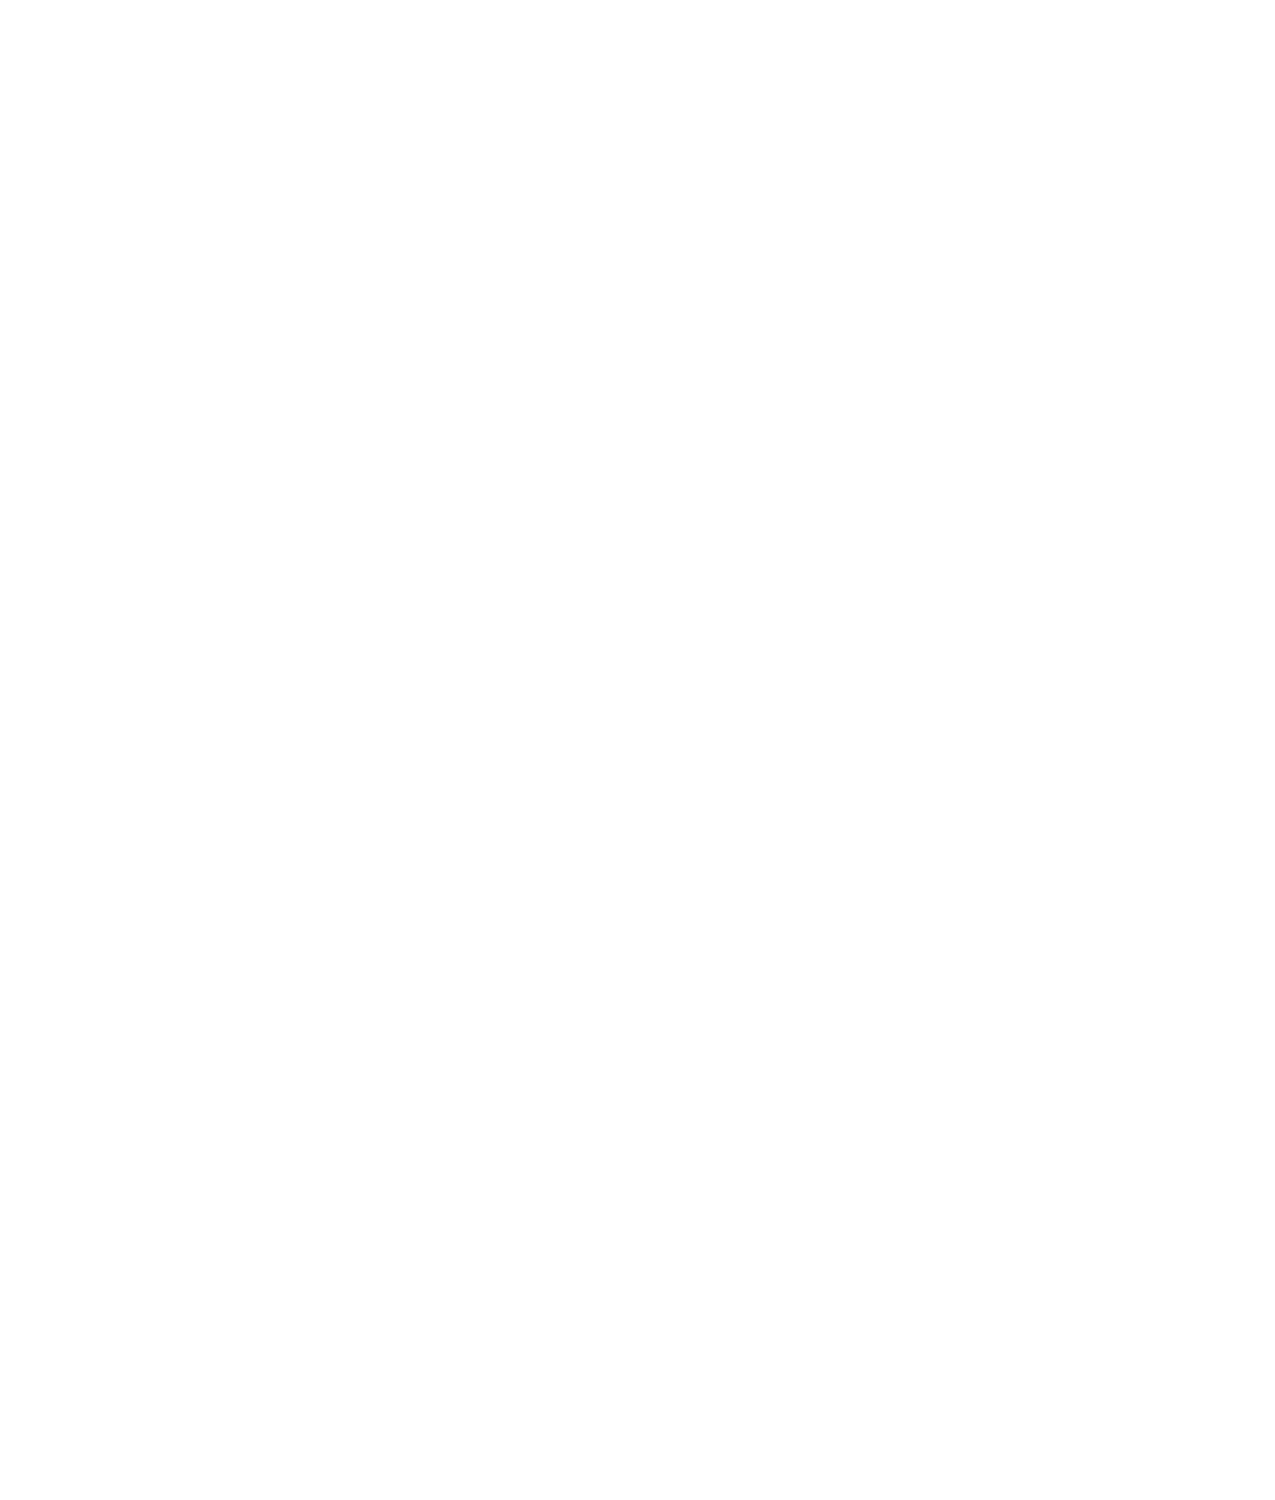

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


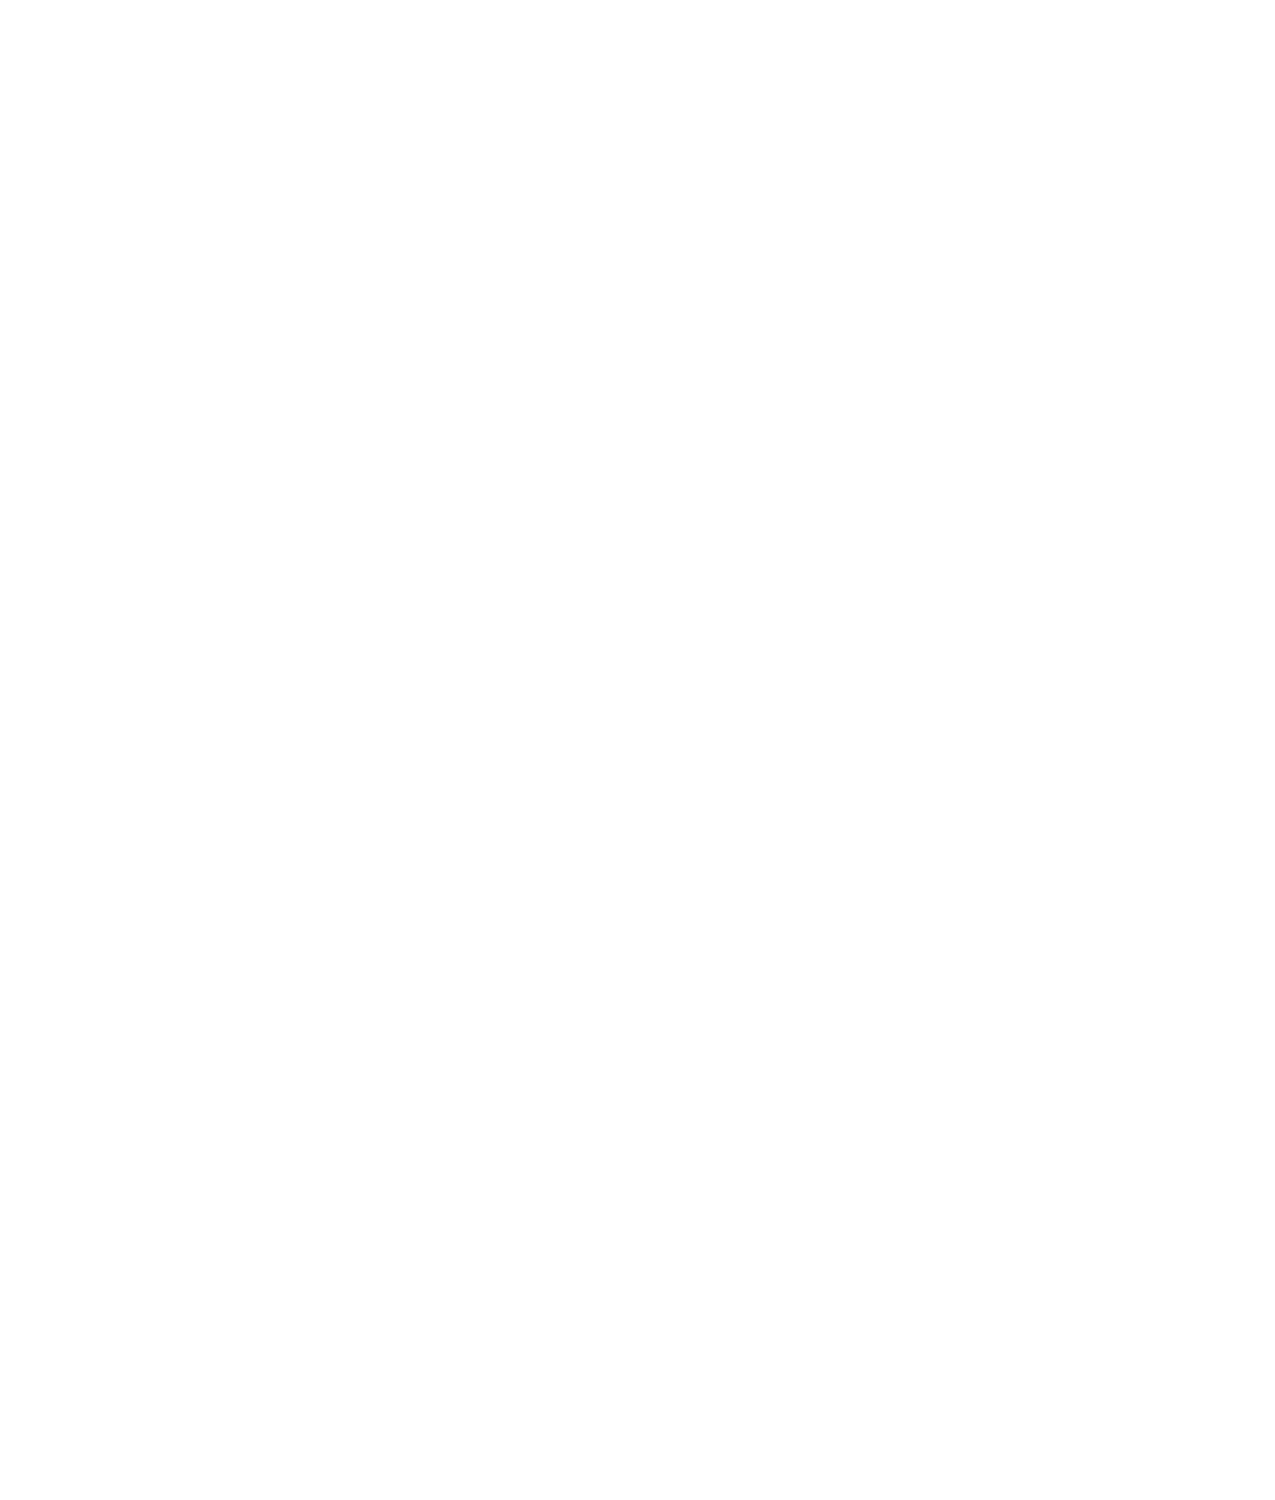

2
1
2
1
2
1
2
1
2
0
2
0
2
1
2
1


<IPython.core.display.Javascript object>


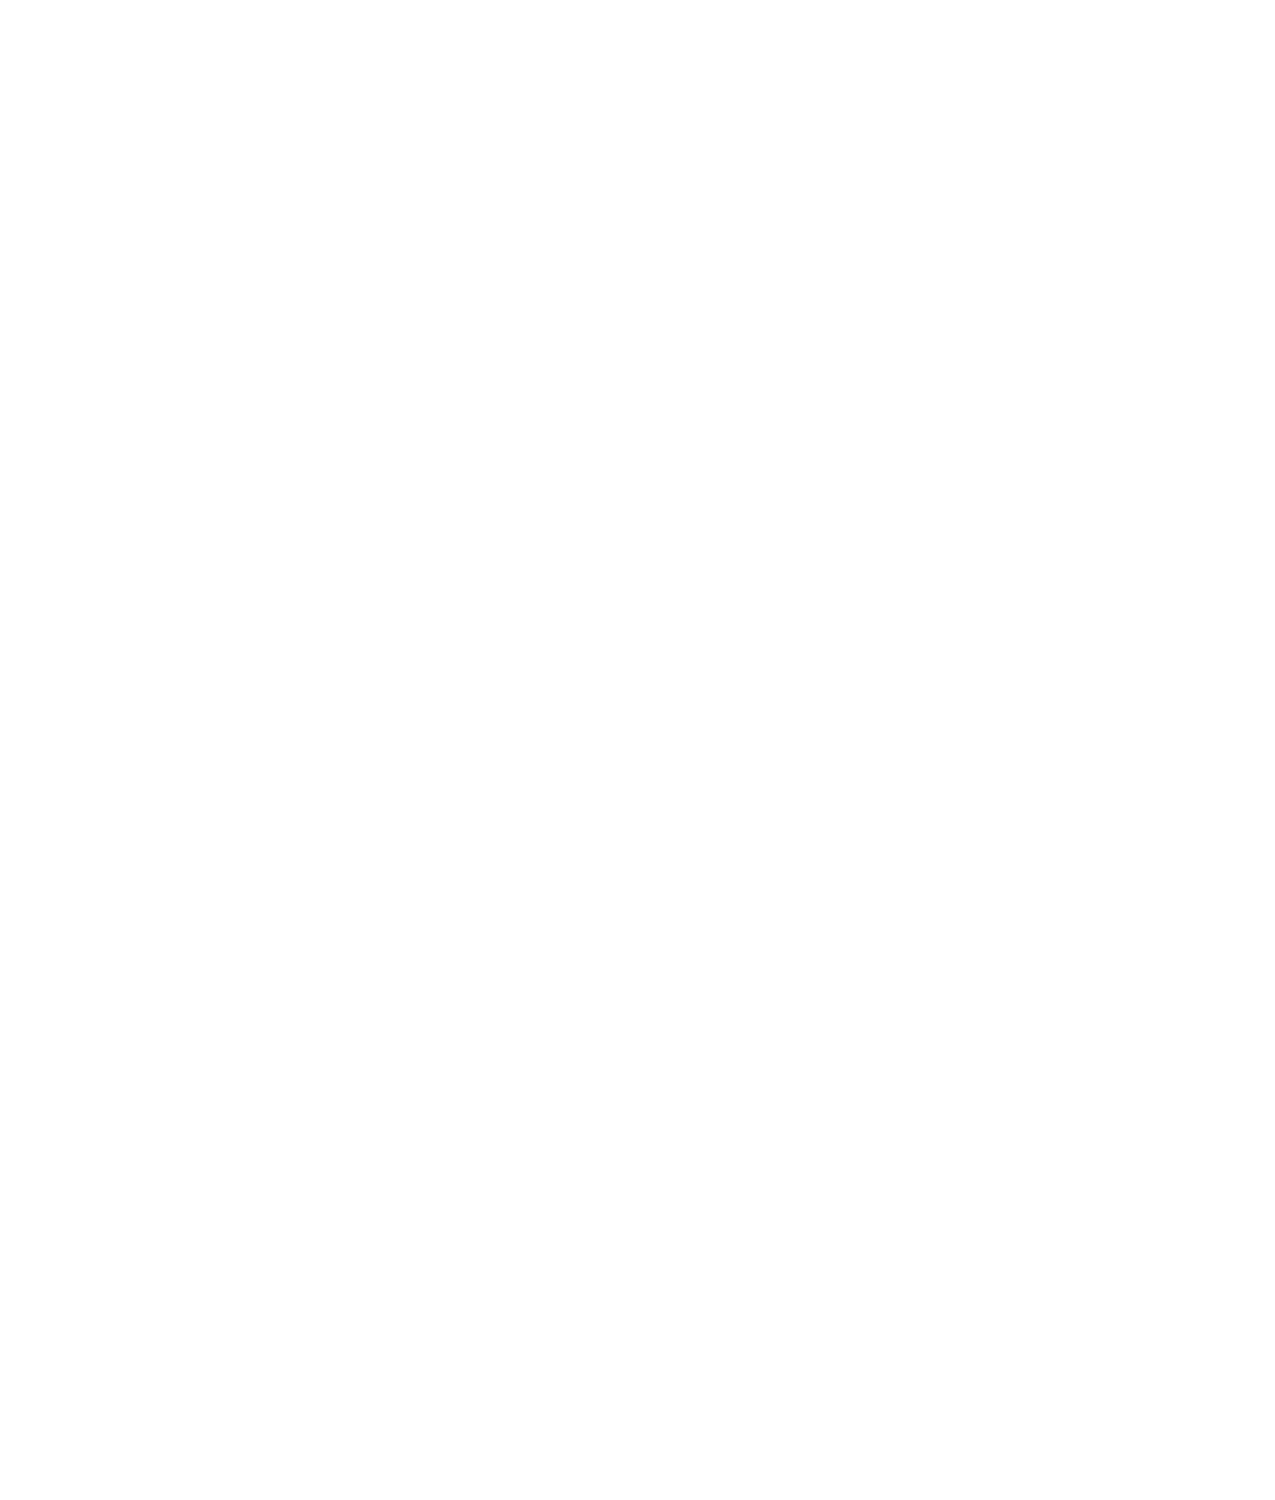

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


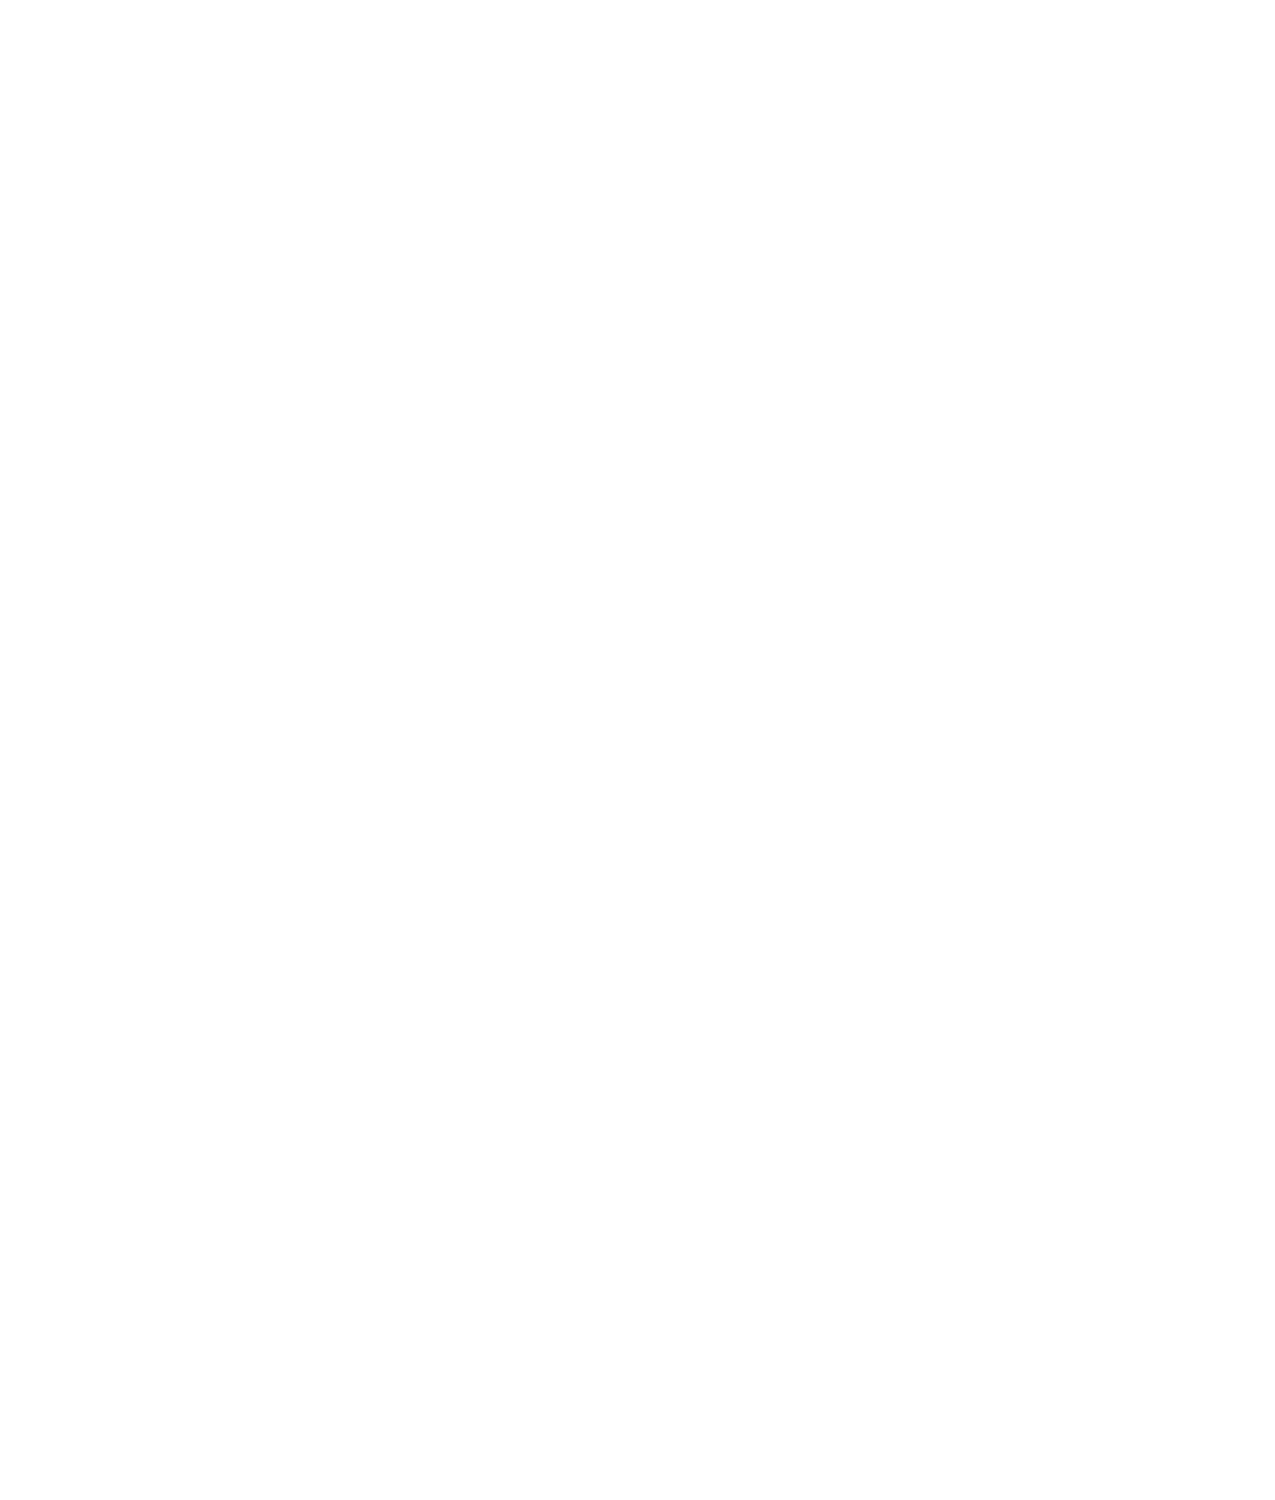

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


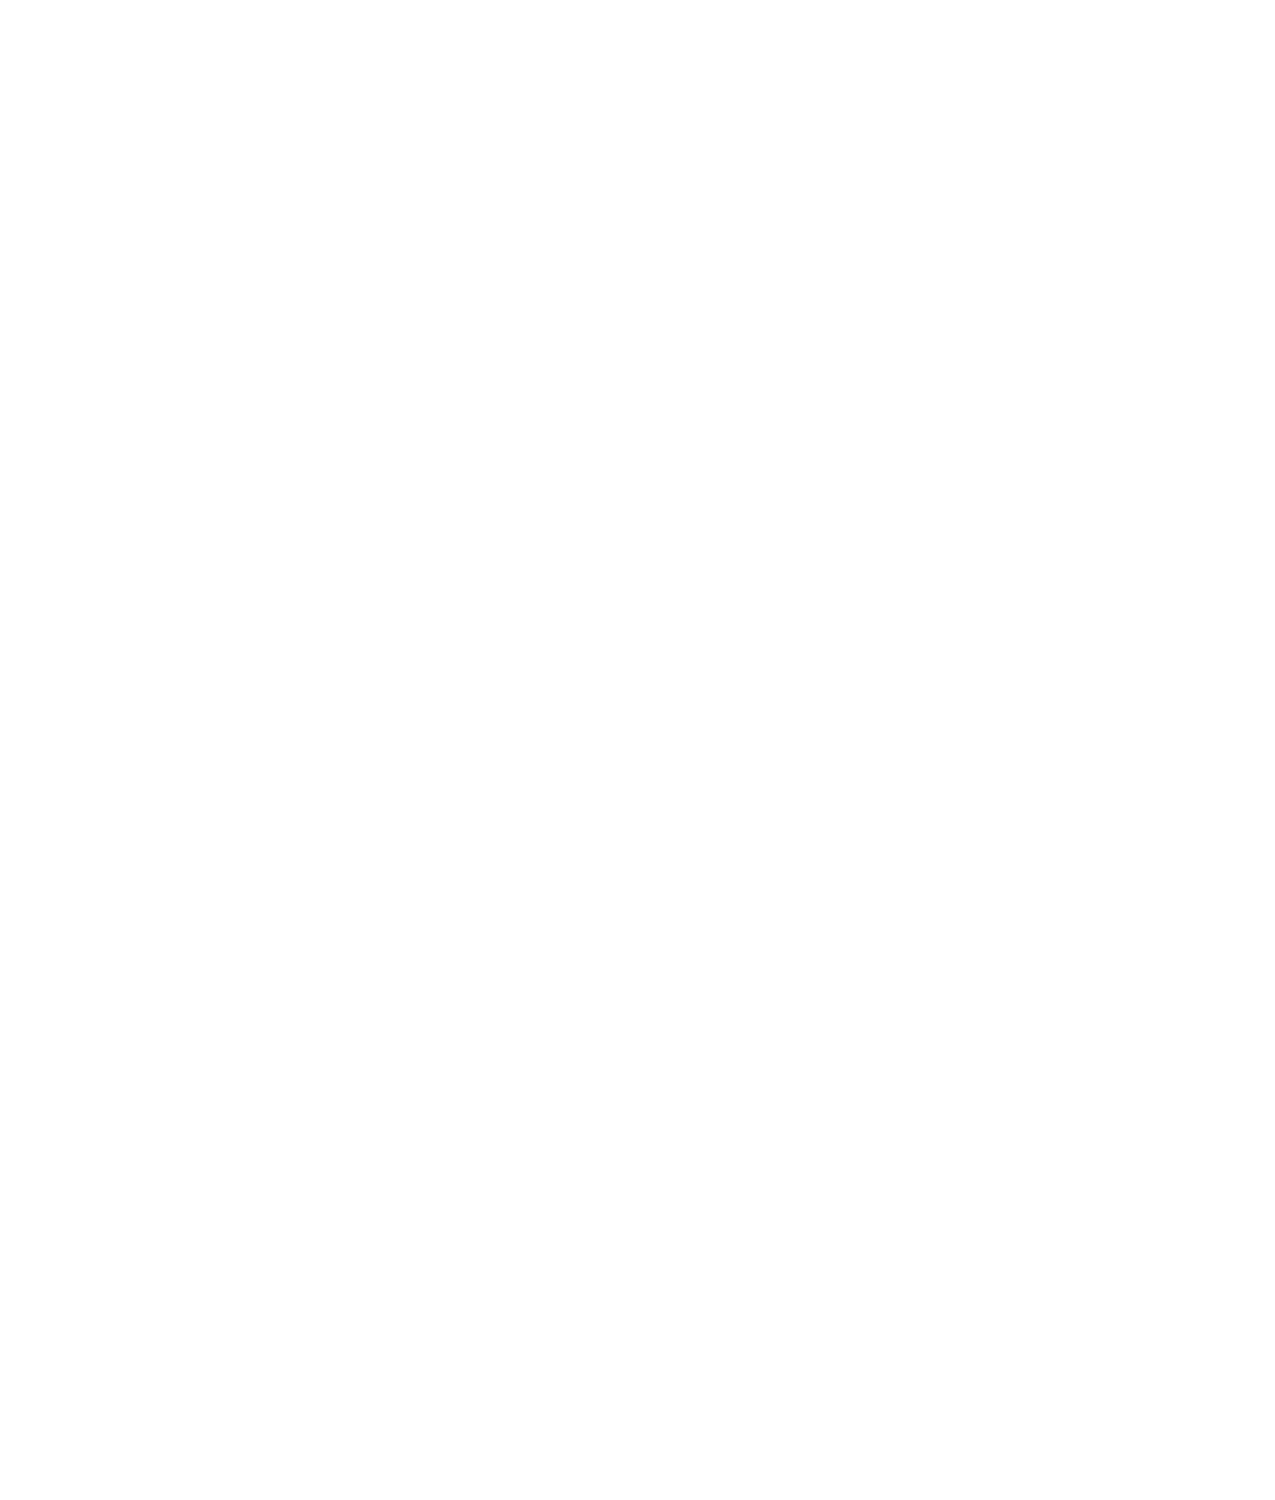

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


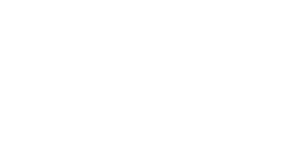

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


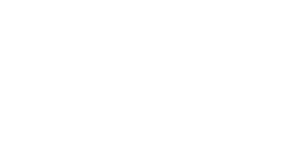

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


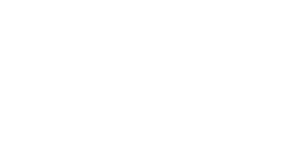

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


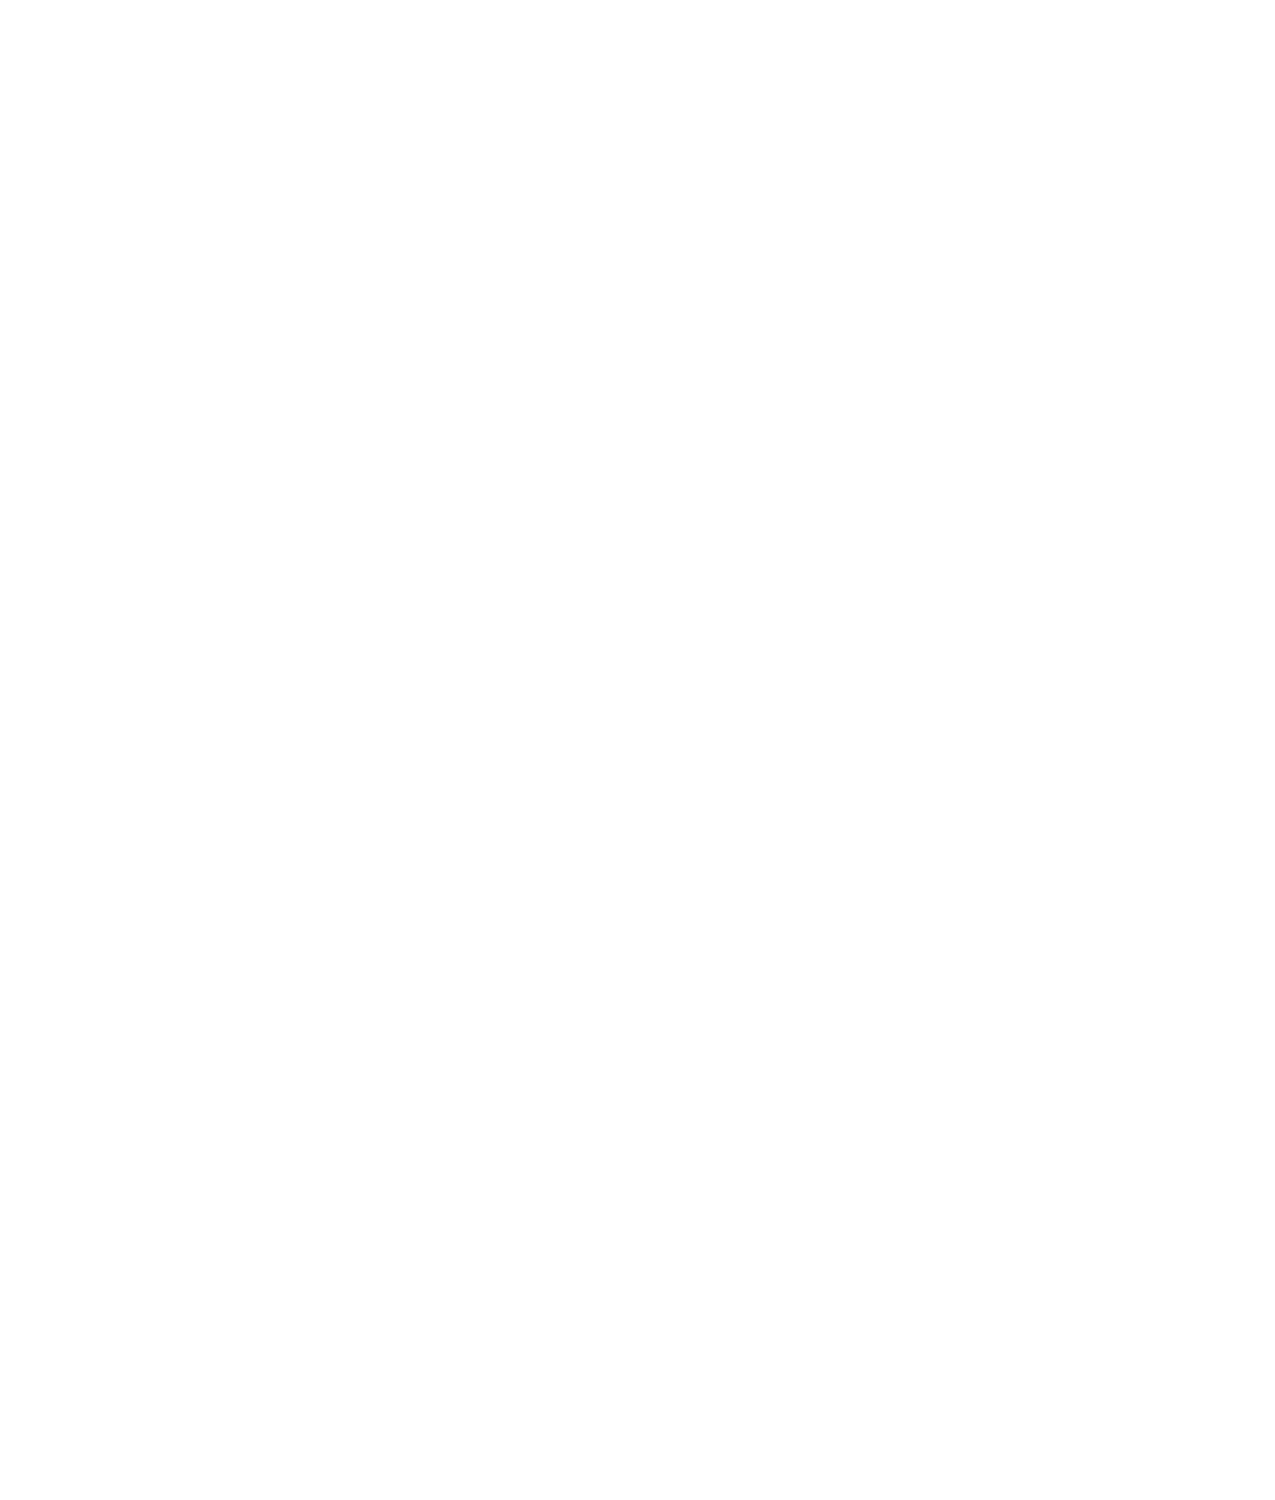

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


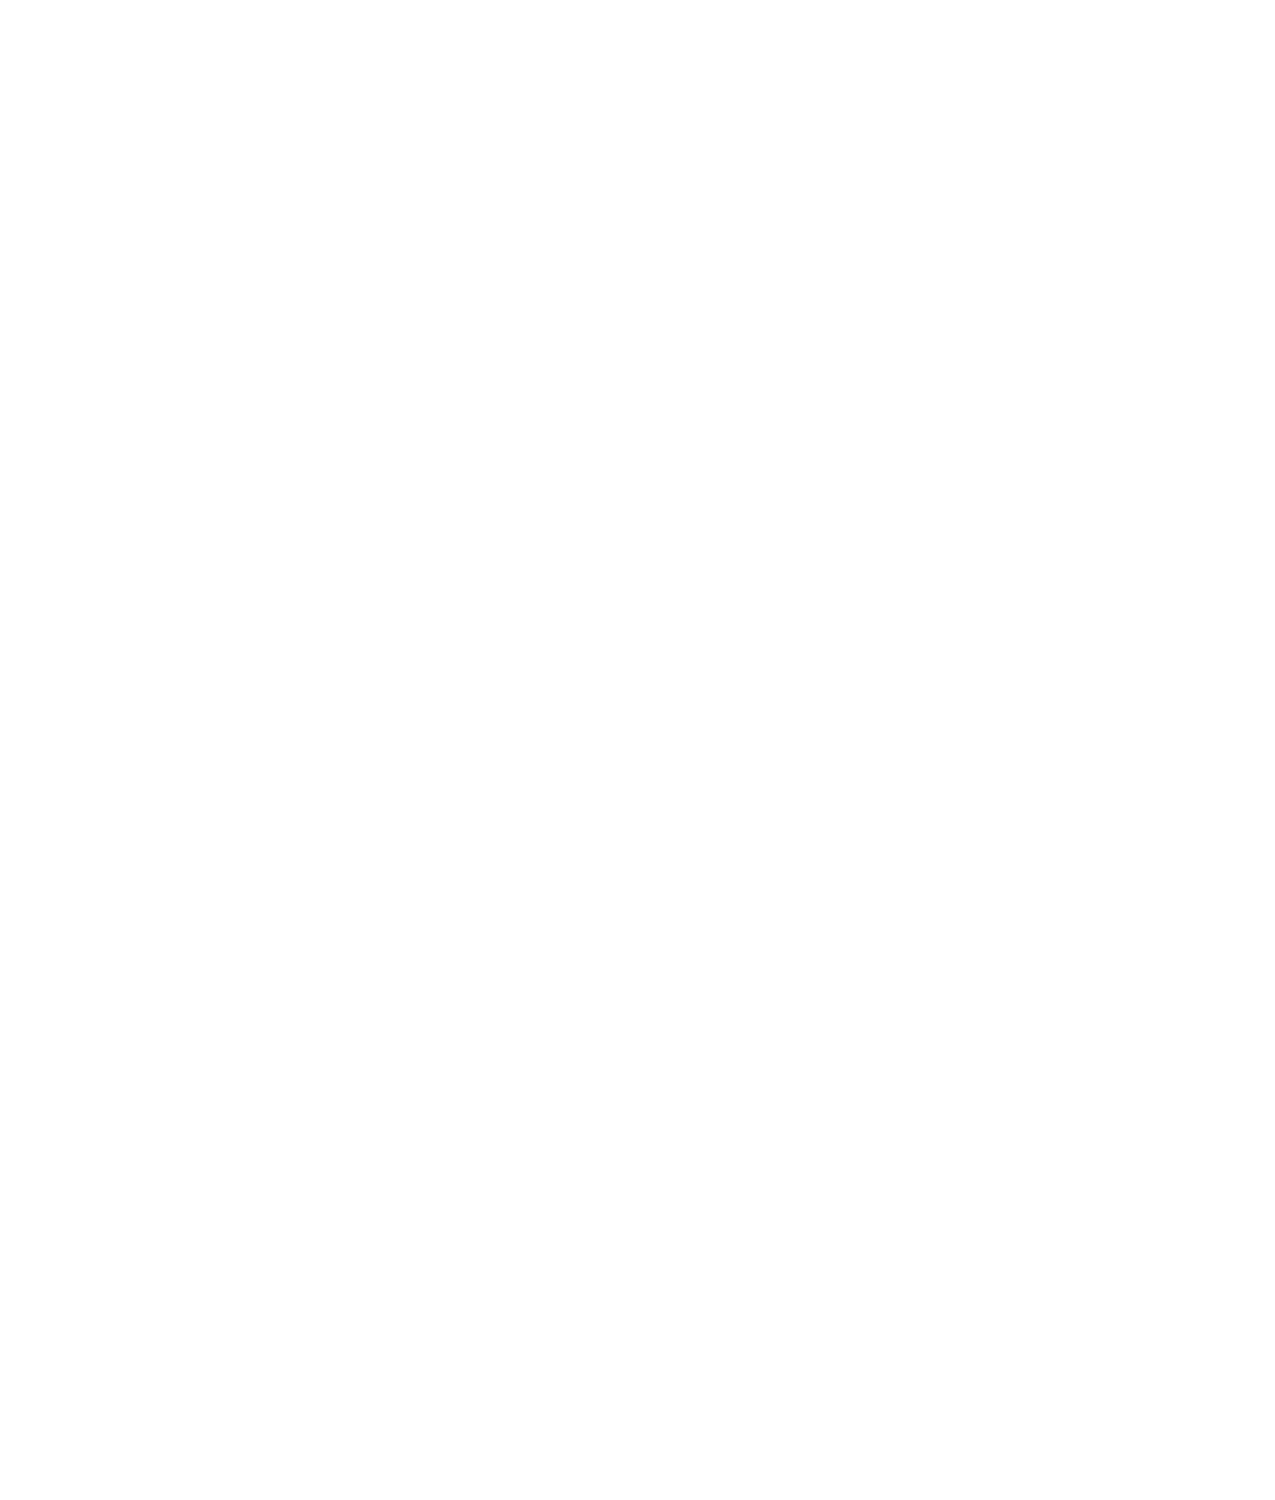

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


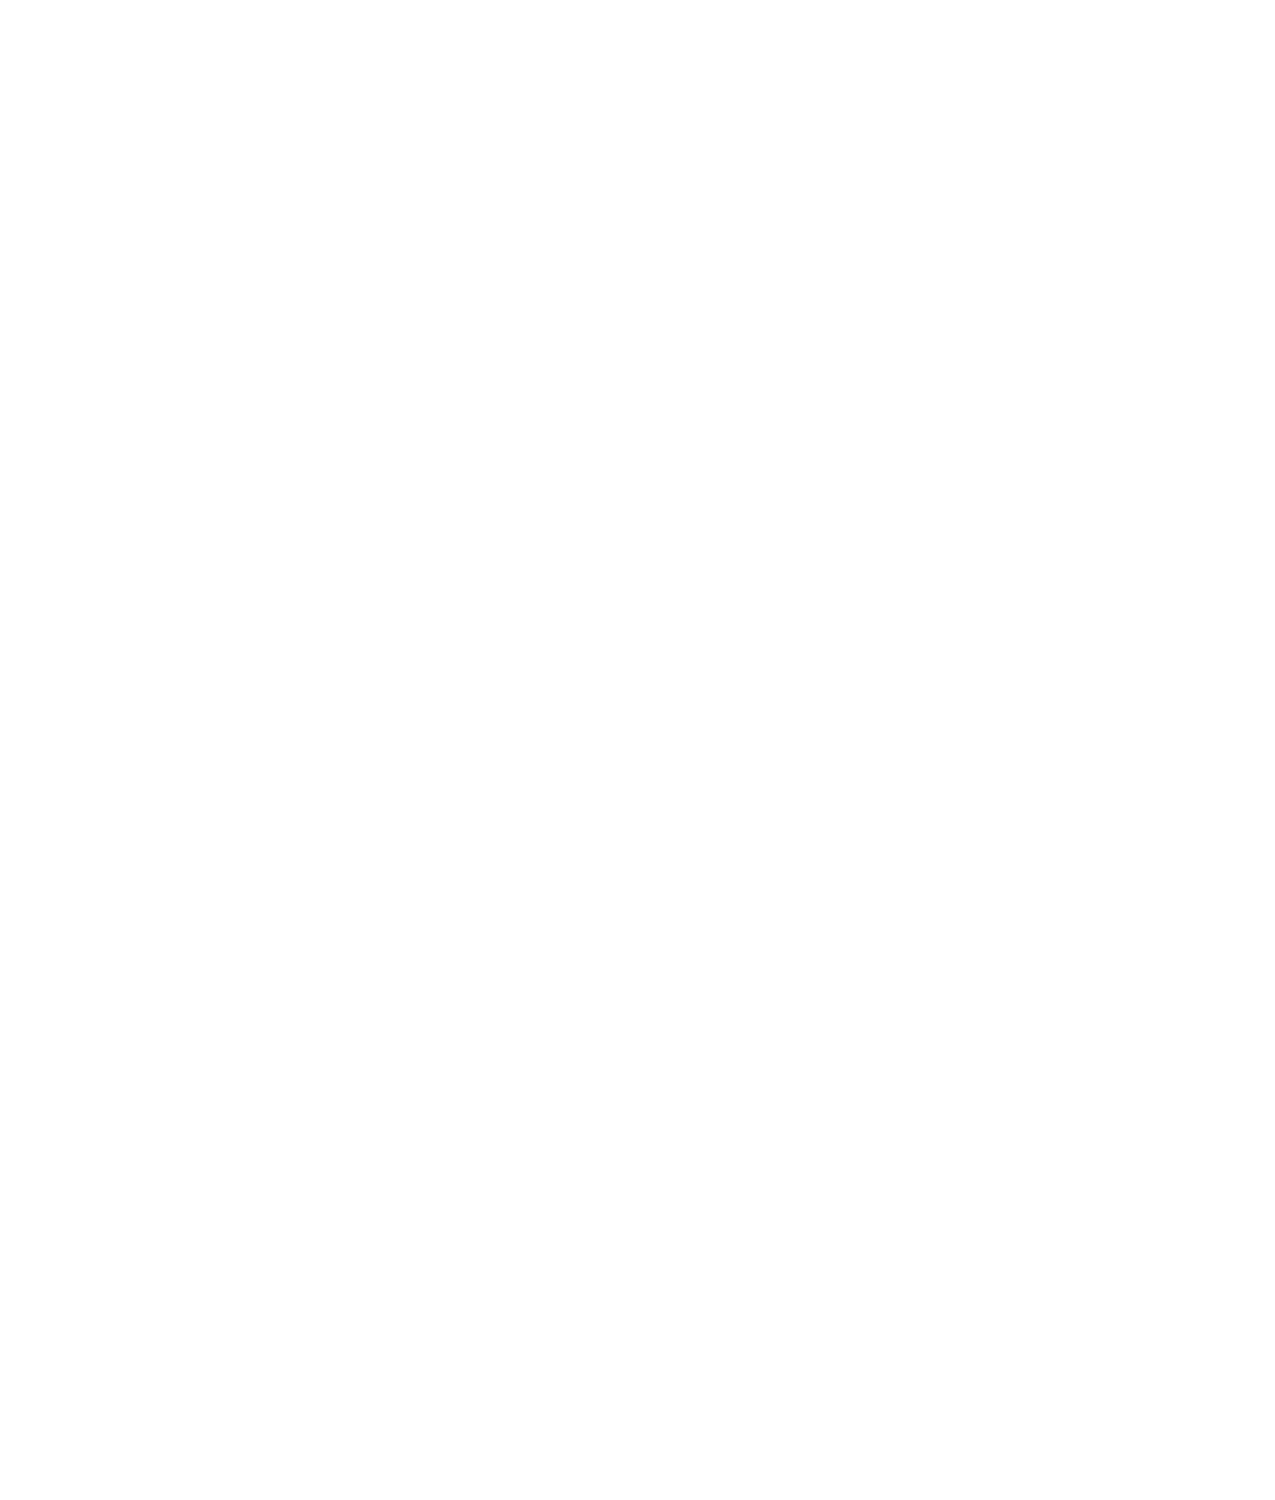

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


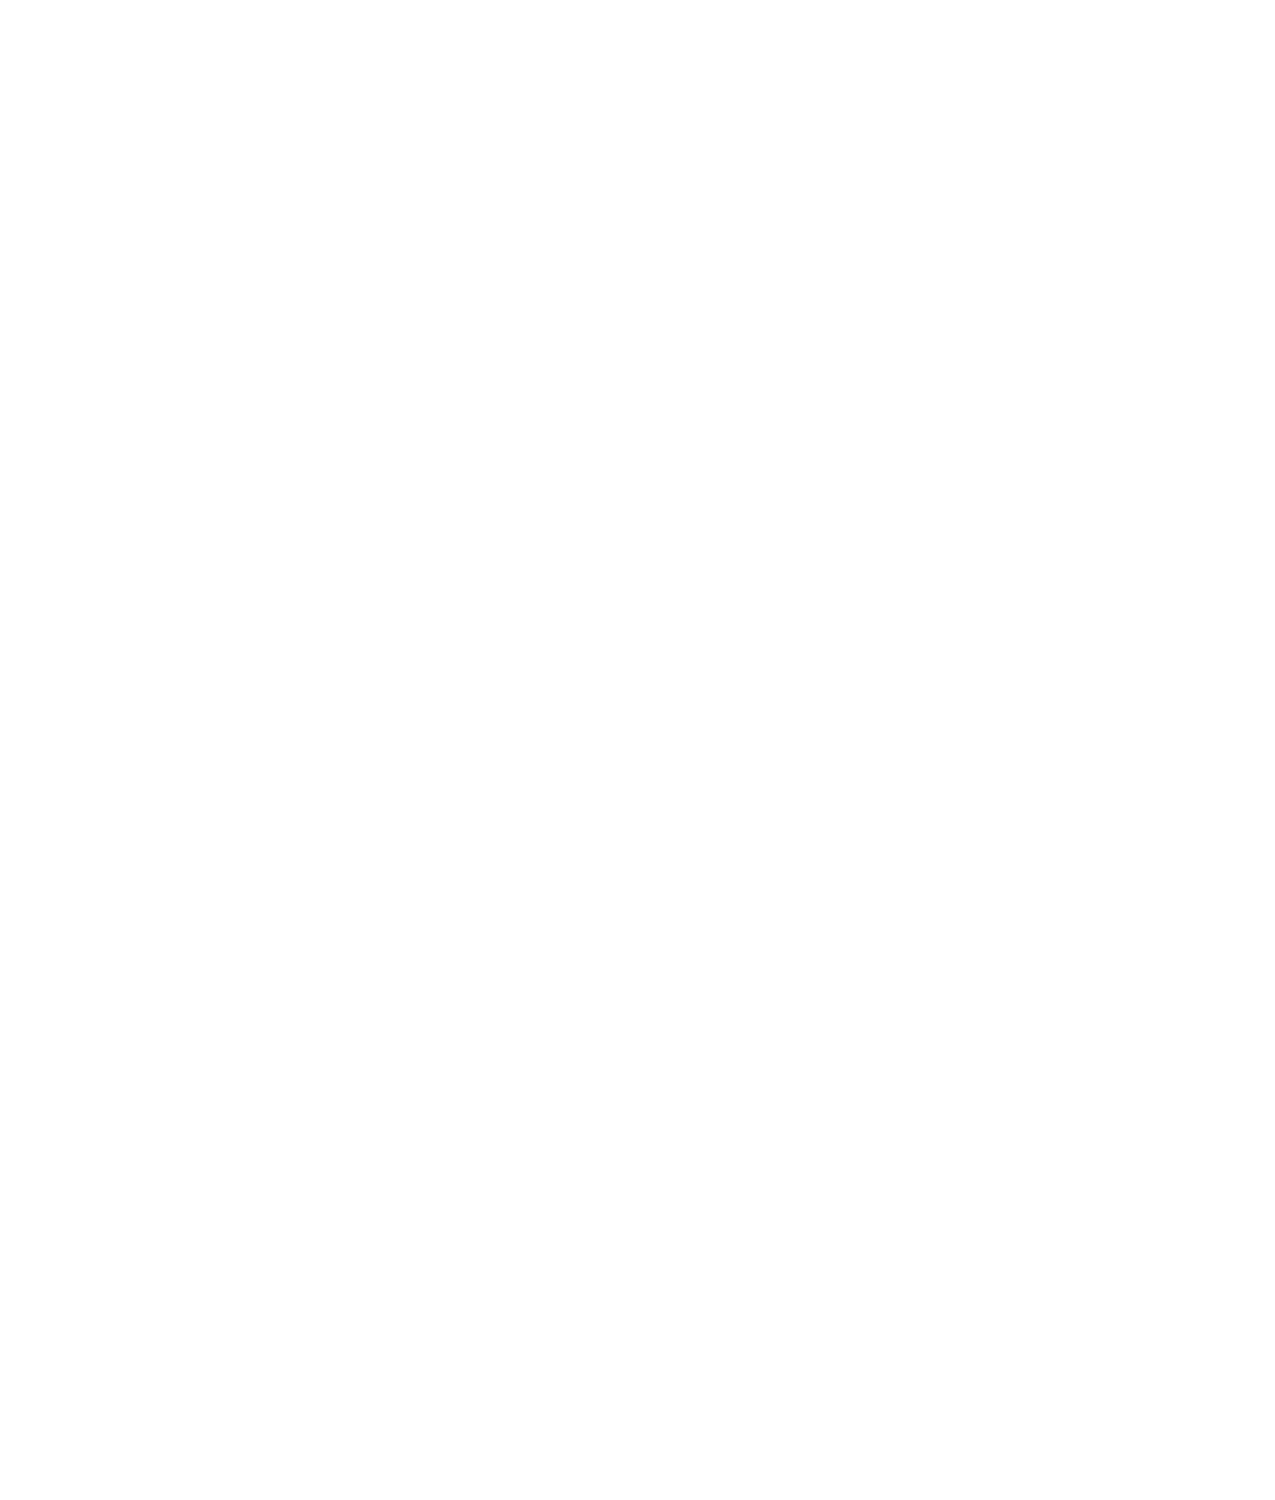

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


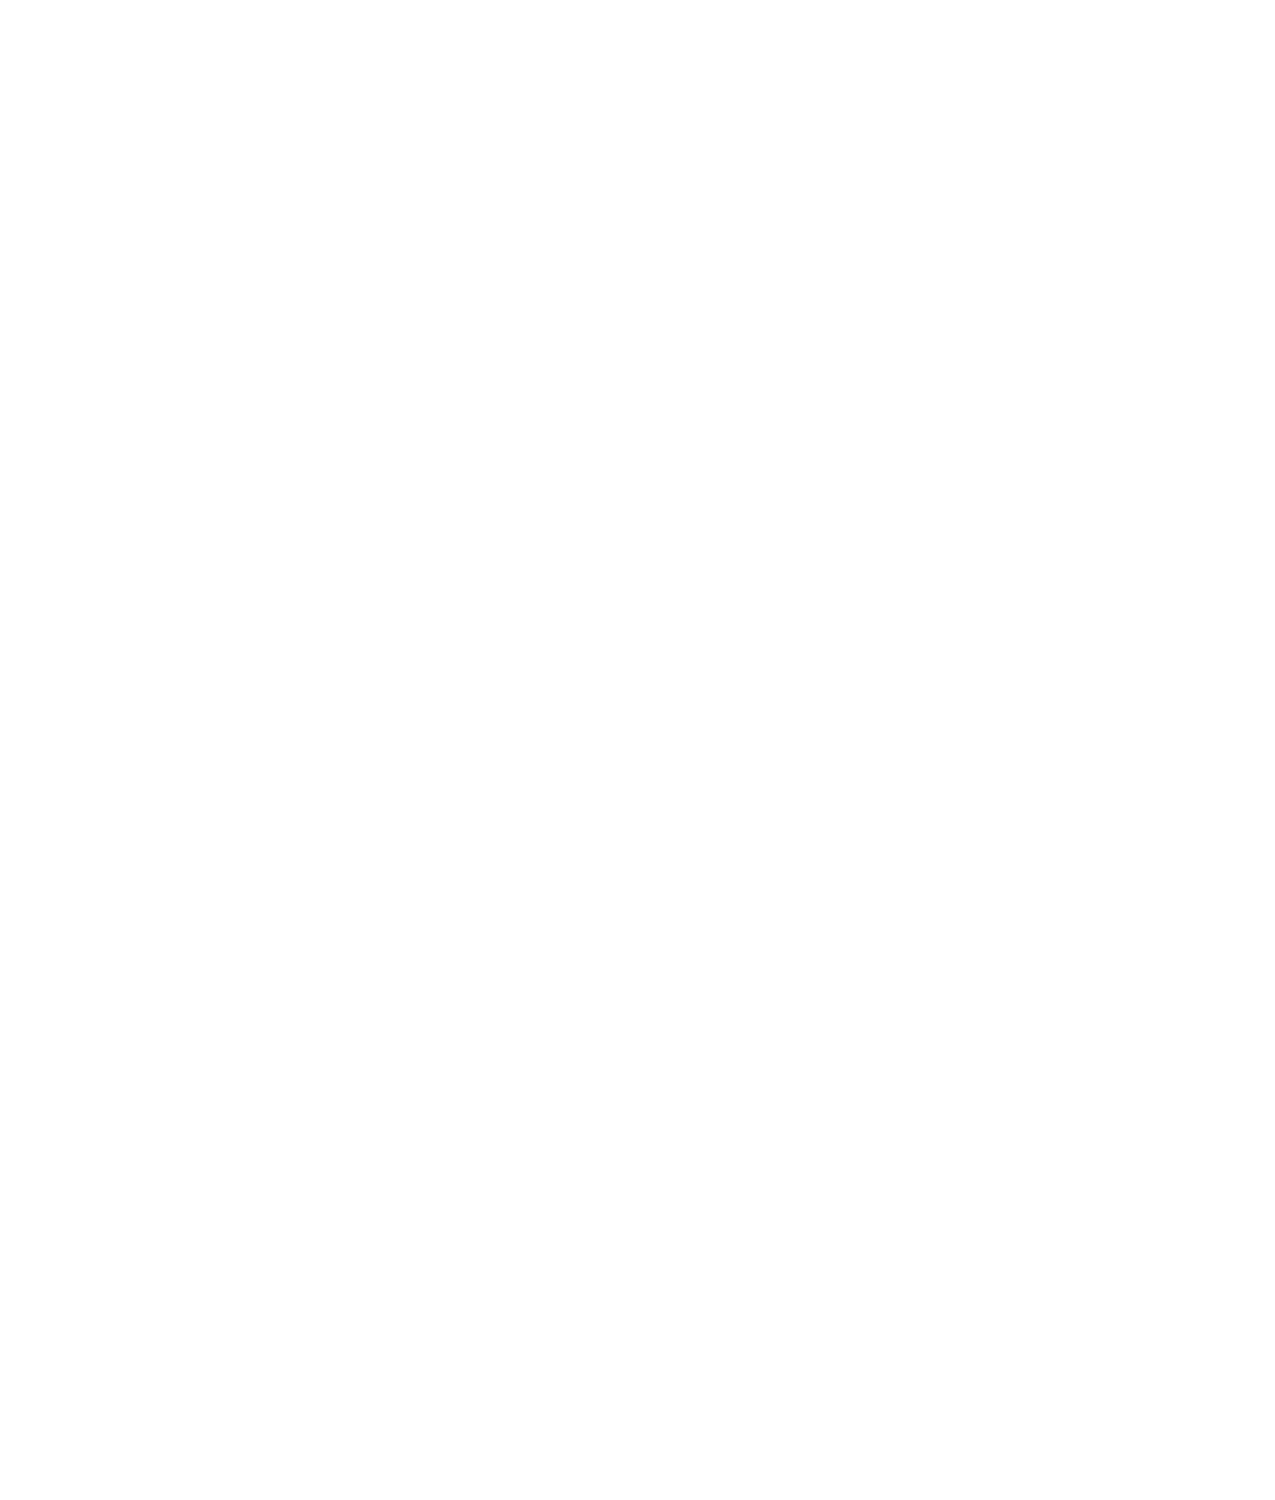

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


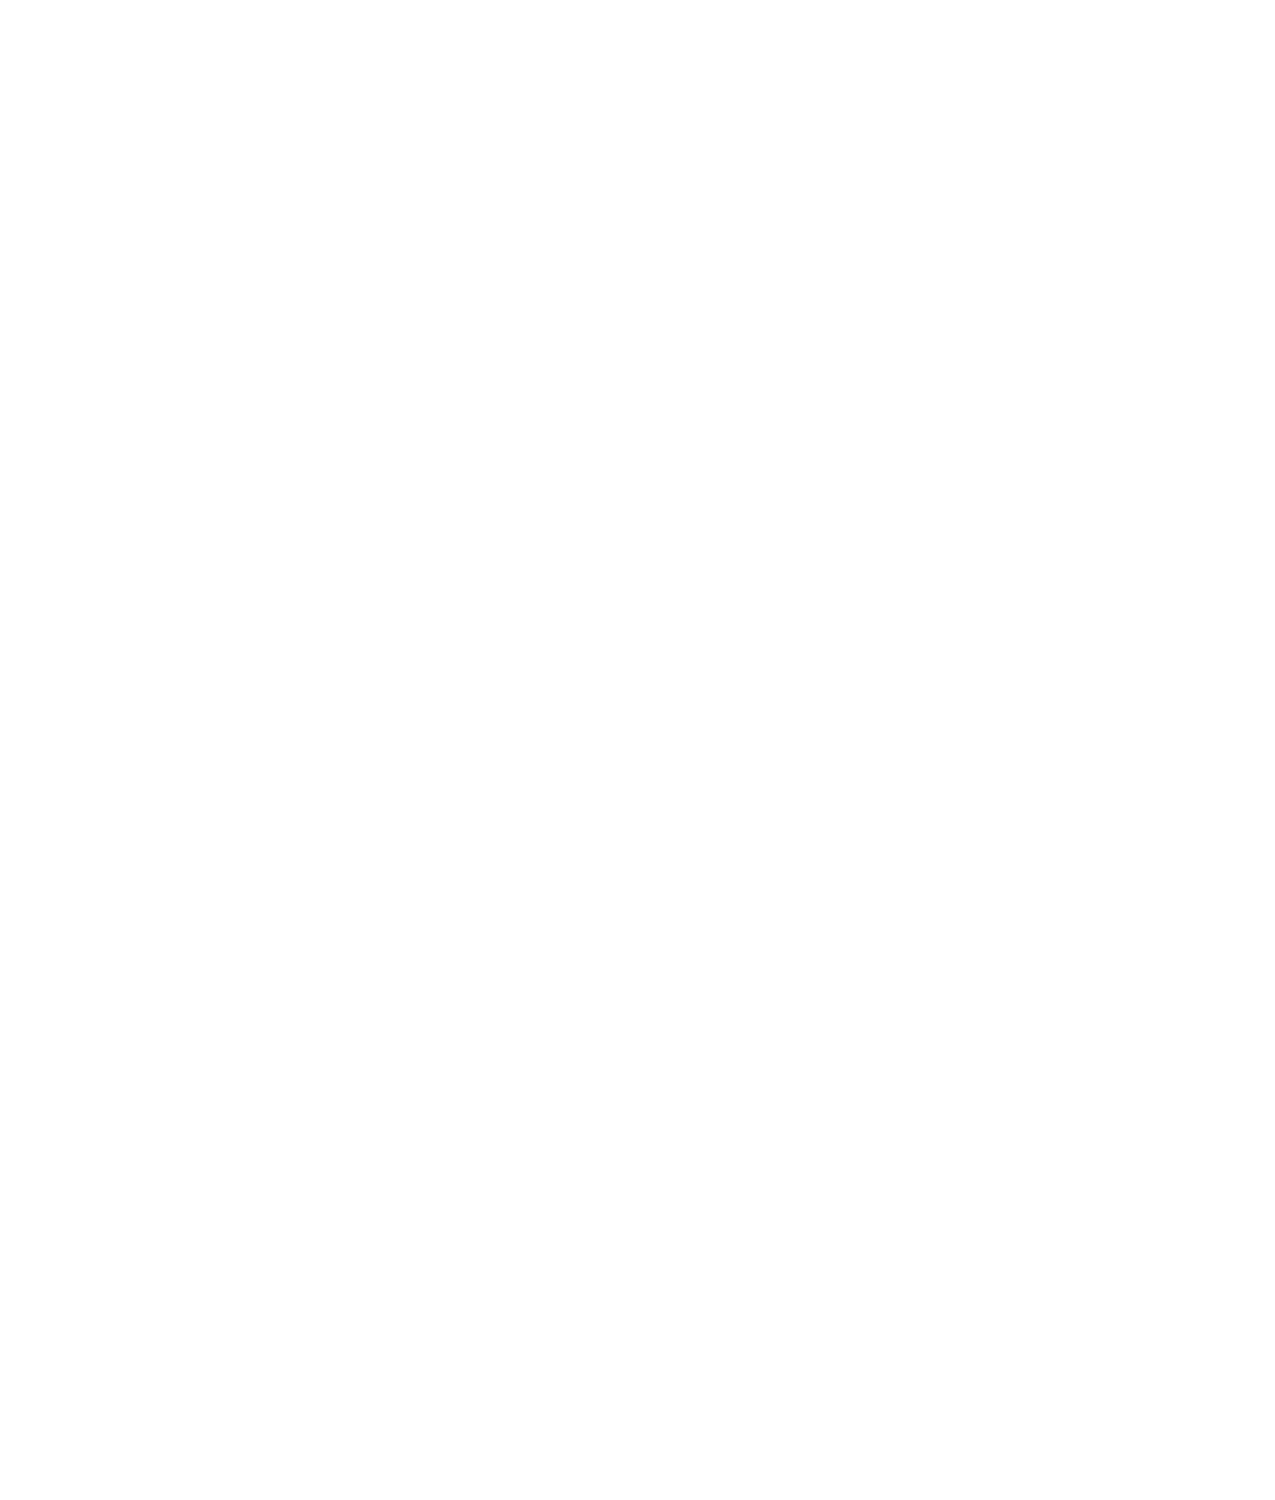

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


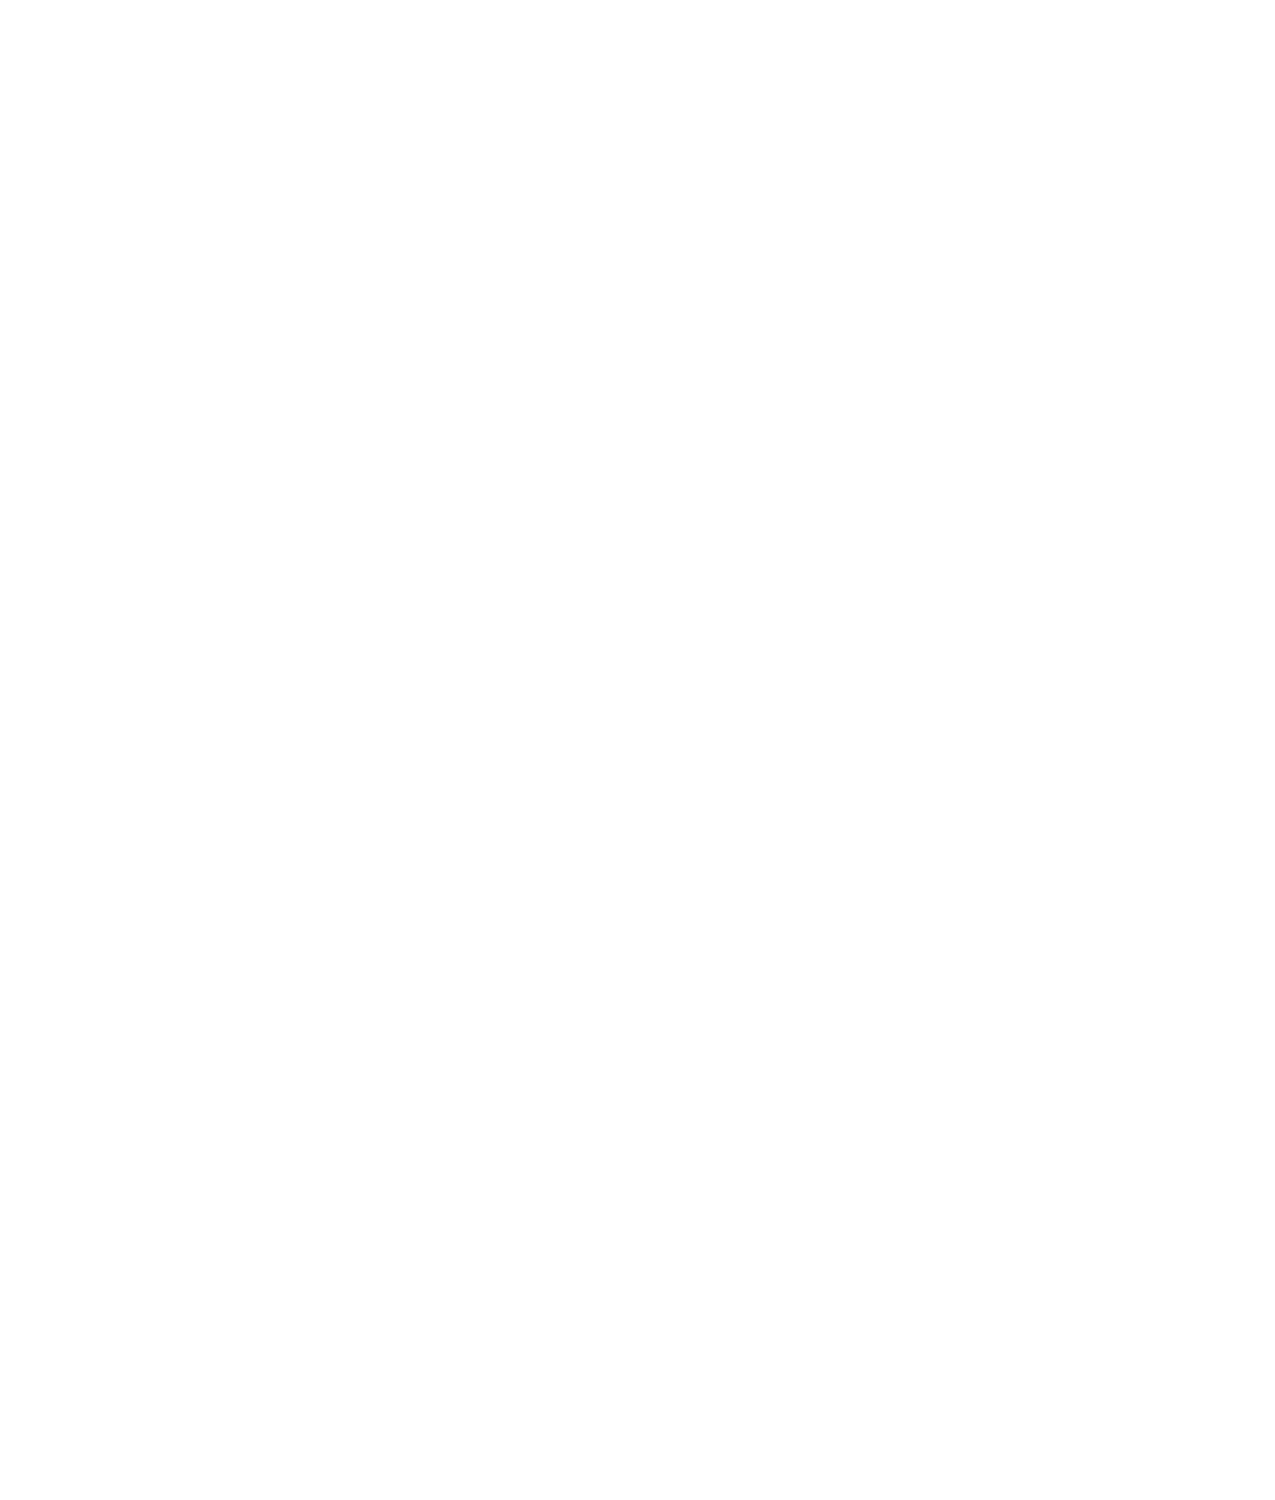

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


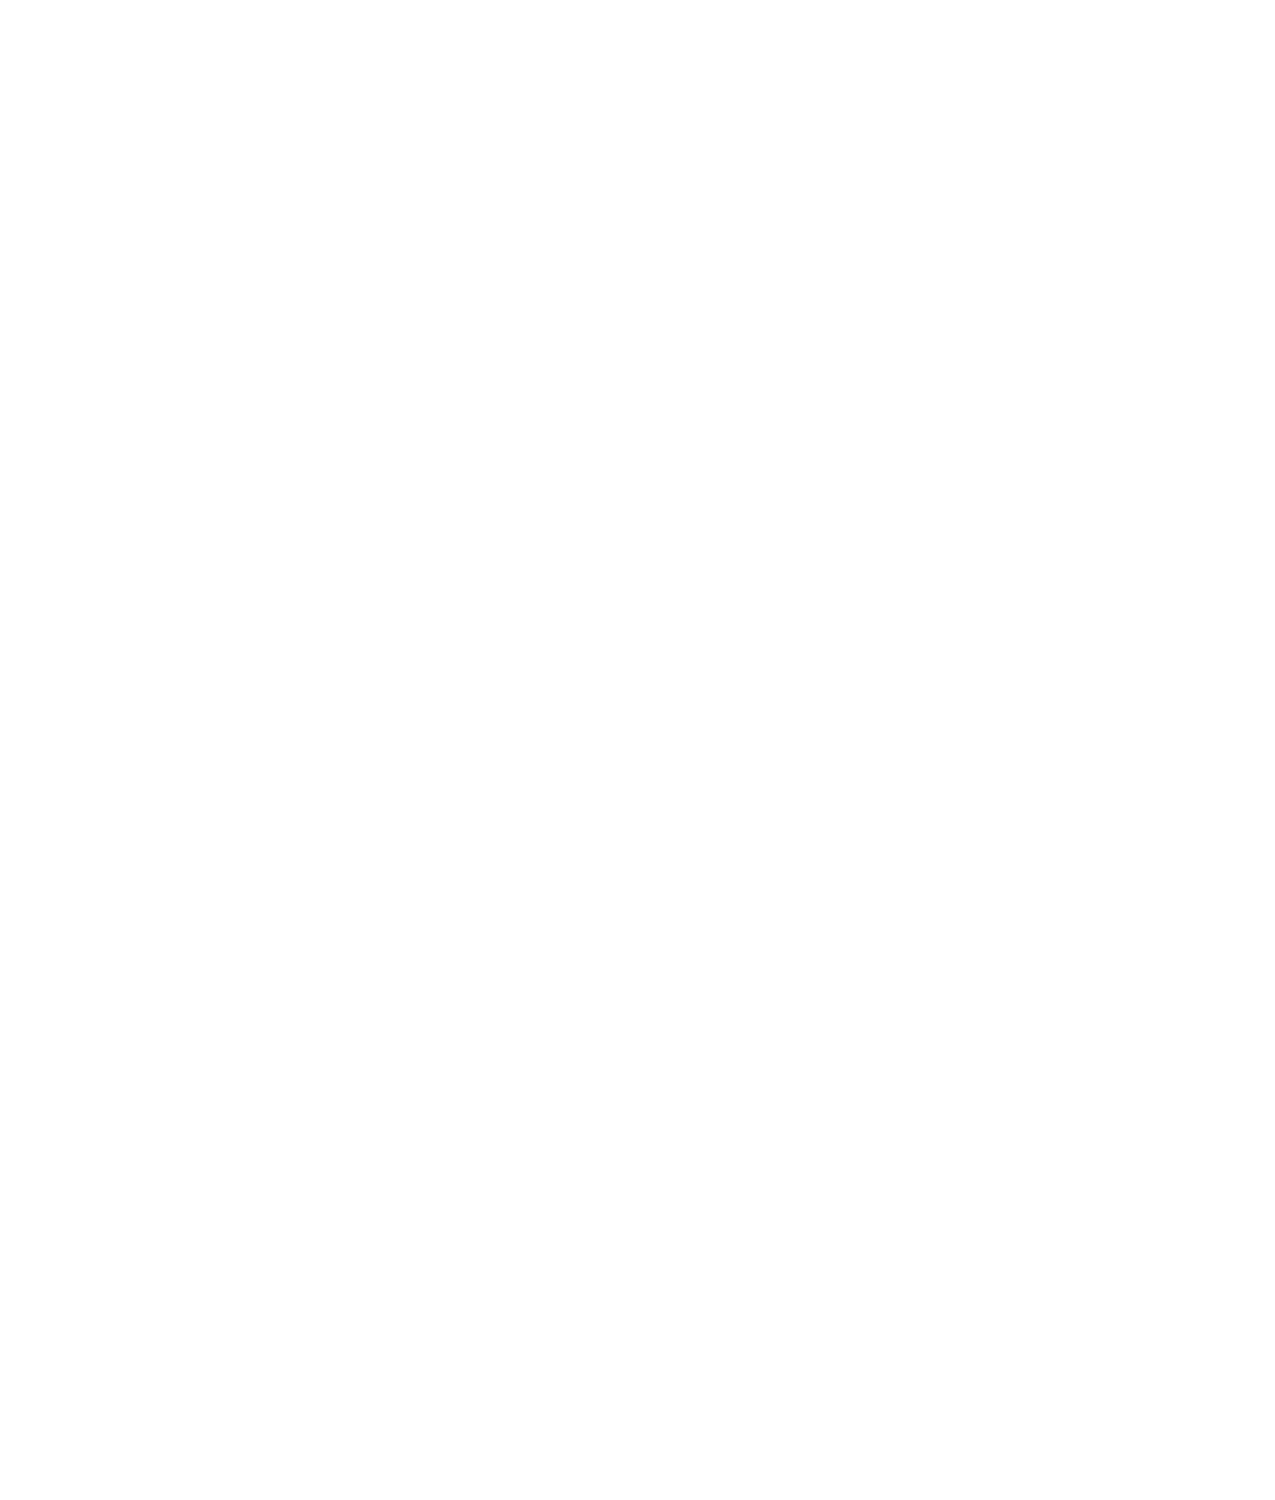

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


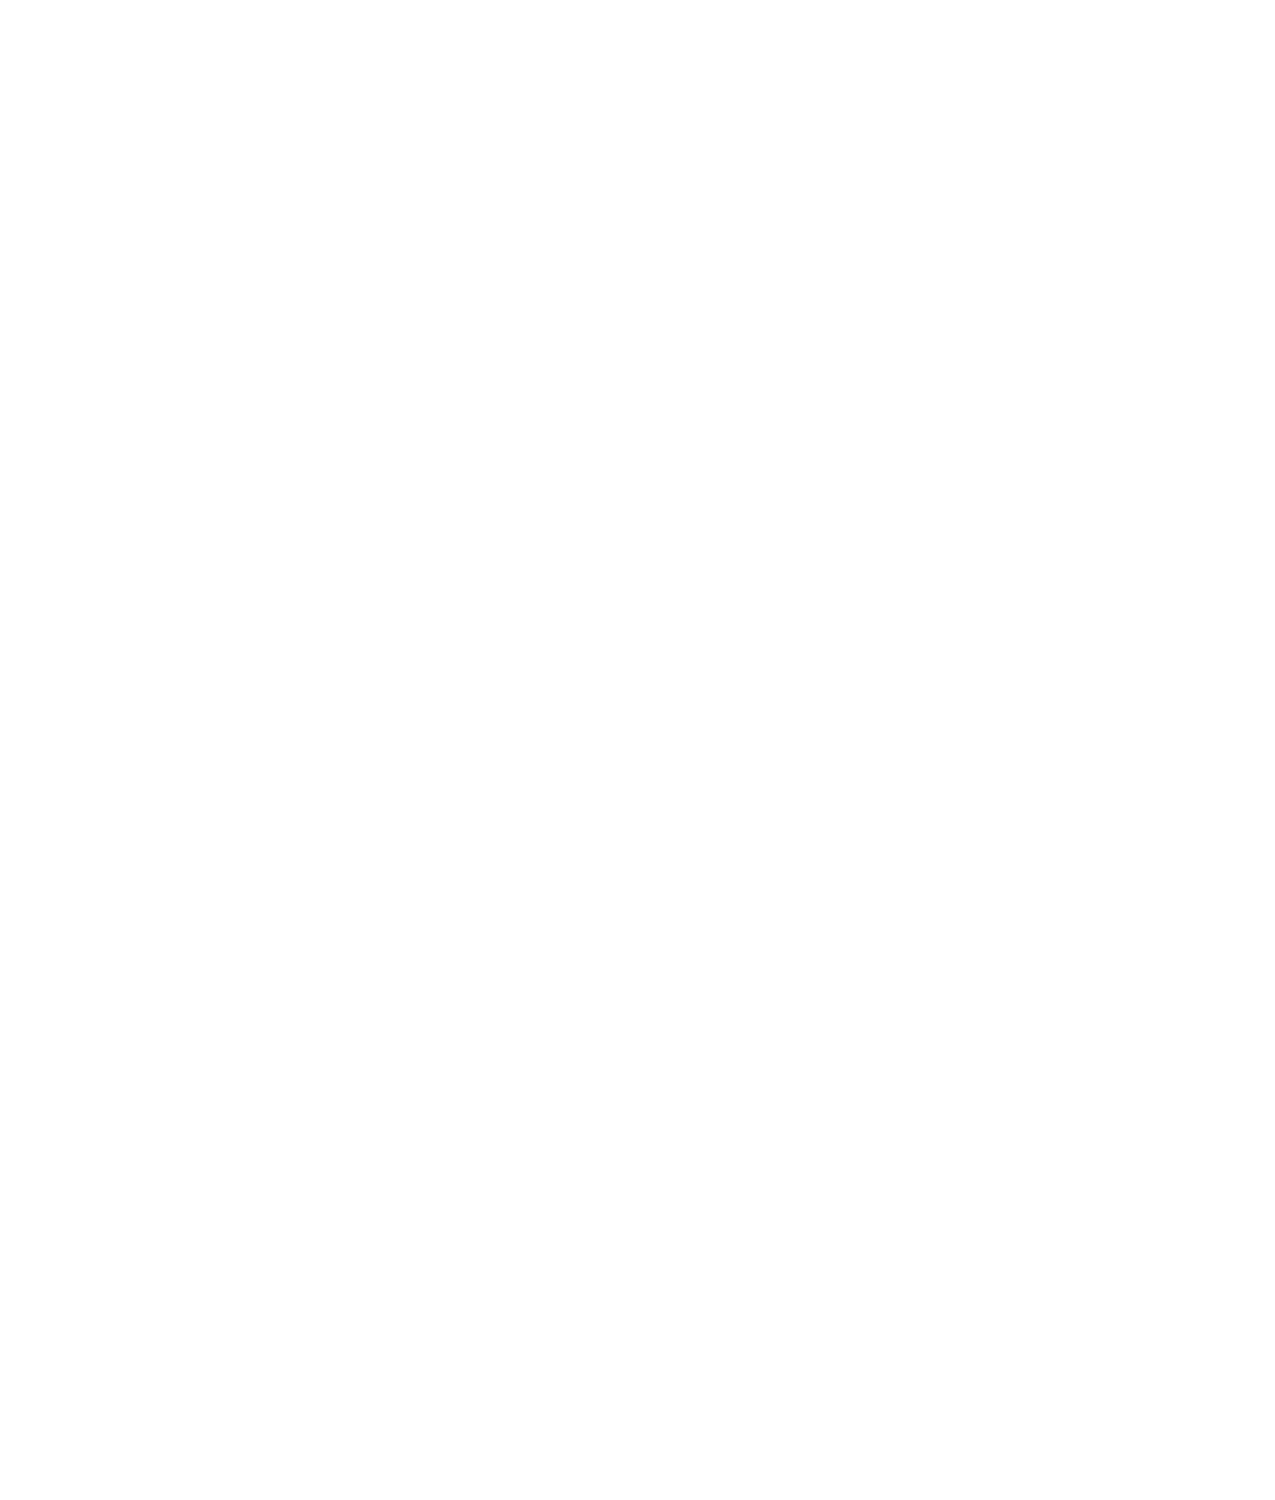

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


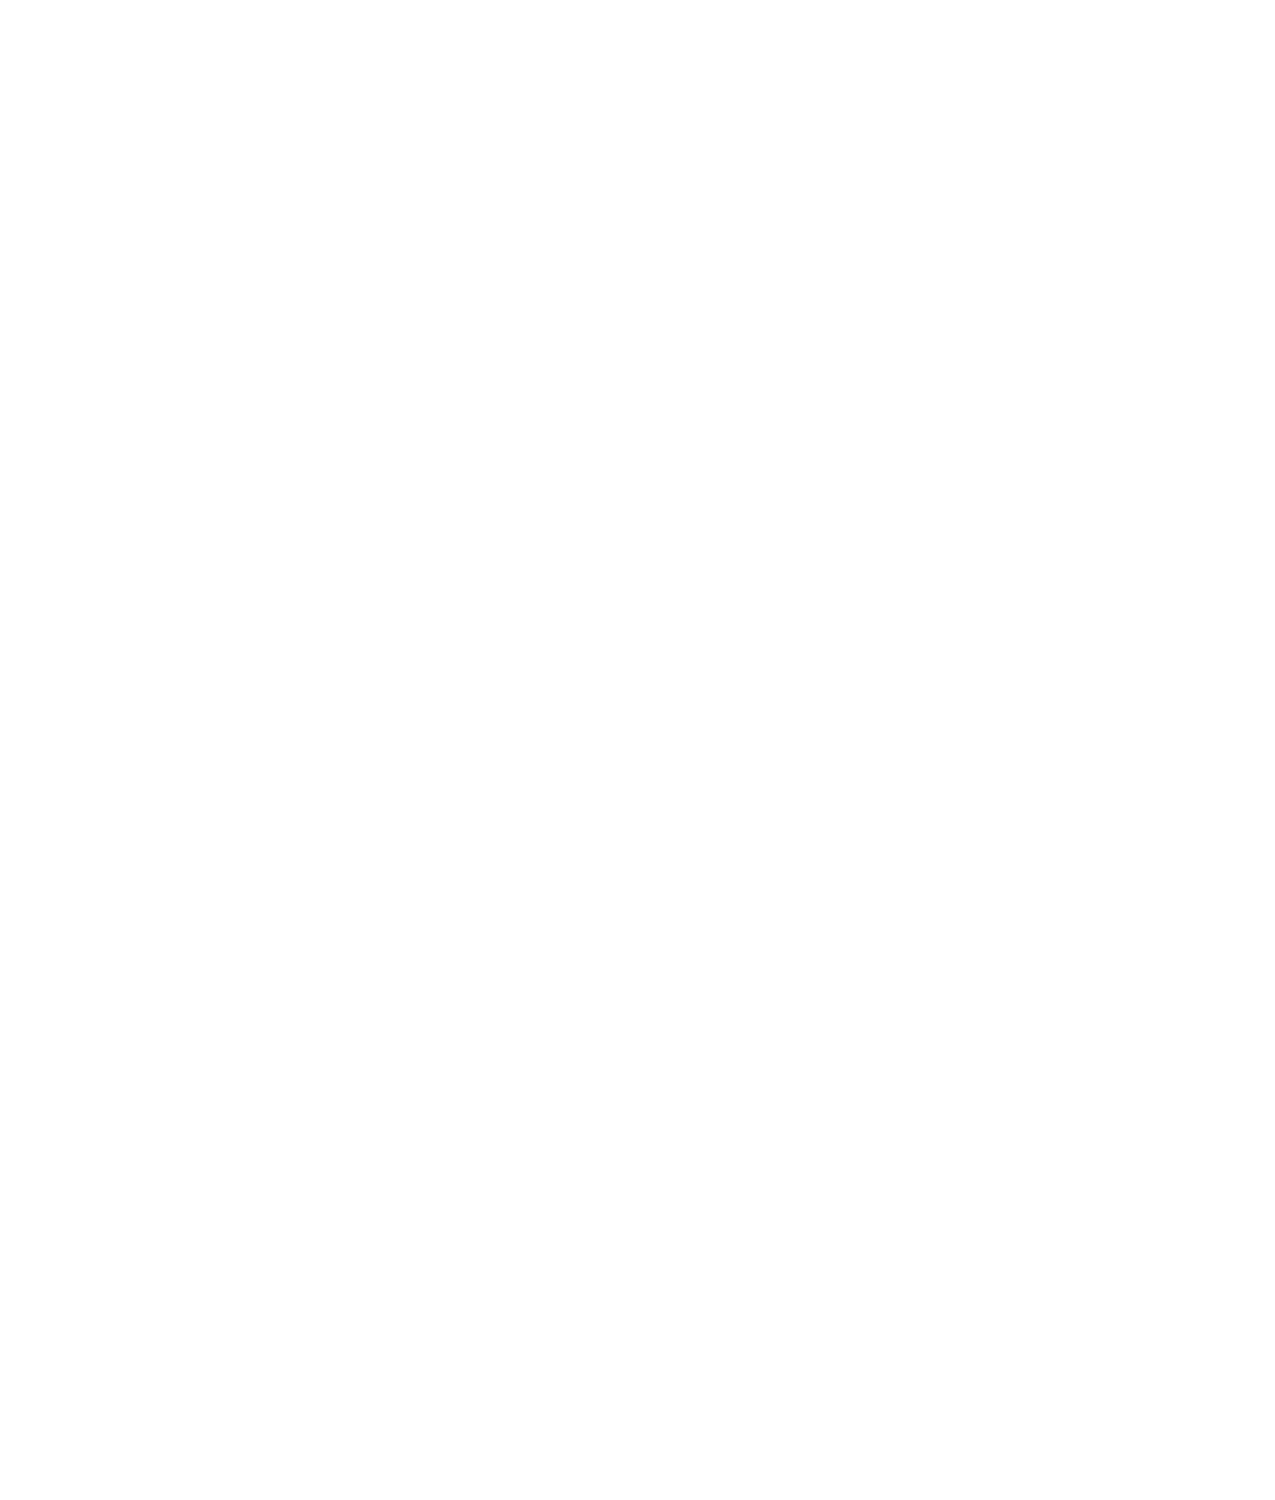

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


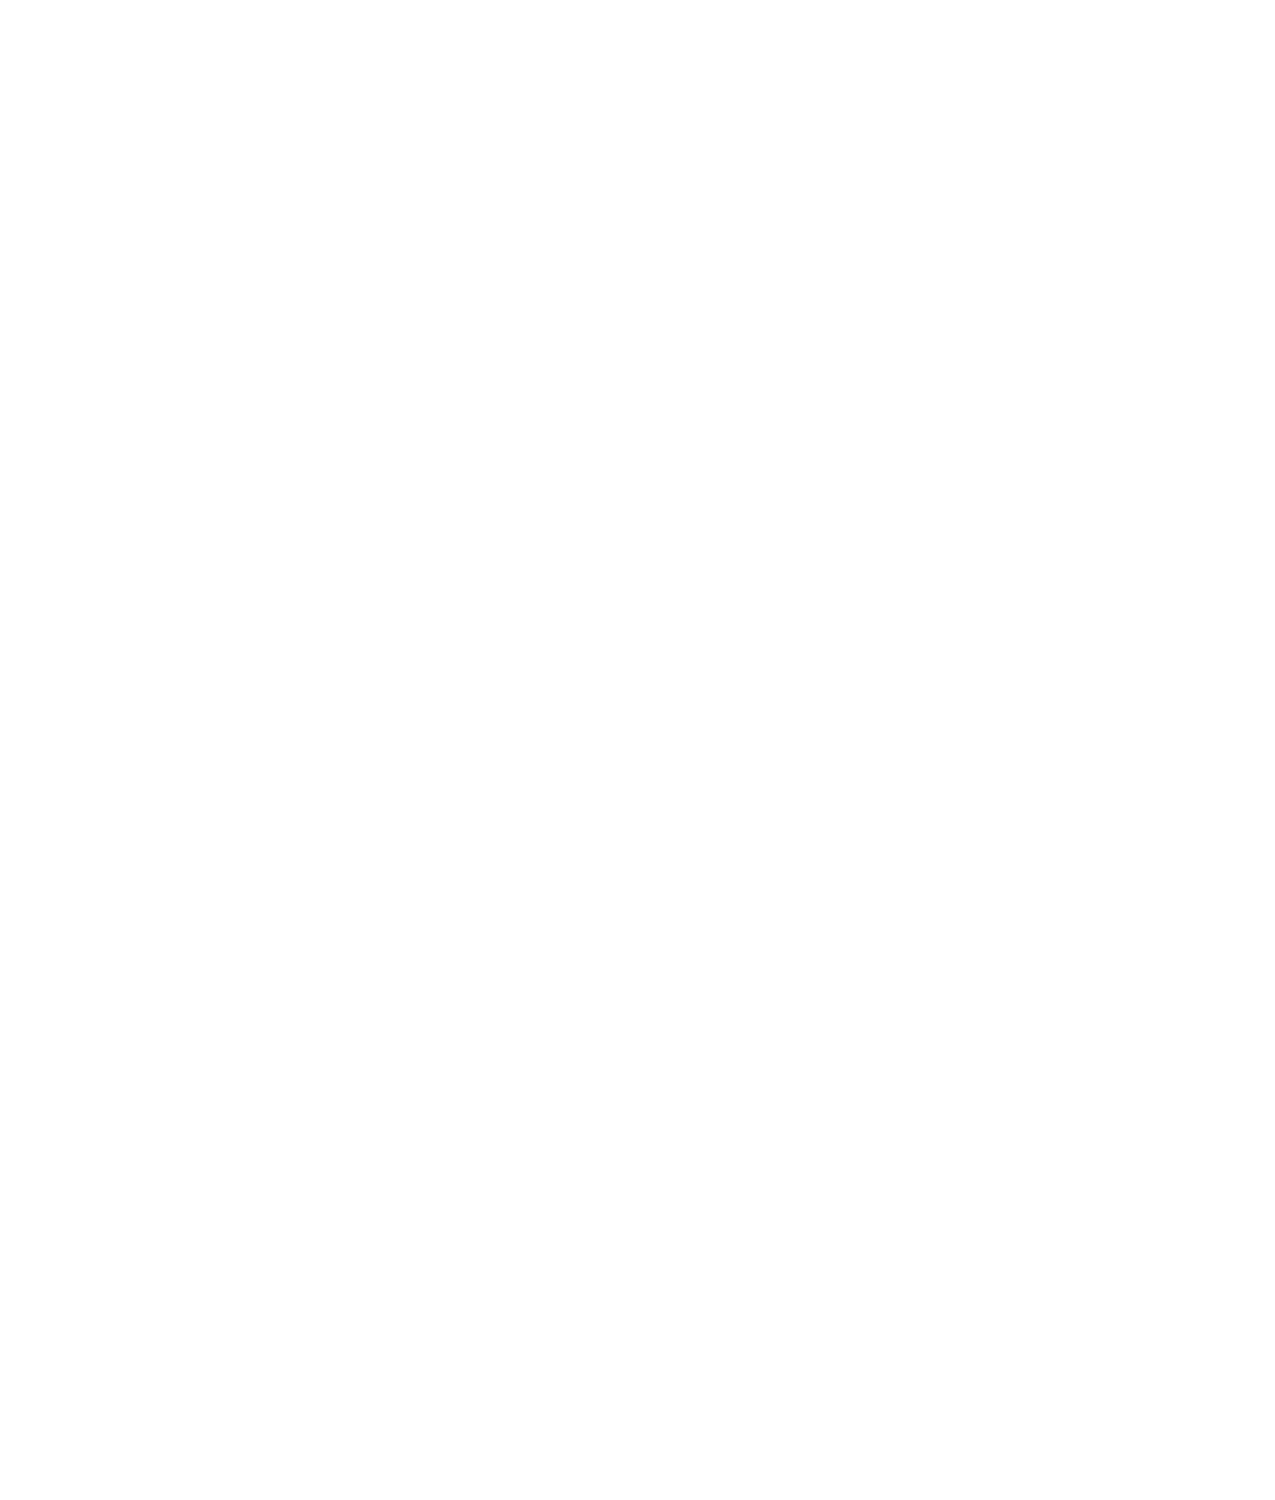

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


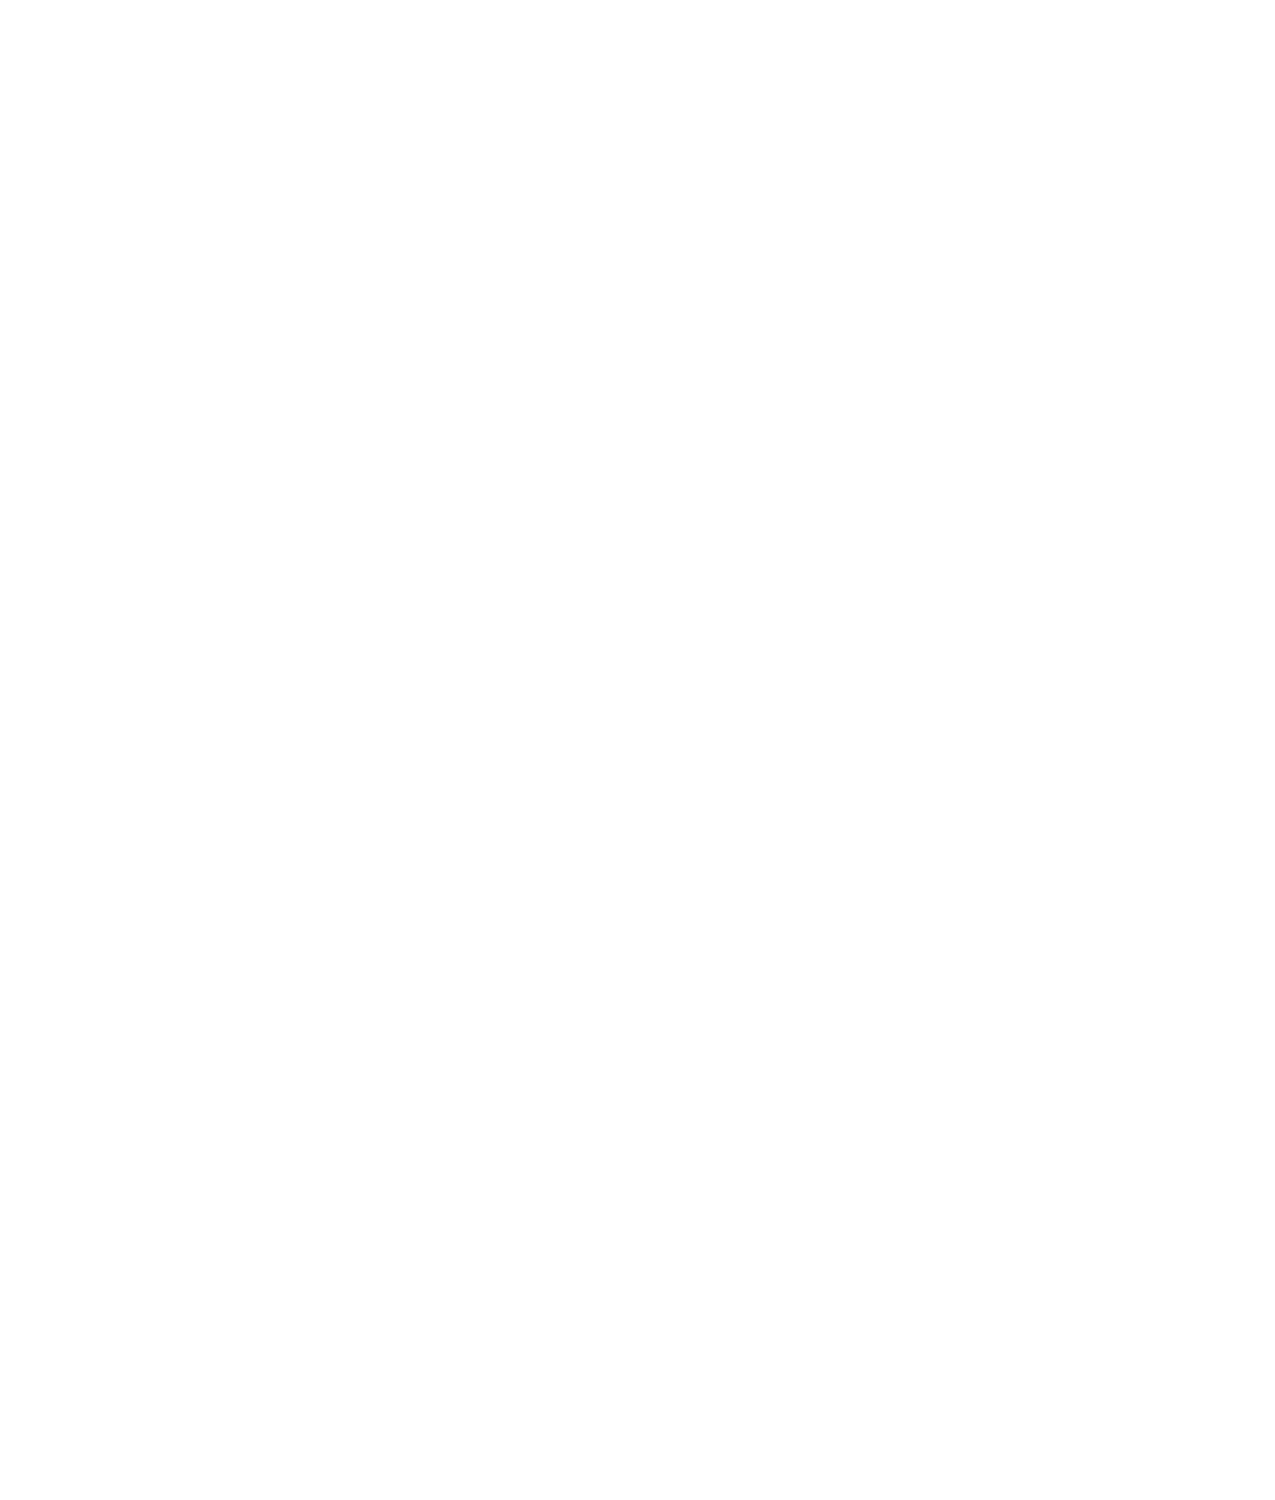

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


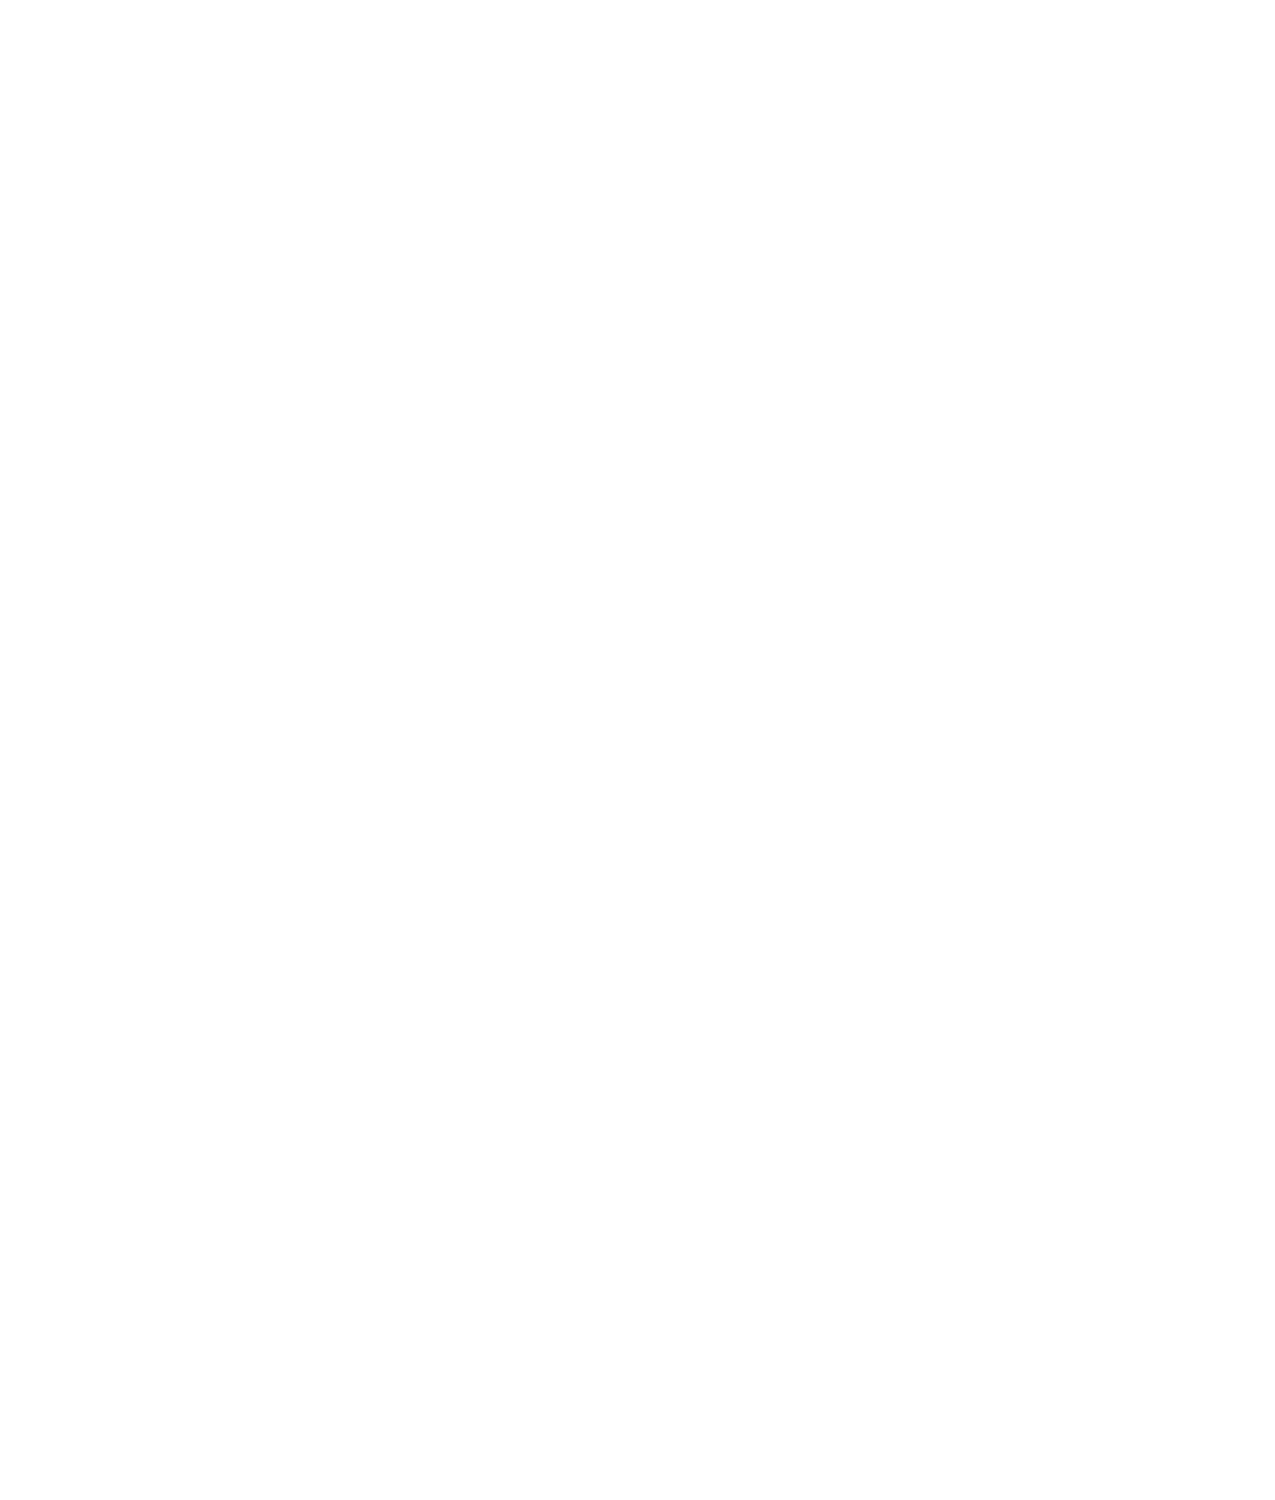

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


<IPython.core.display.Javascript object>


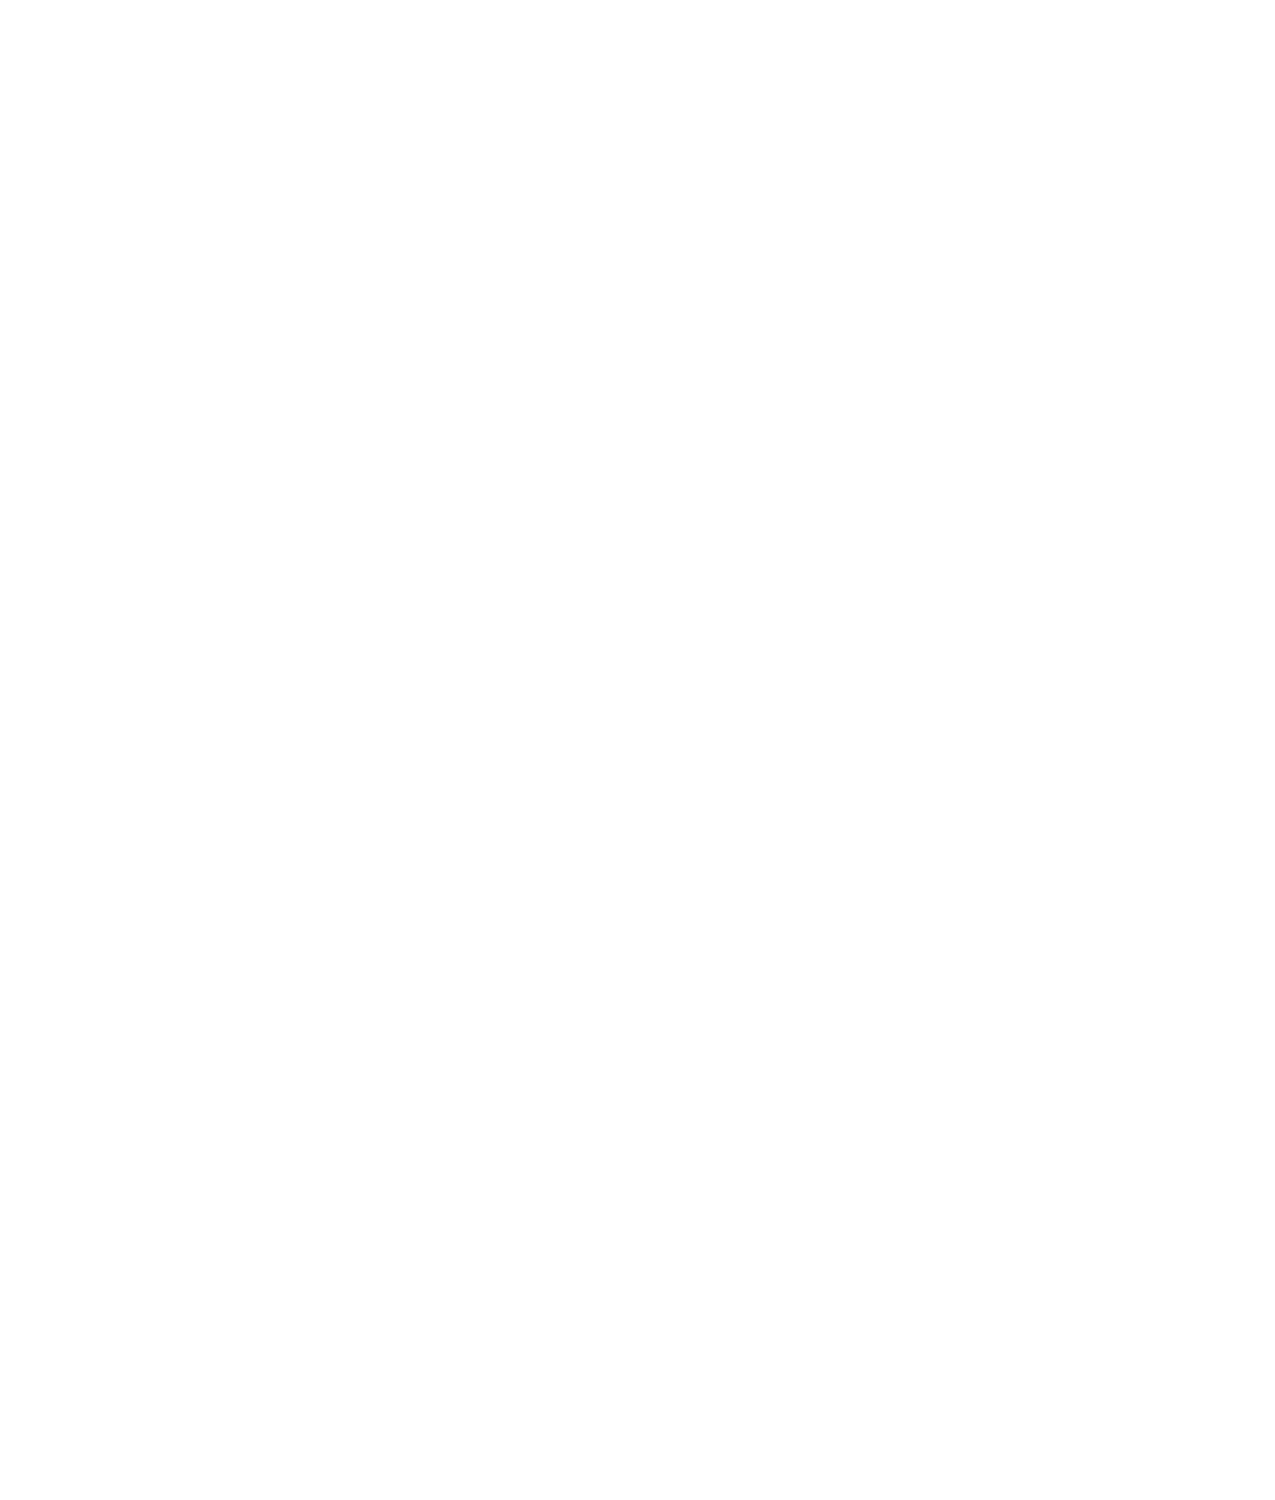

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


In [66]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
with fits.open('F05189_full_2comp_flipped-1comp_v502-250_vsig2-100.fits') as hdul:
    with fits.open('F05189_noflip_snr.fits') as snr_hdul:
        f = list(zip(x_y_start, x_y_end))
        flipped_arr_hdul = hdul[1].data['flipinfo']
        snr_1comp = snr_hdul[1].data['snr1comp']
        snr_c1 = snr_hdul[1].data['snrc1']
        snr_c2 = snr_hdul[1].data['snrc2']

        pdf = PdfPages('fits_o2_iter2_flipped-1comp_v502-250_vsig2-100_upperleftarc.pdf')


        wind = 0
        for x in range(0,size_x):
            for y in range(0,size_y):

                if wind == 0:
                    fig = plt.figure(figsize=(8.5,10.0))
                    gs = gridspec.GridSpec(4,4)
                    gs.update(left=0.12, right=0.90, top=0.98, bottom=0.08,hspace=0.08)
                ax1 = plt.subplot(gs[wind,0])        
                ne = Spaxel('/raid/KCWI/AGN_outflows/F05189/iter2/F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')
                plot_spaxel_pdf(ne, str(x_y_start[0]+x+1), str(x_y_start[1]+y+1), pr= True)
                ax1.tick_params(labelsize=8)
                if (wind !=3):
                    plt.xticks(())

                ax2 = plt.subplot(gs[wind,1])        
                ne = Spaxel('/home/acoil/AGN_outflows_ifsfit/F05189/iter3/F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')
                plot_spaxel_pdf(ne, str(x_y_start[0]+x+1), str(x_y_start[1]+y+1))
                plt.yticks(())
                ax2.tick_params(labelsize=8)
                if (wind !=3):
                    plt.xticks(())

                ax3 = plt.subplot(gs[wind,2])        
                ne = Spaxel('/raid/KCWI/AGN_outflows/F05189/iter2/F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')        
                ne.plot_line_vel_pdf([b'[OII]3729', b'[OII]3726'], 3726.03, z, -2500, 2500, flipped_arr_spaxel=flipped_arr_hdul[x_y_start[1]+y][x_y_start[0]+x], sn1=snr_c1[x_y_start[1]+y][x_y_start[0]+x], sn2=snr_c2[x_y_start[1]+y][x_y_start[0]+x], sn=True)
                plt.yticks(())
                ax3.tick_params(labelsize=8)
                if (wind !=3):
                    plt.xticks(())

                ax4 = plt.subplot(gs[wind,3])        
                ne = Spaxel('/home/acoil/AGN_outflows_ifsfit/F05189/iter3/F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')        
                ne.plot_line_vel_pdf([b'[OII]3729', b'[OII]3726'], 3726.03, z, -2500, 2500, sn1=snr_1comp[x_y_start[1]+y][x_y_start[0]+x], sn2=0, sn=True)
                ax4.yaxis.set_label_position('right')
                ax4.yaxis.tick_right()
                ax4.tick_params(labelsize=8)
                if (wind !=3):
                    plt.xticks(())


                if wind == 3:
                    plt.savefig(pdf, format='pdf',bbox_inches='tight')
                    plt.close()
                    wind = 0
                else:
                    wind = wind + 1

        if wind == 1 or wind == 2 or wind == 3:
            plt.savefig(pdf, format='pdf',bbox_inches='tight')
            plt.close()
        pdf.close()    
        

In [ ]:
from astropy.io import fits

<IPython.core.display.Javascript object>


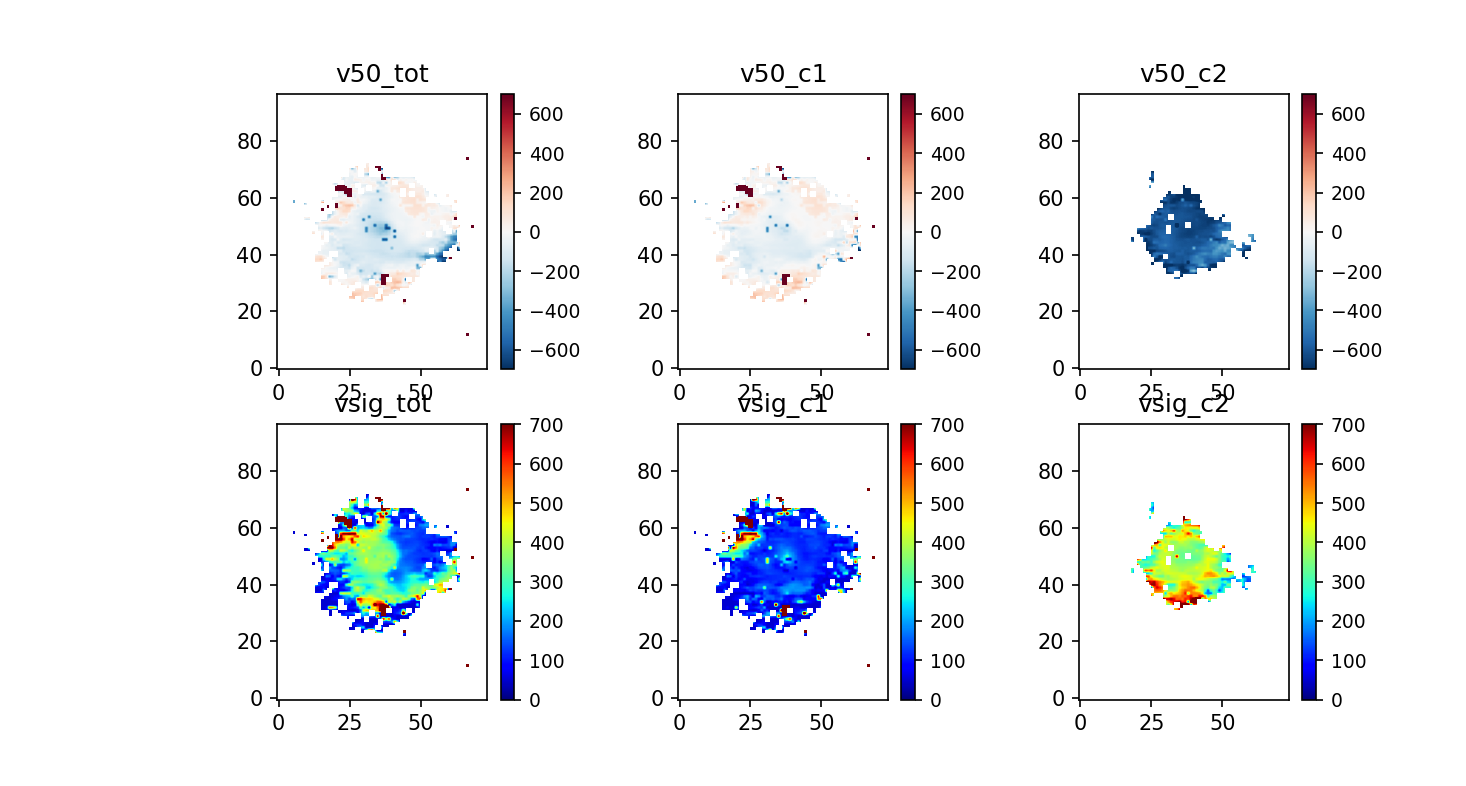

In [64]:
%matplotlib notebook
with fits.open('F05189_full_2comp_flipped-1comp_v502-250_vsig2-100.fits') as hdul:

    fc2 = hdul[1].data['fc2']
    err_fc2 = hdul[1].data['err_fc2']
    v50_tot = hdul[1].data['v50_tot']
    v50_c1 = hdul[1].data['v50_c1']
    v50_c2 = hdul[1].data['v50_c2']
    vsig_tot = hdul[1].data['vsig_tot']
    vsig_c2 = hdul[1].data['vsig_c2']
    vsig_c1 = hdul[1].data['vsig_c1']

    spx_x = 36
    spx_y = 50

    figure(figsize=(5,5))

    subplot(231)
    imshow(v50_tot, origin='lower', cmap='RdBu_r',vmin=-700,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('v50_tot')
    
    subplot(232)
    imshow(v50_c1, origin='lower', cmap='RdBu_r',vmin=-700,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('v50_c1')

    subplot(233)
    imshow(v50_c2, origin='lower', cmap='RdBu_r',vmin=-700,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('v50_c2')
    
    subplot(234)
    imshow(vsig_tot, origin='lower', cmap='jet',vmin=0,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('vsig_tot')
    
    subplot(235)
    imshow(vsig_c1, origin='lower', cmap='jet',vmin=0,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('vsig_c1')

    subplot(236)
    imshow(vsig_c2, origin='lower', cmap='jet',vmin=0,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('vsig_c2')
    
#     plt.savefig('v502-250_vsig2-100_cut.png')


In [4]:
with fits.open('F05189_full_2comp_flipped-1comp.fits') as hdul:
    fc2 = hdul[1].data['fc2']
    err_fc2 = hdul[1].data['err_fc2']
    v50_tot = hdul[1].data['v50_tot']
    v50_c1 = hdul[1].data['v50_c1']
    v50_c2 = hdul[1].data['v50_c2']
    vsig_tot = hdul[1].data['vsig_tot']
    vsig_c1 = hdul[1].data['vsig_c1']
    vsig_c2 = hdul[1].data['vsig_c2']
    flipinfo = hdul[1].data['flipinfo']
    
    # 53,47 53,48
    print('53,47: v50_c1:', round(v50_c1[46][52],1), '|| v50_c2:', round(v50_c2[46][52],1), '|| vsig_c1:', round(vsig_c1[46][52],1), '|| vsig_c2:', round(vsig_c2[46][52],1), '|| flipinfo:', flipinfo[46][52])
    print('####')
    print('53,48: v50_c1:', round(v50_c1[47][52],1), '|| v50_c2:', round(v50_c2[47][52],1), '|| vsig_c1:', round(vsig_c1[47][52],1), '|| vsig_c2:', round(vsig_c2[47][52],1), '|| flipinfo:', flipinfo[47][52])
    

53,47: v50_c1: -11.0 || v50_c2: -625.9 || vsig_c1: 87.9 || vsig_c2: 435.9 || flipinfo: 0.0
####
53,48: v50_c1: 1.4 || v50_c2: -627.3 || vsig_c1: 116.1 || vsig_c2: 366.1 || flipinfo: 0.0
